# DELE CA1 Part B Report - Recurrent Neural Network
Done By: Ang Miao Yi

___
# Background Research
___

Code References: RNN Sentiment Analysis: https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e

Sentiment Analysis Concept & Application: https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17
- What is Sentiment Analysis? Sentiment Analysis is the most common text classification tool that analyses an incoming message and tells whether the underlying sentiment is positive, negative our neutral. It is also contextual mining of text which identifies and extracts subjective information in source material, and helping a business to understand the social sentiment of their brand, product or service while monitoring online conversations.
- Key Components of Sentiment Analysis:
    - Text Input: Sentiment analysis typically works with textual data, such as product reviews, social media posts, customer feedback, or news articles.
    - Sentiment Classification: The main task of sentiment analysis is to classify the sentiment expressed in the text into predefined categories. The most common categories are positive (indicates a favorable sentiment), negative (indicates an unfavorable sentiment) and neutral (indicates neither positive nor negative sentiment)
    - Application: 
        - Business Intelligence: Helps businesses understand customer opinions and feedback to make informed decisions about products, services, and marketing strategies.
        - Social Media Monitoring: Analyzes public opinion, sentiment trends, and brand perception on social media platforms.
        - Market Research: Identifies emerging trends, customer preferences, and competitive analysis based on sentiment analysis of market data.
        - Movie Reviews: Classify the movie reviews into categories 

- Some models also provide fine-grained sentiment analysis, where sentiments are classified into multiple categories or assigned a numerical score indicating the intensity or polarity of the sentiment.

### About Dataset
1. Background Information: Language is a dynamic and complex system, with words often following predictable patterns. By understanding these patterns, we can either classify the reviews as positive and negative, or predict the scores of these reviews (with values closer to 0 being negative and 1 being positive).

    - For Classification: Linguistic patterns can be utilized to identify and categorize text data into predefined classes or categories. For example, sentiment analysis involves classifying text into positive, negative, or neutral sentiment categories based on linguistic cues such as word choice, tone, and context. 
    - Regression: Linguistic patterns can be used to predict numerical values based on textual input. For instance, in predicting the overall positivity or negativity level of a text. which can be recorded between 0 and 1.

2. Dataset (Total of 527 rows of data):
    - Review (String)
    - Score (Numerical, e.g. 0.22, 0.65)
    - Language (String, e.g. 'English', 'Malay')

3. Additional Information of dataset I have observed:
    - Presence of missing values in some rows
    - Three languages in the dataset and we will need to consider if we want to discard Malay and Chinese, and utilise only English
    - Consider ways to produce more training data as Neural Networks like to be fed with large dataset

___
# Import Modules
___

In [1]:
# Import basic libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import tensorflow keras libraries
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, SimpleRNN, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Other libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from deep_translator import GoogleTranslator
from wordcloud import WordCloud
import nltk
from nltk.corpus import wordnet
import random

In [2]:
# Set seaborn style
sns.set_style("darkgrid")

# fix random seed for reproducibility
np.random.seed(1)
tf.random.set_seed(42)

# Instantiate an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Instantiate a model checkpoint callback
best_tuned_RNN_model = ModelCheckpoint('best_tuned_RNN_model.h5', save_best_only=True)

___
# Import Dataset & Setup
___

In [3]:
data = pd.read_csv('./Dataset For Part B/Movie reviews.csv')
data = data[['Review', 'Score', 'Language']]

# Print the first five rows of the data
print(data.head())

# Print the rows of the data
print(f"\nThere are {len(data)} rows and {len(data.columns)} columns in the dataset.")

                                              Review  Score Language
0  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.1    Malay
1  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.9    Malay
2  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.5    Malay
3  Sayang sekali, pelakon tidak memberikan persem...    0.8    Malay
4  Jalan cerita yang kompleks dan penuh emosi. Su...    0.2    Malay

There are 527 rows and 3 columns in the dataset.


___
# Translating the training data 
___
Source: https://pypi.org/project/deep-translator/

As the given dataset contain Malay, Chinese and English reviews, I have decided to translate all the Malay reviews to English as I do not want to waste about 200 plus rows of data, almost half of the provided dataset, and also the fact that Neural Networks are better with larger and varied data. As for the Chinese reviews, there are only 2 reviews of it, which does not have much impact on the dataset or the model. Hence, I will only use `GoogleTranslator` from `deep_translator` to translate the Malay reviews to English.

Install: `pip install -U deep-translator`

In [4]:
# Drop the Chinese Reviews
# Identify the indexes of rows where 'Language' is 'Chinese'
indexes_to_drop = data[data['Language'] == 'Chinese'].index

# Drop the rows with the identified indexes
data = data.drop(indexes_to_drop)

print(f"\nAfter dropping the Chinese reviews, there are {len(data)} rows and {len(data.columns)} columns in the dataset.")


After dropping the Chinese reviews, there are 525 rows and 3 columns in the dataset.


In [5]:
# Subset rows from dataset which are Malay language
data_malay = data[data['Language'] == 'Malay']

# Print the first ten rows of data
print(data_malay.head(10))

                                              Review  Score Language
0  Filem ini hebat! Aksi yang mendebarkan dan plo...   0.10    Malay
1  Filem ini hebat! Aksi yang mendebarkan dan plo...   0.90    Malay
2  Filem ini hebat! Aksi yang mendebarkan dan plo...   0.50    Malay
3  Sayang sekali, pelakon tidak memberikan persem...   0.80    Malay
4  Jalan cerita yang kompleks dan penuh emosi. Su...   0.20    Malay
5  Pembuat filem berjaya memberikan pengalaman ya...   0.05    Malay
6  Adegan aksi yang terlalu banyak dan mengejutka...   0.40    Malay
7  Saya teruja sepanjang filem. Penceritaan yang ...   0.15    Malay
8  Avengers: Endgame mengecewakan dan membosankan...   0.85    Malay
9  Integrasi elemen fiksyen sains sangat menarik....   0.25    Malay


In [6]:
# Get the Malay Reviews
data_malay_reviews = data_malay['Review'].values

# Convert the numpy arrays to list so that the translator can intepret these reviews
data_malay_reviews = data_malay_reviews.tolist()

# Show the list of reviews in Malay
print(data_malay_reviews)

['Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.', 'Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.', 'Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.', 'Sayang sekali, pelakon tidak memberikan persembahan terbaik. Kurang puas hati.', 'Jalan cerita yang kompleks dan penuh emosi. Sungguh menghiburkan!', 'Pembuat filem berjaya memberikan pengalaman yang tidak terlupakan. Sungguh memukau!', 'Adegan aksi yang terlalu banyak dan mengejutkan. Terkadang agak terlalu banyak.', 'Saya teruja sepanjang filem. Penceritaan yang menarik!', 'Avengers: Endgame mengecewakan dan membosankan. Terlalu banyak klise.', 'Integrasi elemen fiksyen sains sangat menarik. Saya suka!', 'Filem ini mengujakan dengan nuansa emosi yang mendalam.', 'Secara keseluruhan, pengalaman sinematik yang luar biasa. Saya kagum!', 'Saya kira filem ini tidak sehebat yang diperkatakan. Rasa kurang puas hati.', 'Aksi yang menakjubkan dan plot yang penuh kejutan. Saya kagum!', 'K

In [7]:
# Translating from Malay to English using GoogleTranslator
data_translated_malay_reviews = GoogleTranslator(source='auto', target='english').translate_batch(data_malay_reviews)

In [8]:
# Print the translated words
print(data_translated_malay_reviews)

['This movie is great! Thrilling action and a surprising plot.', 'This movie is great! Thrilling action and a surprising plot.', 'This movie is great! Thrilling action and a surprising plot.', "Too bad the actors didn't give their best performances. Not satisfied.", 'A complex and emotional storyline. Really entertaining!', "The filmmakers managed to provide an unforgettable experience. It's amazing!", 'The action scenes are too many and shocking. Sometimes a bit too much.', 'I was excited throughout the movie. Interesting storytelling!', 'Avengers: Endgame was disappointing and boring. Too many clichés.', 'The integration of science fiction elements is very interesting. I like!', 'This film is exciting with deep emotional nuances.', 'Overall, an incredible cinematic experience. I am amazed!', 'I think this movie is not as good as it says. Feeling dissatisfied.', 'Stunning action and a plot full of surprises. I am impressed!', "The visual quality of this movie is amazing. I'm excited!"

We can see from the output above, that our translator has managed to convert all the Malay reviews to English

In [9]:
# Get the Score and Language for the Malay Reviews
data_malay_scores = data_malay['Score'].values.tolist()
data_malay_language = data_malay['Language'].values.tolist()

# Create a dataframe for the translated Malay Reviews
data_malay_translated = pd.DataFrame({'Review': data_translated_malay_reviews, 'Score': data_malay_scores, 'Language': data_malay_language})
data_malay_translated

,Review,Score,Language
0,This movie is great! Thrilling action and a su...,0.1,Malay
1,This movie is great! Thrilling action and a su...,0.9,Malay
2,This movie is great! Thrilling action and a su...,0.5,Malay
3,Too bad the actors didn't give their best perf...,0.8,Malay
4,A complex and emotional storyline. Really ente...,0.2,Malay
...,...,...,...
221,Dizziness,0.7,Malay
222,Effective,0.2,Malay
223,Exciting,0.1,Malay
224,Simple and bad,0.6,Malay


In [10]:
# Get all English Reviews from the dataset
data_english = data[data['Language'] == 'English']

# Concat the two dataframe of English and Translated Malay into one single dataframe as a whole dataframe
data = pd.concat([data_english, data_malay_translated])
data

,Review,Score,Language
206,This movie is amazing! The action is breathtak...,0.08,English
207,I'm disappointed with the actors' performance....,0.70,English
208,The storyline is touching and full of emotion....,0.12,English
209,This movie delivers an outstanding experience....,0.05,English
210,"Too many action scenes, sometimes unnecessary....",0.40,English
...,...,...,...
221,Dizziness,0.70,Malay
222,Effective,0.20,Malay
223,Exciting,0.10,Malay
224,Simple and bad,0.60,Malay


___
# Exploratory Data Analysis (EDA)
___

In [11]:
# Make a copy of the dataset for EDA
data_eda = data.copy()

In [12]:
# Information about the dataset
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524 entries, 206 to 225
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Review    524 non-null    object 
 1   Score     523 non-null    float64
 2   Language  524 non-null    object 
dtypes: float64(1), object(2)
memory usage: 16.4+ KB


In [13]:
# Description of the dataset
data_eda.describe()

,Score
count,523.000000
mean,0.281797
std,0.261370
min,0.050000
25%,0.100000
50%,0.120000
75%,0.500000
max,0.990000


In [14]:
# Checking for missing values
data_eda.isna().sum()

Review      0
Score       1
Language    0
dtype: int64

We can see that there is a missing value in one of the rows in the dataset, specifically in the column `Score`. We will drop this row with the missing value as it does not affect our large dataset either.

In [15]:
# Print first 10 rows of the data which is order by the score
print(f"First 10 rows of the data (Lowest Score): \n{data_eda.sort_values(by='Score', ascending=True).head(10)}")

# Print the last 10 rows of the data order by the score
print(f"\n\n\nLast 10 rows of the data (Highest Score): \n{data_eda.sort_values(by='Score', ascending=True).tail(10)}")

First 10 rows of the data (Lowest Score): 
                                                Review  Score Language
320  Avengers: Endgame is an absolute masterpiece! ...   0.05  English
400                                        Masterpiece   0.05  English
5    The filmmakers managed to provide an unforgett...   0.05    Malay
171  This movie provides an amazing experience. I w...   0.05    Malay
264  This film is a masterpiece! The storytelling i...   0.05  English
263  The visual effects and animation in this film ...   0.05  English
496                             Masterful storytelling   0.05  English
100  This movie provides an amazing experience. It'...   0.05    Malay
209  This movie delivers an outstanding experience....   0.05  English
329  Avengers: Endgame is a visual spectacle that p...   0.06  English



Last 10 rows of the data (Highest Score): 
                                                Review  Score Language
3    Too bad the actors didn't give their best perf...   0.

From two tables above, we can see that the reviews with their `Score` closer to `0` are positive movie reviews because of the presence of words like `'Outstanding', 'Masterpiece', 'Masterful'`, while reviews with their `Score` closer to `1` are generally negative reviews as words such `'Unconvincing', 'Disappointing', 'Not Satisfied'` are used in these negative reviews. So now, we know that `Score` are between 0 and 1, with 0 being most postive and 1 being most negative.

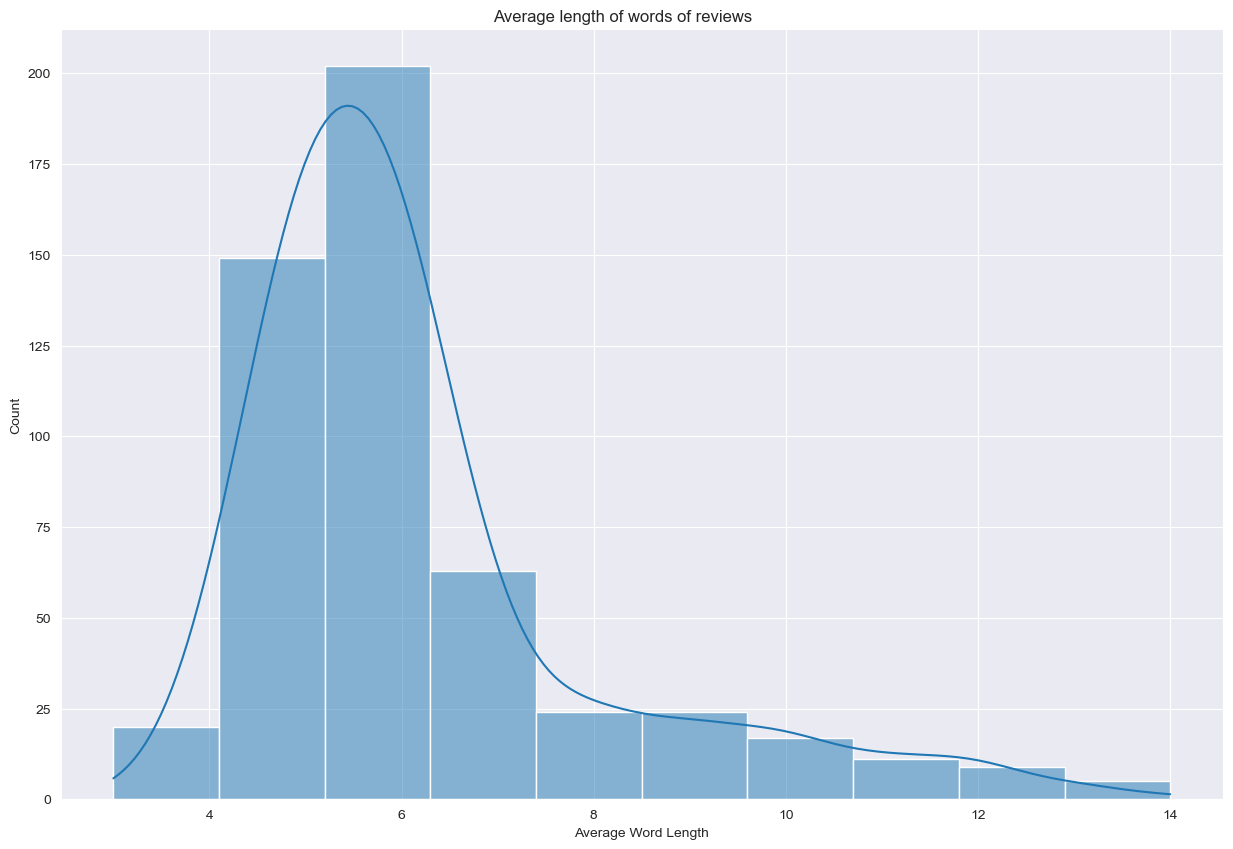

In [16]:
fig = plt.figure(figsize = (15,10))
plt.suptitle("Average length of words of reviews", y = 0.90)

# Splits each review into words, calculates the length of each word, and then calculates the average word length for each review
sns.histplot(data_eda["Review"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)), kde = True, bins = 10)
plt.xlabel('Average Word Length')
plt.show()

From the above histogram, it shows that the average word length of the reviews is between 3 to 9, with 6 being the most common average word length. We can also notice that the histogram is positively-skewed as the tail is to the right of the histogram. This might be due to the presence of stopwords. `Stopwords` are a set of commonly used words in a language, examples of stopwords in English are `'a', 'the', 'is', 'are'` etc. Since stopwords are usually very short in length, they provide very little useful information. <!-- However, we can analyse the amount of these stopwords to get us some insights about the data. -->

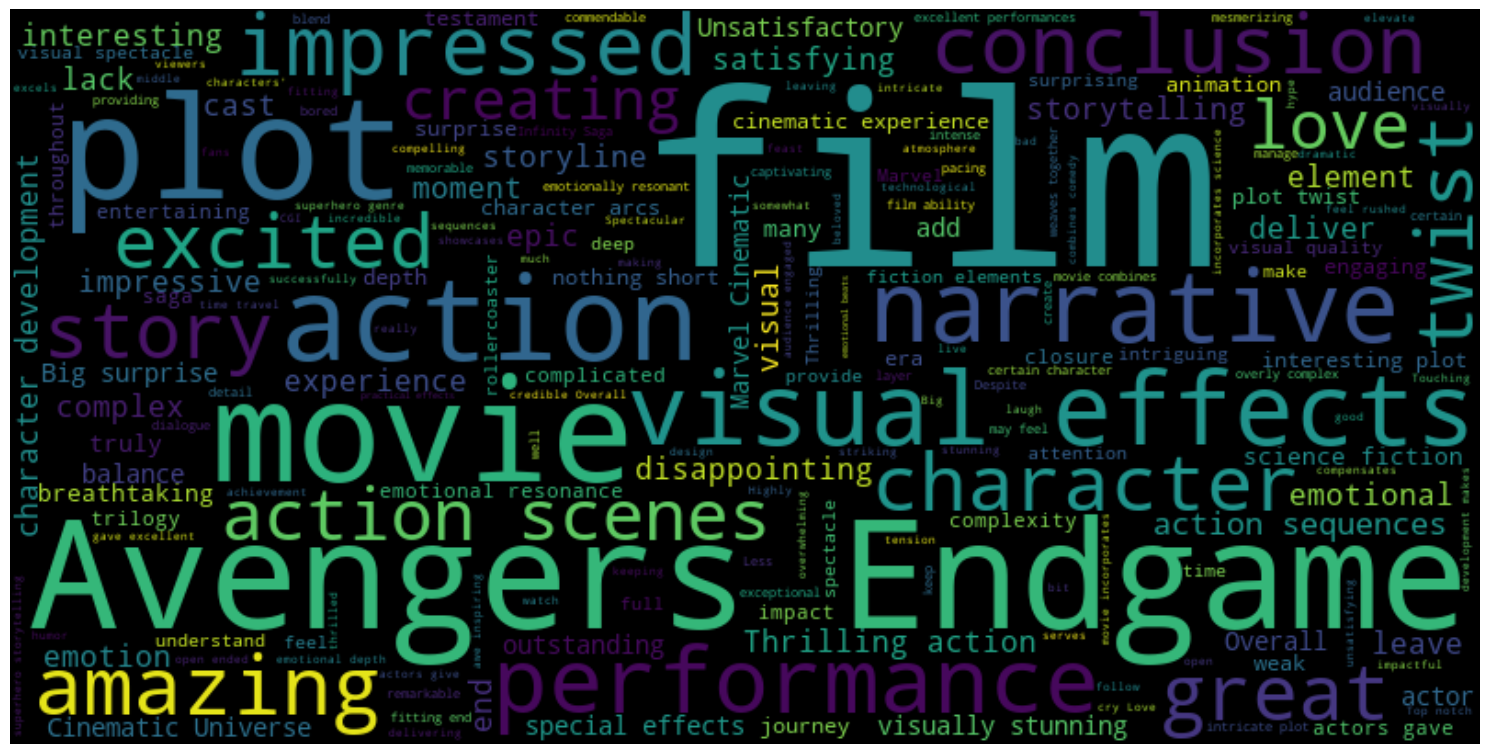

In [17]:
# Combine all text into one large string
text = " ".join(review for review in data_eda['Review'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Visualize the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

I have used WordCloud to generate the frequently used words and display them with different size as shown above. We can see that words such as `'film', 'movie', 'Avengers', 'Endgame', 'plot', 'action', 'conclusion'` are frequently used by reviewers when they are writing reviews. In general, these wordcloud shows that the model will be faced with more words like this, and these words will affect model performance to classify.

___
# Choosing Between Classification or Regression
___

Explanation:
1. When to Choose Classification:
    - `Discrete Output`: If the target variable represents categories or classes (e.g., sentiment labels such as positive, neutral, negative), classification is typically the appropriate choice.
    - `Binary or Multi-class`: Classification can handle binary classification tasks (two classes) as well as multi-class classification tasks (more than two classes).
    - `Interpretability`: Classification outputs are easily interpretable and intuitive, making them suitable for tasks where understanding the specific class or category is important.

2. When to Choose Regression:
    - `Continuous Output`: If the target variable represents a continuous range of values (e.g., ratings from 0 to 10), regression is typically the appropriate choice.
    - `Magnitude Matters`: Regression is suitable when the magnitude of the target variable is important and meaningful. For example, predicting movie ratings on a scale of 1 to 10.
    - `Quantitative Analysis`: Regression allows for quantitative analysis, making it suitable for tasks where precise numerical predictions are required.

##### `Choice: Classification`
- I have decided to choose to do Classification architectures using the given data. This is because the score of the reviews are between 0 and 1, which makes it easy to classify the reviews into two classes, 0 and 1. Furthermore, having a clear binary outcome is often more useful in applications such as sentiment analysis, where the main interest is in categorizing sentiments rather than measuring them on a fine-grained scale. Hence, we can create a classification architecture to predict the positivity/negativity of a review based on the words used, sentence strucutre etc. 

___
# Dropping Missing data
___
From our EDA previously, there is one missing values, hence we use `dropna()` to drop this row of data

In [18]:
data.dropna(subset=['Score'], inplace=True)

___
# Data Preparation - For Classification
___

In [19]:
# # Filter English Only
# data = data[data['Language'] == 'English']
X = list(data.Review.values)
y = data['Score'].values

print(f"The scores corresponding to the reviews in X: \n{y}")

The scores corresponding to the reviews in X: 
[0.08 0.7  0.12 0.05 0.4  0.15 0.85 0.25 0.12 0.1  0.75 0.12 0.1  0.8
 0.2  0.6  0.1  0.15 0.7  0.1  0.1  0.7  0.15 0.7  0.08 0.12 0.7  0.15
 0.1  0.12 0.8  0.1  0.6  0.7  0.12 0.1  0.75 0.2  0.15 0.12 0.12 0.25
 0.08 0.1  0.7  0.12 0.08 0.1  0.12 0.7  0.15 0.12 0.1  0.12 0.5  0.15
 0.8  0.05 0.05 0.6  0.1  0.08 0.3  0.12 0.7  0.15 0.1  0.06 0.65 0.1
 0.08 0.75 0.13 0.4  0.08 0.12 0.65 0.1  0.08 0.7  0.12 0.7  0.08 0.1
 0.7  0.12 0.08 0.12 0.8  0.1  0.4  0.7  0.12 0.08 0.75 0.15 0.12 0.12
 0.12 0.22 0.06 0.08 0.65 0.12 0.06 0.08 0.12 0.65 0.13 0.1  0.08 0.12
 0.5  0.12 0.05 0.3  0.08 0.06 0.22 0.12 0.7  0.15 0.1  0.06 0.5  0.1
 0.08 0.75 0.13 0.4  0.08 0.12 0.65 0.1  0.08 0.7  0.12 0.7  0.08 0.1
 0.7  0.12 0.08 0.12 0.5  0.12 0.06 0.3  0.08 0.07 0.4  0.07 0.5  0.12
 0.08 0.3  0.1  0.08 0.3  0.4  0.12 0.25 0.1  0.06 0.4  0.07 0.12 0.1
 0.3  0.15 0.08 0.25 0.1  0.08 0.3  0.07 0.06 0.08 0.3  0.12 0.06 0.4
 0.07 0.12 0.1  0.3  0.15 0.08 0.25 0

In [20]:
# Converting the scores of the dataset to either '0' or '1' for classification task
y = (data['Score'] >= 0.5).astype(int)

# Print the output of the
print(f"The new scores corresponding to the reviews in X (0 or 1): \n{y}")

The new scores corresponding to the reviews in X (0 or 1): 
206    0
207    1
208    0
209    0
210    0
      ..
221    1
222    0
223    0
224    1
225    0
Name: Score, Length: 523, dtype: int32


Since we are conducting classification on our dataset, we need to convert the `Score` to integer `0` or `1` where scores less than 0.5 are labelled as `0` and scores more than 0.5 are labelled as `1`. From the above cell output, we can see that the score values are changed successfully.

___
# Tokenization
___
Tokenization is the process of breaking down a stream of text into smaller units called tokens. These tokens can be words, subwords, phrases, or even individual characters, in our case we breaking our reviews into individual words. In the cell below, I mapped integers to all the words, using `.fit_on_texts()` and to convert text data into numerical form so that can be fed into machine learning models. Next, I visualized the results using `.word_index` and we can see the entire word dictionary we got from our dataset. Lastly, I sampled some output using `texts_to_sequences()` to convert some of the reviews to numerical form, which we will be doing to the entire dataset.  

In [21]:
# Tokenize the words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
print(f"{tokenizer.word_index}\n")

# View the first five reviews in the dataset - Text to Sequence
print("View the first five words in the dataset:")
for i in range(5):
    print(X[i])
    print(f"{tokenizer.texts_to_sequences([X[i]])[0]}\n")

{'the': 1, 'a': 2, 'of': 3, 'and': 4, 'this': 5, 'to': 6, 'is': 7, 'i': 8, 'film': 9, 'action': 10, 'plot': 11, 'movie': 12, 'in': 13, 'avengers': 14, 'with': 15, 'effects': 16, 'visual': 17, 'endgame': 18, 'are': 19, 'character': 20, 'emotional': 21, 'too': 22, 'that': 23, 'an': 24, 'cinematic': 25, 'like': 26, 'narrative': 27, 'amazing': 28, 'very': 29, 'not': 30, 'impressed': 31, "i'm": 32, 'conclusion': 33, 'interesting': 34, "film's": 35, 'experience': 36, 'epic': 37, 'love': 38, 'it': 39, 'scenes': 40, 'story': 41, 'great': 42, 'sequences': 43, 'excited': 44, 'twist': 45, 'end': 46, 'while': 47, 'actors': 48, 'but': 49, 'performances': 50, 'thrilling': 51, 'storytelling': 52, 'how': 53, 'elements': 54, 'its': 55, 'moments': 56, 'characters': 57, 'marvel': 58, 'creating': 59, 'complex': 60, 'many': 61, 'visually': 62, 'stunning': 63, 'satisfying': 64, 'me': 65, 'from': 66, 'for': 67, 'may': 68, 'feel': 69, 'about': 70, 'big': 71, 'overall': 72, 'spectacle': 73, 'some': 74, "endgam

Keras provides utilities, using the Tokenizer class from the tensorflow.keras.preprocessing.text module for converting text data into numerical representations, including encoding words into integers. From the sample output of first 5 reviews, we can see that each word is mapped to an integer indices, allowing us natural language processing tasks such as text classification, language modeling and regression tasks.

In [22]:
# Convert the text to sequence
X = tokenizer.texts_to_sequences(X)

# Print X after converting te text to sequence 
print(X)

[[5, 12, 7, 28, 1, 10, 7, 117, 4, 1, 11, 7, 149], [32, 353, 15, 1, 354, 83, 30, 64], [1, 98, 7, 163, 4, 150, 3, 279, 8, 38, 39], [5, 12, 89, 24, 108, 36, 118, 164], [22, 61, 10, 40, 280, 355, 22, 197], [32, 227, 138, 1, 12, 126, 52], [14, 18, 7, 90, 4, 22, 562, 30, 563], [8, 26, 53, 5, 12, 165, 54, 3, 119, 120, 34], [5, 9, 7, 118, 76, 15, 109, 21, 564], [2, 25, 36, 23, 7, 281, 32, 31], [8, 69, 5, 12, 282, 435, 1, 198, 436, 30, 64], [28, 10, 4, 2, 11, 150, 3, 178, 32, 31], [1, 17, 151, 3, 5, 9, 7, 437, 44, 70, 55, 99, 16], [32, 30, 283, 15, 53, 1, 356, 48, 284, 121, 565, 30, 228], [1, 98, 7, 60, 49, 29, 34, 8, 26, 39], [197, 4, 229, 10, 40, 22, 61, 99, 16], [5, 9, 357, 15, 1, 230, 39, 285, 32, 31], [1, 48, 179, 180, 50, 8, 26, 5, 41], [8, 100, 152, 1, 11, 3, 5, 9, 22, 60], [2, 71, 77, 13, 1, 11, 51, 10, 138], [1, 17, 16, 3, 5, 9, 19, 118, 164, 32, 31], [24, 127, 181, 4, 231, 11, 122, 64, 33], [5, 9, 153, 65, 232, 4, 233, 38, 1, 110, 199], [1, 48, 566, 6, 567, 121, 57, 166, 30, 167], [72

As mentioned at the start, I will be using `.texts_to_sequences()` to create lists of lists, where each list represents a list of integer indices corresponding to words in a sentence from the dataset. The length of each list is the maximum length of a sentence in the dataset. However, in order to feed our data properly into the model without getting any input errors, we need to make the length of each list to be the same, through pad sequence.

___
# Pad Sequences
___

In order to feed this data into our RNN, all input documents must have the same length

E.g. Using two different lists:
- 1st list: `[2,  25,  132, 52, 1,  59, 582, 254, 65, 98, 100]`
- 2nd list: `[76, 234, 354, 23, 43, 56, 100]`

#### `After using Pad Sequences`

- 1st list: `[2,  25,  132, 52, 1,  59, 582, 254, 65, 98, 100]`
- 2nd list: `[0,  0,   0,   0,  76, 234, 354, 23, 43, 56, 100]`

From the above example, we can see that the pad sequences adds zeros in the list such that the length of the list will be equal to the highest length of the lists in the lists. Hence, this allows that the data to be parsed into the model without any input errors.

In [23]:
# Getting the review lengths
review_lengths = [len(seq) for seq in X]
maxlen = int(np.percentile(review_lengths, 95)) 

# Using Pad Sequence on our X value
X = sequence.pad_sequences(X, maxlen=maxlen)

# Print X after doing pad sequence on it
print(X)

[[  0   0   0 ...  11   7 149]
 [  0   0   0 ...  83  30  64]
 [  0   0   0 ...   8  38  39]
 ...
 [  0   0   0 ...   0   0 421]
 [  0   0   0 ... 813   4 226]
 [  0   0   0 ...   0   0 814]]


From the above cell output, I have successfully ensure that all the length of the indices list are equal. Moving on, we can split our data into training, testing and validation sets.

___
# Split the dataset into train/test data
___
In the next two cell, I will be using `train_test_split()` to split the data twice in order to get our train, test and validation set, and also print out the shape of all the set using `.shape` to ensure that the data shape is suitable to be parsed into the model for training.

In [24]:
# Split the data into training and temporary sets
data_X_train, data_X_temp, scores_y_train, scores_y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary set into validation and test sets
data_X_val, data_X_test, scores_y_val, scores_y_test = train_test_split(data_X_temp, scores_y_temp, test_size=0.5, random_state=42)

In [25]:
print(f"Shape of data_X_train (Reviews): {data_X_train.shape}")
print(f"Shape of data_X_test (Reviews): {data_X_test.shape}")
print(f"Shape of data_X_val (Reviews)): {data_X_val.shape}")

print(f"\nShape of scores_y_train (Scores): {scores_y_train.shape}")
print(f"Shape of scores_y_test (Scores): {scores_y_test.shape}")
print(f"Shape of scores_y_val (Scores): {scores_y_val.shape}")

Shape of data_X_train (Reviews): (313, 44)
Shape of data_X_test (Reviews): (105, 44)
Shape of data_X_val (Reviews)): (105, 44)

Shape of scores_y_train (Scores): (313,)
Shape of scores_y_test (Scores): (105,)
Shape of scores_y_val (Scores): (105,)


From the output above, the shape of all six data are in the correct format I want, thus, I can start creating my baseline models 

___
# Create & Evaluate Baseline RNN Model - Classification
___

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 44, 100)           81500     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 110,941
Trainable params: 110,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 2s 67ms/step - loss: 0.7065 - accuracy: 0.5367 - val_loss: 0.5859 - val_accuracy: 0.7143
Epoch 2/30
10/10 [==============================] - 0s 47ms/step - loss: 0.5886 - accuracy: 0.6933 - val_loss: 0.5838 - val_accuracy: 0.7143
Epoch 3/30
10/10 [==============

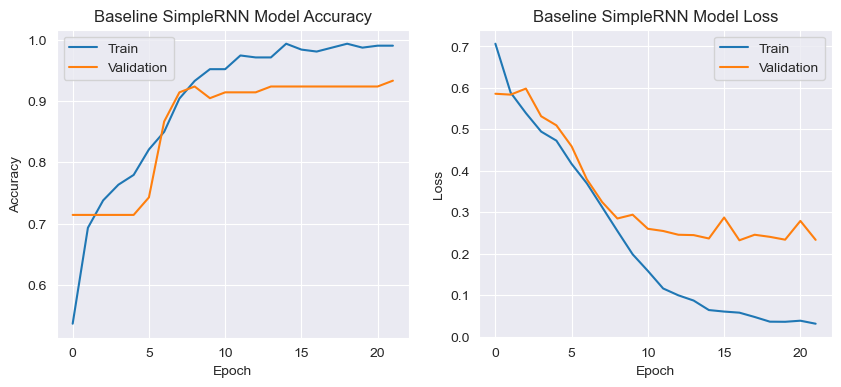

In [26]:
# Defining the vocabulary size for the model
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# Creating Model
base_RNN_model = Sequential()
base_RNN_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))  # Adjust output_dim as needed
base_RNN_model.add(SimpleRNN(units=128, dropout=0.2, recurrent_dropout=0.2))
base_RNN_model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
base_RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_RNN_model.summary()

# Training of the model using our data, at 30 epochs, batch size of 32 and using Early_Stopping
history_base_RNN_model = base_RNN_model.fit(data_X_train, scores_y_train, validation_data=(data_X_val, scores_y_val), epochs=30, batch_size=32, callbacks = [early_stopping])

# Final evaluation of the model - Accuracy
base_RNN_scores = base_RNN_model.evaluate(data_X_test, scores_y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (base_RNN_scores[1]*100))

# Plot the accuracy and loss results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history_base_RNN_model.history['accuracy'])
ax[0].plot(history_base_RNN_model.history['val_accuracy'])
ax[0].set_title('Baseline SimpleRNN Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history_base_RNN_model.history['loss'])
ax[1].plot(history_base_RNN_model.history['val_loss'])
ax[1].set_title('Baseline SimpleRNN Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

# Show the plot
plt.show()

From the cell output above, the accuracy of the baseline simpleRNN is about 91%, which is quite high. However, there are some overfitting issues, especially more obvious on the model loss, where the difference between training loss and validation loss is high. 

___
# Create & Evaluate Baseline LTSM Model - Classification
___

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 44, 100)           81500     
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 198,877
Trainable params: 198,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 4s 208ms/step - loss: 0.6333 - accuracy: 0.7029 - val_loss: 0.6177 - val_accuracy: 0.7143
Epoch 2/30
10/10 [==============================] - 2s 201ms/step - loss: 0.5639 - accuracy: 0.7412 - val_loss: 0.5686 - val_accuracy: 0.7143
Epoch 3/30
10/10 [==========

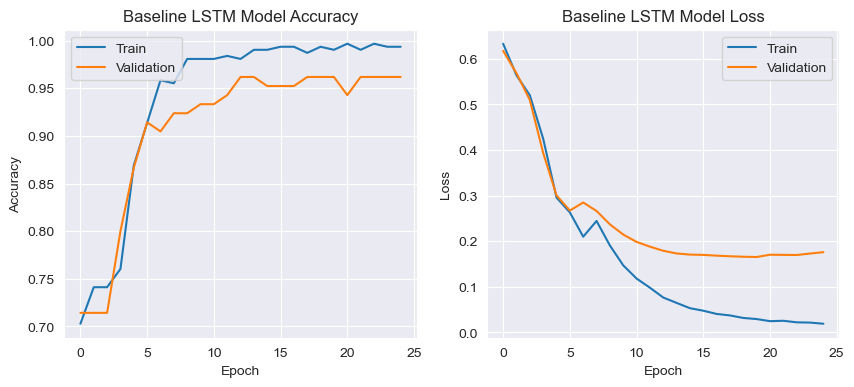

In [27]:
# Create base LSTM Model
base_LSTM_model = Sequential()
base_LSTM_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))  # Adjust output_dim as needed
base_LSTM_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
base_LSTM_model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
base_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_LSTM_model.summary()

# Training of the model using our data, at 30 epochs, batch size of 32 and using Early_Stopping
history_base_LSTM_model = base_LSTM_model.fit(data_X_train, scores_y_train, validation_data=(data_X_val, scores_y_val), epochs=30, batch_size=32, callbacks = [early_stopping])

# Final evaluation of the model - Accuracy
base_LSTM_scores = base_LSTM_model.evaluate(data_X_test, scores_y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (base_LSTM_scores[1]*100))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Summarize history for accuracy
ax[0].plot(history_base_LSTM_model.history['accuracy'])
ax[0].plot(history_base_LSTM_model.history['val_accuracy'])
ax[0].set_title('Baseline LSTM Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
ax[1].plot(history_base_LSTM_model.history['loss'])
ax[1].plot(history_base_LSTM_model.history['val_loss'])
ax[1].set_title('Baseline LSTM Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

# Show the plot
plt.show()

From the output above, the LSTM has a even better accuracy than SimpleRNN, with an accuracy of about 92%. However, the LSTM model has a worse overfitting situation, with the gap between the training and validation accuracy, and between training and validation loss, being higher as compared to SimpleRNN.

___
# Create & Evaluate Baseline GRU Model - Classification
___

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 44, 100)           81500     
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 169,949
Trainable params: 169,949
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 3s 174ms/step - loss: 0.6512 - accuracy: 0.7093 - val_loss: 0.5946 - val_accuracy: 0.7143
Epoch 2/30
10/10 [==============================] - 1s 151ms/step - loss: 0.5539 - accuracy: 0.7412 - val_loss: 0.5293 - val_accuracy: 0.7143
Epoch 3/30
10/10 [==========

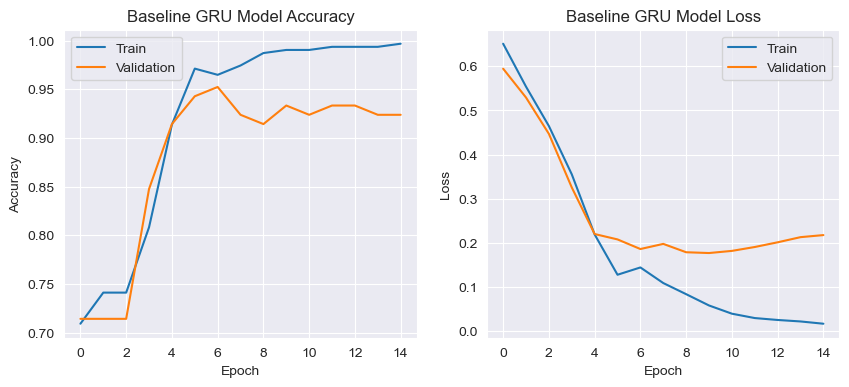

In [28]:
# Create baseline GRU model
base_GRU_model = Sequential()
base_GRU_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))  # Adjust output_dim as needed
base_GRU_model.add(GRU(units=128, dropout=0.2, recurrent_dropout=0.2))
base_GRU_model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
base_GRU_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_GRU_model.summary()

# Training of the model using our data, at 30 epochs, batch size of 32 and using Early_Stopping
history_base_GRU_model = base_GRU_model.fit(data_X_train, scores_y_train, validation_data=(data_X_val, scores_y_val), epochs=30, batch_size=32, callbacks = [early_stopping])

# Final evaluation of the model - Accuracy
base_GRU_scores = base_GRU_model.evaluate(data_X_test, scores_y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (base_GRU_scores[1]*100))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Summarize history for accuracy
ax[0].plot(history_base_GRU_model.history['accuracy'])
ax[0].plot(history_base_GRU_model.history['val_accuracy'])
ax[0].set_title('Baseline GRU Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
ax[1].plot(history_base_GRU_model.history['loss'])
ax[1].plot(history_base_GRU_model.history['val_loss'])
ax[1].set_title('Baseline GRU Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

# Show the plot
plt.show()

From the output above, the GRU has better accuracy than SimpleRNN and LSTM, with an accuracy of about 93%. Baseline GRU model also has an overfitting situation, with the gap between the training and validation accuracy, and between training and validation loss, being high too.

___
# Comparison of all three model - Accuracy & Loss
___

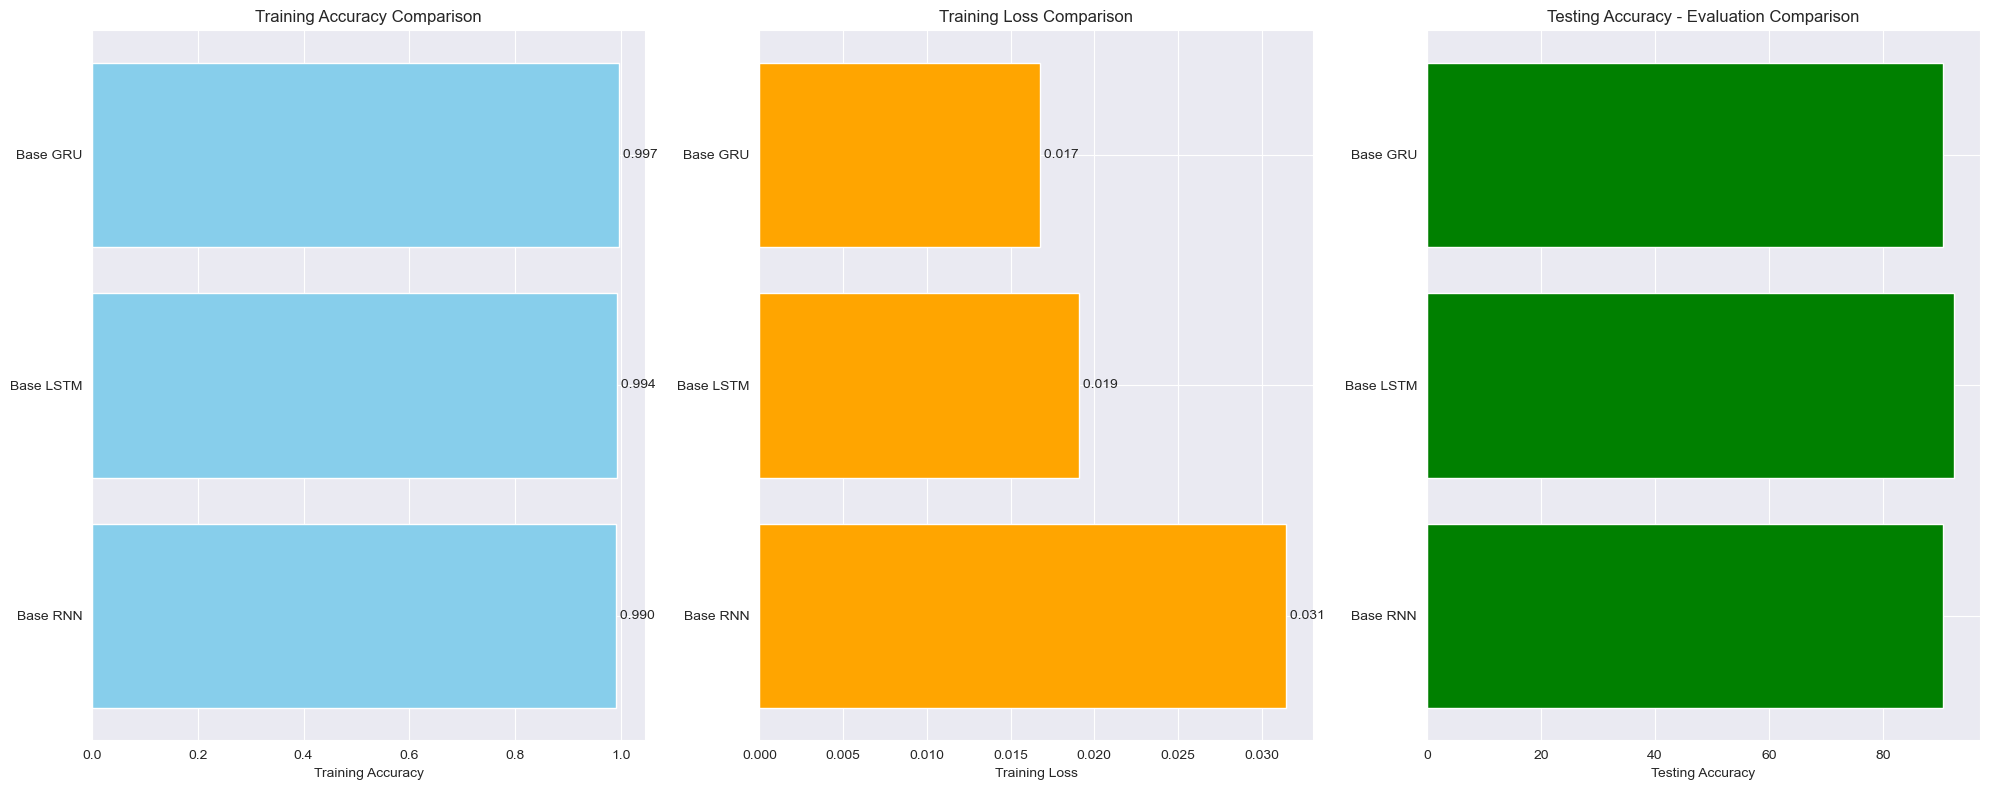

In [29]:
# Extract accuracy and loss values
accuracy_base_RNN = history_base_RNN_model.history['accuracy'][-1]
accuracy_base_LSTM = history_base_LSTM_model.history['accuracy'][-1]
accuracy_base_GRU = history_base_GRU_model.history['accuracy'][-1]

loss_base_RNN = history_base_RNN_model.history['loss'][-1]
loss_base_LSTM = history_base_LSTM_model.history['loss'][-1]
loss_base_GRU = history_base_GRU_model.history['loss'][-1]

scores_base_RNN = (base_RNN_scores[1]*100)
scores_base_LSTM = (base_LSTM_scores[1]*100)
scores_base_GRU = (base_GRU_scores[1]*100)

# Create lists for plotting
models = ['Base RNN', 'Base LSTM', 'Base GRU']
accuracy_values = [accuracy_base_RNN, accuracy_base_LSTM, accuracy_base_GRU]
loss_values = [loss_base_RNN, loss_base_LSTM, loss_base_GRU]
scores_values = [scores_base_RNN, scores_base_LSTM, scores_base_GRU]

# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# Plot bar plot for accuracy
ax[0].barh(models, accuracy_values, color='skyblue')
ax[0].set_xlabel('Training Accuracy')
ax[0].set_title('Training Accuracy Comparison')
# Add values beside each bar
for i, value in enumerate(accuracy_values):
    ax[0].text(value, i, f' {value:.3f}', va='center', ha='left')

# Plot bar plot for loss
ax[1].barh(models, loss_values, color='orange')
ax[1].set_xlabel('Training Loss')
ax[1].set_title('Training Loss Comparison')
# Add values beside each bar
for i, value in enumerate(loss_values):
    ax[1].text(value, i, f' {value:.3f}', va='center', ha='left')

# Plot bar plot for evaluated scores
ax[2].barh(models, scores_values, color='green')
ax[2].set_xlabel('Testing Accuracy')
ax[2].set_title('Testing Accuracy - Evaluation Comparison')

fig.tight_layout()
plt.show()

In the cell above, I plotted bar graph on the training accuracy and loss, together with the overall accuracy which is evaluated using `.evaluate()`. The bar graph shows that GRU has the highest training accuracy and testing accuracy, and the lowest training loss, meaning using GRU layers on our model is the best. However, I will do hyperparameter tuning and see if any model improves its accuracy. 

___
# SimpleRNN Model Improvement - Hyperparameter Tuning
___

In [30]:
# Define the function to create the model
def create_model(units, dropout, lr, num_layers):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    
    # Add the specified number of SimpleRNN layers
    for i in range(num_layers):
        if i == num_layers - 1:  # Last layer
            model.add(SimpleRNN(units=units, dropout=dropout, recurrent_dropout=dropout))
        else:  # Intermediate layers
            model.add(SimpleRNN(units=units, dropout=dropout, recurrent_dropout=dropout, return_sequences=True))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid
param_grid = {
    'units': [64, 128, 256],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01, 0.1],
    'num_layers': [1, 2, 3]  # Adding num_layers to the parameter grid
}

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model)

# Perform Randomized Search CV
random_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10)
random_search.fit(data_X_train, scores_y_train, validation_data=(data_X_val, scores_y_val), epochs=30, batch_size=32, callbacks=[early_stopping])

# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# Evaluate the best model on the test data
best_model = random_search.best_estimator_.model
best_model.evaluate(data_X_test, scores_y_test)


C:\Users\angmi\AppData\Local\Temp\ipykernel_26320\1212208084.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)
c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
8/8 [==============================] - 5s 250ms/step - loss: 0.6587 - accuracy: 0.6120 - val_loss: 0.4587 - val_accuracy: 0.8095
Epoch 2/30
8/8 [==============================] - 1s 184ms/step - loss: 0.4080 - accuracy: 0.8240 - val_loss: 0.3226 - val_accuracy: 0.8762
Epoch 3/30
8/8 [==============================] - 2s 195ms/step - loss: 0.2451 - accuracy: 0.9280 - val_loss: 0.2817 - val_accuracy: 0.8857
Epoch 4/30
8/8 [==============================] - 2s 219ms/step - loss: 0.1251 - accuracy: 0.9560 - val_loss: 0.2665 - val_accuracy: 0.9238
Epoch 5/30
8/8 [==============================] - 1s 170ms/step - loss: 0.0588 - accuracy: 0.9760 - val_loss: 0.3031 - val_accuracy: 0.9238
Epoch 6/30
8/8 [==============================] - 1s 170ms/step - loss: 0.0386 - accuracy: 0.9880 - val_loss: 0.3619 - val_accuracy: 0.9048
Epoch 7/30
8/8 [==============================] - 0s 56ms/step - loss: 0.0267 - accuracy: 0.9960 - val_loss: 0.3962 - val_accuracy: 0.9143
Epoch 8/30
8/8 [=====

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 73ms/step - loss: 0.6165 - accuracy: 0.6560 - val_loss: 0.5780 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 0s 54ms/step - loss: 0.4142 - accuracy: 0.8160 - val_loss: 0.3042 - val_accuracy: 0.9238
Epoch 3/30
8/8 [==============================] - 0s 51ms/step - loss: 0.1871 - accuracy: 0.9600 - val_loss: 0.3126 - val_accuracy: 0.9238
Epoch 4/30
8/8 [==============================] - 0s 52ms/step - loss: 0.0848 - accuracy: 0.9720 - val_loss: 0.3267 - val_accuracy: 0.9238
Epoch 5/30
8/8 [==============================] - 0s 52ms/step - loss: 0.0800 - accuracy: 0.9720 - val_loss: 0.3553 - val_accuracy: 0.9238
Epoch 6/30
8/8 [==============================] - 0s 52ms/step - loss: 0.0360 - accuracy: 0.9920 - val_loss: 0.3759 - val_accuracy: 0.9238
Epoch 7/30
2/2 [==============================] - 0s 6ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 76ms/step - loss: 0.6053 - accuracy: 0.6800 - val_loss: 0.6552 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 0s 57ms/step - loss: 0.4140 - accuracy: 0.8240 - val_loss: 0.3950 - val_accuracy: 0.8476
Epoch 3/30
8/8 [==============================] - 0s 54ms/step - loss: 0.1869 - accuracy: 0.9440 - val_loss: 0.3466 - val_accuracy: 0.8667
Epoch 4/30
8/8 [==============================] - 0s 53ms/step - loss: 0.0896 - accuracy: 0.9680 - val_loss: 0.3375 - val_accuracy: 0.8476
Epoch 5/30
8/8 [==============================] - 0s 52ms/step - loss: 0.0749 - accuracy: 0.9600 - val_loss: 0.3672 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 0s 59ms/step - loss: 0.0682 - accuracy: 0.9760 - val_loss: 0.3955 - val_accuracy: 0.8571
Epoch 7/30
8/8 [==============================] - 0s 51ms/step - loss: 0.0465 - accuracy: 0.9840 - val_loss: 0.3794 - val_accuracy: 0.8762
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 80ms/step - loss: 0.6356 - accuracy: 0.6175 - val_loss: 0.4906 - val_accuracy: 0.7333
Epoch 2/30
8/8 [==============================] - 1s 63ms/step - loss: 0.4661 - accuracy: 0.7849 - val_loss: 0.4048 - val_accuracy: 0.8667
Epoch 3/30
8/8 [==============================] - 0s 61ms/step - loss: 0.2811 - accuracy: 0.9124 - val_loss: 0.3117 - val_accuracy: 0.8857
Epoch 4/30
8/8 [==============================] - 0s 55ms/step - loss: 0.1404 - accuracy: 0.9602 - val_loss: 0.2842 - val_accuracy: 0.8857
Epoch 5/30
8/8 [==============================] - 0s 63ms/step - loss: 0.0963 - accuracy: 0.9721 - val_loss: 0.2975 - val_accuracy: 0.8857
Epoch 6/30
8/8 [==============================] - 0s 53ms/step - loss: 0.0692 - accuracy: 0.9801 - val_loss: 0.3075 - val_accuracy: 0.8857
Epoch 7/30
8/8 [==============================] - 0s 58ms/step - loss: 0.0435 - accuracy: 0.9841 - val_loss: 0.3316 - val_accuracy: 0.8857
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 74ms/step - loss: 0.6103 - accuracy: 0.6375 - val_loss: 0.5624 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 0s 52ms/step - loss: 0.4148 - accuracy: 0.8247 - val_loss: 0.4136 - val_accuracy: 0.7619
Epoch 3/30
8/8 [==============================] - 0s 52ms/step - loss: 0.2339 - accuracy: 0.9163 - val_loss: 0.2830 - val_accuracy: 0.9048
Epoch 4/30
8/8 [==============================] - 0s 57ms/step - loss: 0.1286 - accuracy: 0.9602 - val_loss: 0.2691 - val_accuracy: 0.9143
Epoch 5/30
8/8 [==============================] - 0s 51ms/step - loss: 0.0577 - accuracy: 0.9880 - val_loss: 0.2567 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 0s 57ms/step - loss: 0.0762 - accuracy: 0.9681 - val_loss: 0.3353 - val_accuracy: 0.8952
Epoch 7/30
8/8 [==============================] - 0s 57ms/step - loss: 0.0725 - accuracy: 0.9721 - val_loss: 0.3775 - val_accuracy: 0.8952
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 73ms/step - loss: 0.7115 - accuracy: 0.5000 - val_loss: 0.6444 - val_accuracy: 0.7714
Epoch 2/30
8/8 [==============================] - 0s 51ms/step - loss: 0.6419 - accuracy: 0.6520 - val_loss: 0.5910 - val_accuracy: 0.7524
Epoch 3/30
8/8 [==============================] - 0s 51ms/step - loss: 0.5957 - accuracy: 0.7040 - val_loss: 0.5600 - val_accuracy: 0.7905
Epoch 4/30
8/8 [==============================] - 0s 53ms/step - loss: 0.5736 - accuracy: 0.7640 - val_loss: 0.5269 - val_accuracy: 0.7238
Epoch 5/30
8/8 [==============================] - 0s 52ms/step - loss: 0.5158 - accuracy: 0.8280 - val_loss: 0.5063 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 0s 58ms/step - loss: 0.4755 - accuracy: 0.8120 - val_loss: 0.4963 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 0s 62ms/step - loss: 0.4363 - accuracy: 0.8080 - val_loss: 0.4962 - val_accuracy: 0.7143
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 77ms/step - loss: 0.7142 - accuracy: 0.5160 - val_loss: 0.6099 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 0s 57ms/step - loss: 0.6476 - accuracy: 0.6360 - val_loss: 0.5617 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 0s 61ms/step - loss: 0.5401 - accuracy: 0.7760 - val_loss: 0.5613 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 0s 55ms/step - loss: 0.5069 - accuracy: 0.7800 - val_loss: 0.5879 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 0s 59ms/step - loss: 0.4558 - accuracy: 0.7720 - val_loss: 0.5720 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 65ms/step - loss: 0.4490 - accuracy: 0.7960 - val_loss: 0.5061 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 0s 57ms/step - loss: 0.4110 - accuracy: 0.8280 - val_loss: 0.4618 - val_accuracy: 0.7429
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 72ms/step - loss: 0.7061 - accuracy: 0.5280 - val_loss: 0.6139 - val_accuracy: 0.7810
Epoch 2/30
8/8 [==============================] - 0s 56ms/step - loss: 0.6272 - accuracy: 0.7040 - val_loss: 0.5521 - val_accuracy: 0.7333
Epoch 3/30
8/8 [==============================] - 0s 56ms/step - loss: 0.5506 - accuracy: 0.7320 - val_loss: 0.5371 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 0s 57ms/step - loss: 0.4860 - accuracy: 0.7920 - val_loss: 0.5303 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 0s 55ms/step - loss: 0.4591 - accuracy: 0.7760 - val_loss: 0.5400 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 65ms/step - loss: 0.4336 - accuracy: 0.8200 - val_loss: 0.4789 - val_accuracy: 0.7333
Epoch 7/30
8/8 [==============================] - 0s 51ms/step - loss: 0.3735 - accuracy: 0.8480 - val_loss: 0.4336 - val_accuracy: 0.7810
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 80ms/step - loss: 0.6903 - accuracy: 0.5498 - val_loss: 0.5768 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 0s 54ms/step - loss: 0.5931 - accuracy: 0.6932 - val_loss: 0.5612 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 0s 51ms/step - loss: 0.5374 - accuracy: 0.7490 - val_loss: 0.6238 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 0s 52ms/step - loss: 0.5056 - accuracy: 0.7610 - val_loss: 0.6008 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 0s 53ms/step - loss: 0.4452 - accuracy: 0.7729 - val_loss: 0.5091 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 0s 53ms/step - loss: 0.4325 - accuracy: 0.8287 - val_loss: 0.4647 - val_accuracy: 0.7333
Epoch 7/30
8/8 [==============================] - 0s 58ms/step - loss: 0.3813 - accuracy: 0.8367 - val_loss: 0.4315 - val_accuracy: 0.7810
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 87ms/step - loss: 0.6763 - accuracy: 0.6056 - val_loss: 0.6226 - val_accuracy: 0.6952
Epoch 2/30
8/8 [==============================] - 0s 53ms/step - loss: 0.6453 - accuracy: 0.6614 - val_loss: 0.5665 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 0s 56ms/step - loss: 0.5537 - accuracy: 0.7490 - val_loss: 0.5851 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 0s 55ms/step - loss: 0.4772 - accuracy: 0.7610 - val_loss: 0.6108 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 0s 55ms/step - loss: 0.4921 - accuracy: 0.7530 - val_loss: 0.5634 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 0s 54ms/step - loss: 0.4391 - accuracy: 0.8008 - val_loss: 0.5063 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 0s 56ms/step - loss: 0.4191 - accuracy: 0.8247 - val_loss: 0.4564 - val_accuracy: 0.7429
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 140ms/step - loss: 0.7291 - accuracy: 0.5480 - val_loss: 0.5995 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 97ms/step - loss: 0.5979 - accuracy: 0.6760 - val_loss: 0.8824 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 103ms/step - loss: 0.6145 - accuracy: 0.7040 - val_loss: 0.7190 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 99ms/step - loss: 0.5982 - accuracy: 0.6880 - val_loss: 0.6605 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 97ms/step - loss: 0.5702 - accuracy: 0.7080 - val_loss: 0.7608 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 104ms/step - loss: 0.5296 - accuracy: 0.7600 - val_loss: 0.5286 - val_accuracy: 0.7429
Epoch 7/30
8/8 [==============================] - 1s 110ms/step - loss: 0.5401 - accuracy: 0.7560 - val_loss: 0.5315 - val_accuracy: 0.7429
Epoch 8/30
8/8 [==================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 8s 459ms/step - loss: 0.7288 - accuracy: 0.5080 - val_loss: 0.7620 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 356ms/step - loss: 0.6052 - accuracy: 0.7400 - val_loss: 0.8484 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 333ms/step - loss: 0.5417 - accuracy: 0.7640 - val_loss: 0.6433 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 320ms/step - loss: 0.5306 - accuracy: 0.7640 - val_loss: 0.6950 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 3s 411ms/step - loss: 0.5382 - accuracy: 0.7480 - val_loss: 0.6364 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 3s 342ms/step - loss: 0.5751 - accuracy: 0.7200 - val_loss: 0.5363 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 3s 363ms/step - loss: 0.5412 - accuracy: 0.7600 - val_loss: 0.6129 - val_accuracy: 0.7143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 139ms/step - loss: 0.6859 - accuracy: 0.5960 - val_loss: 0.5867 - val_accuracy: 0.6952
Epoch 2/30
8/8 [==============================] - 1s 102ms/step - loss: 0.6802 - accuracy: 0.6000 - val_loss: 0.9588 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 100ms/step - loss: 0.6685 - accuracy: 0.6920 - val_loss: 0.5776 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 105ms/step - loss: 0.6008 - accuracy: 0.6840 - val_loss: 0.5542 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 109ms/step - loss: 0.5291 - accuracy: 0.7280 - val_loss: 0.7440 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 102ms/step - loss: 0.4922 - accuracy: 0.7800 - val_loss: 0.4997 - val_accuracy: 0.7429
Epoch 7/30
8/8 [==============================] - 1s 98ms/step - loss: 0.5250 - accuracy: 0.7640 - val_loss: 0.6130 - val_accuracy: 0.7143
Epoch 8/30
8/8 [================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 140ms/step - loss: 0.7260 - accuracy: 0.5418 - val_loss: 0.6031 - val_accuracy: 0.7048
Epoch 2/30
8/8 [==============================] - 1s 108ms/step - loss: 0.6427 - accuracy: 0.6614 - val_loss: 0.8503 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 100ms/step - loss: 0.5880 - accuracy: 0.7450 - val_loss: 0.7256 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 103ms/step - loss: 0.5591 - accuracy: 0.7649 - val_loss: 0.5760 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 109ms/step - loss: 0.5459 - accuracy: 0.7729 - val_loss: 0.6454 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 100ms/step - loss: 0.5146 - accuracy: 0.7649 - val_loss: 0.6272 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 1s 105ms/step - loss: 0.4680 - accuracy: 0.7769 - val_loss: 0.5404 - val_accuracy: 0.7143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 139ms/step - loss: 0.7395 - accuracy: 0.5060 - val_loss: 0.6087 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 103ms/step - loss: 0.6603 - accuracy: 0.6414 - val_loss: 0.7876 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 99ms/step - loss: 0.5796 - accuracy: 0.7490 - val_loss: 0.8588 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 101ms/step - loss: 0.5514 - accuracy: 0.7570 - val_loss: 0.7435 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 102ms/step - loss: 0.5273 - accuracy: 0.7291 - val_loss: 0.6705 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 105ms/step - loss: 0.5362 - accuracy: 0.7371 - val_loss: 0.5623 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 1s 105ms/step - loss: 0.5310 - accuracy: 0.7331 - val_loss: 0.5722 - val_accuracy: 0.7143
Epoch 8/30
8/8 [================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 187ms/step - loss: 0.6693 - accuracy: 0.6320 - val_loss: 0.9835 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 154ms/step - loss: 0.6799 - accuracy: 0.6800 - val_loss: 0.7014 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 149ms/step - loss: 0.6155 - accuracy: 0.7280 - val_loss: 0.5254 - val_accuracy: 0.7619
Epoch 4/30
8/8 [==============================] - 1s 145ms/step - loss: 0.5585 - accuracy: 0.7440 - val_loss: 0.6035 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 149ms/step - loss: 0.4736 - accuracy: 0.8200 - val_loss: 0.7016 - val_accuracy: 0.5905
Epoch 6/30
8/8 [==============================] - 1s 143ms/step - loss: 0.3482 - accuracy: 0.8760 - val_loss: 0.4639 - val_accuracy: 0.8476
Epoch 7/30
8/8 [==============================] - 1s 158ms/step - loss: 0.2412 - accuracy: 0.9120 - val_loss: 0.2573 - val_accuracy: 0.9048
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 4s 210ms/step - loss: 0.6545 - accuracy: 0.6520 - val_loss: 1.0633 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 144ms/step - loss: 0.5821 - accuracy: 0.7320 - val_loss: 0.6852 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 146ms/step - loss: 0.5878 - accuracy: 0.7440 - val_loss: 0.6254 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 159ms/step - loss: 0.5212 - accuracy: 0.7920 - val_loss: 0.4025 - val_accuracy: 0.8667
Epoch 5/30
8/8 [==============================] - 1s 153ms/step - loss: 0.4212 - accuracy: 0.8360 - val_loss: 0.5951 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 140ms/step - loss: 0.3282 - accuracy: 0.8840 - val_loss: 0.3048 - val_accuracy: 0.8952
Epoch 7/30
8/8 [==============================] - 1s 144ms/step - loss: 0.2546 - accuracy: 0.9240 - val_loss: 0.3398 - val_accuracy: 0.8857
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 202ms/step - loss: 0.7290 - accuracy: 0.6120 - val_loss: 1.0690 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 141ms/step - loss: 0.6954 - accuracy: 0.6680 - val_loss: 0.5865 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 152ms/step - loss: 0.6348 - accuracy: 0.6800 - val_loss: 0.6098 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 150ms/step - loss: 0.5399 - accuracy: 0.7200 - val_loss: 0.5226 - val_accuracy: 0.7429
Epoch 5/30
8/8 [==============================] - 1s 158ms/step - loss: 0.5573 - accuracy: 0.7520 - val_loss: 0.6105 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 149ms/step - loss: 0.5620 - accuracy: 0.7480 - val_loss: 0.5397 - val_accuracy: 0.8190
Epoch 7/30
8/8 [==============================] - 1s 154ms/step - loss: 0.5255 - accuracy: 0.7560 - val_loss: 0.4925 - val_accuracy: 0.7619
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 182ms/step - loss: 0.7604 - accuracy: 0.5578 - val_loss: 1.1111 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 139ms/step - loss: 0.6030 - accuracy: 0.7052 - val_loss: 0.5817 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 145ms/step - loss: 0.6106 - accuracy: 0.7251 - val_loss: 0.6103 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 144ms/step - loss: 0.5593 - accuracy: 0.7450 - val_loss: 0.5966 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 154ms/step - loss: 0.4842 - accuracy: 0.8048 - val_loss: 0.3856 - val_accuracy: 0.8571
Epoch 6/30
8/8 [==============================] - 1s 158ms/step - loss: 0.3518 - accuracy: 0.8765 - val_loss: 0.3055 - val_accuracy: 0.9048
Epoch 7/30
8/8 [==============================] - 1s 146ms/step - loss: 0.2509 - accuracy: 0.9044 - val_loss: 0.2454 - val_accuracy: 0.9143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 4s 201ms/step - loss: 0.6823 - accuracy: 0.6016 - val_loss: 0.7209 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 533ms/step - loss: 0.6315 - accuracy: 0.7251 - val_loss: 0.6418 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 474ms/step - loss: 0.5852 - accuracy: 0.7131 - val_loss: 0.5995 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 534ms/step - loss: 0.6083 - accuracy: 0.7291 - val_loss: 0.6013 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 4s 505ms/step - loss: 0.5705 - accuracy: 0.7291 - val_loss: 0.5912 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 2s 226ms/step - loss: 0.5769 - accuracy: 0.7331 - val_loss: 0.5821 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 1s 151ms/step - loss: 0.5871 - accuracy: 0.7171 - val_loss: 0.6344 - val_accuracy: 0.7143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 221ms/step - loss: 1.0768 - accuracy: 0.5760 - val_loss: 0.5780 - val_accuracy: 0.6952
Epoch 2/30
8/8 [==============================] - 1s 181ms/step - loss: 0.6548 - accuracy: 0.7200 - val_loss: 0.6472 - val_accuracy: 0.6667
Epoch 3/30
8/8 [==============================] - 1s 171ms/step - loss: 0.5587 - accuracy: 0.7440 - val_loss: 0.5605 - val_accuracy: 0.6952
Epoch 4/30
8/8 [==============================] - 2s 201ms/step - loss: 0.4982 - accuracy: 0.7880 - val_loss: 0.6280 - val_accuracy: 0.7810
Epoch 5/30
8/8 [==============================] - 1s 130ms/step - loss: 0.5216 - accuracy: 0.8080 - val_loss: 0.7796 - val_accuracy: 0.7905
Epoch 6/30
8/8 [==============================] - 0s 57ms/step - loss: 0.4605 - accuracy: 0.8240 - val_loss: 0.7472 - val_accuracy: 0.7905
Epoch 7/30
8/8 [==============================] - 0s 56ms/step - loss: 0.5408 - accuracy: 0.7920 - val_loss: 0.8745 - val_accuracy: 0.7429
Epoch 8/30
8/8 [=================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 77ms/step - loss: 0.8783 - accuracy: 0.5800 - val_loss: 0.6413 - val_accuracy: 0.6762
Epoch 2/30
8/8 [==============================] - 1s 61ms/step - loss: 0.7080 - accuracy: 0.6600 - val_loss: 0.9850 - val_accuracy: 0.5810
Epoch 3/30
8/8 [==============================] - 0s 55ms/step - loss: 0.5738 - accuracy: 0.7560 - val_loss: 0.9511 - val_accuracy: 0.5333
Epoch 4/30
8/8 [==============================] - 0s 55ms/step - loss: 0.5851 - accuracy: 0.7240 - val_loss: 1.0178 - val_accuracy: 0.5905
Epoch 5/30
8/8 [==============================] - 0s 53ms/step - loss: 0.6971 - accuracy: 0.7360 - val_loss: 0.8498 - val_accuracy: 0.6571
Epoch 6/30
2/2 [==============================] - 0s 9ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 84ms/step - loss: 1.1002 - accuracy: 0.6200 - val_loss: 1.0493 - val_accuracy: 0.4190
Epoch 2/30
8/8 [==============================] - 0s 59ms/step - loss: 0.4870 - accuracy: 0.7720 - val_loss: 0.4147 - val_accuracy: 0.8286
Epoch 3/30
8/8 [==============================] - 0s 57ms/step - loss: 0.3137 - accuracy: 0.8800 - val_loss: 0.5140 - val_accuracy: 0.7238
Epoch 4/30
8/8 [==============================] - 0s 62ms/step - loss: 0.2706 - accuracy: 0.9120 - val_loss: 0.4504 - val_accuracy: 0.8381
Epoch 5/30
8/8 [==============================] - 0s 62ms/step - loss: 0.2025 - accuracy: 0.9280 - val_loss: 0.6508 - val_accuracy: 0.7524
Epoch 6/30
8/8 [==============================] - 0s 55ms/step - loss: 0.1733 - accuracy: 0.9360 - val_loss: 0.5418 - val_accuracy: 0.7905
Epoch 7/30
2/2 [==============================] - 0s 7ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 82ms/step - loss: 0.9364 - accuracy: 0.5936 - val_loss: 1.0519 - val_accuracy: 0.5524
Epoch 2/30
8/8 [==============================] - 0s 56ms/step - loss: 0.8702 - accuracy: 0.6414 - val_loss: 0.5739 - val_accuracy: 0.7238
Epoch 3/30
8/8 [==============================] - 0s 53ms/step - loss: 0.7098 - accuracy: 0.7490 - val_loss: 0.6390 - val_accuracy: 0.7048
Epoch 4/30
8/8 [==============================] - 0s 56ms/step - loss: 0.4957 - accuracy: 0.8486 - val_loss: 0.5789 - val_accuracy: 0.7905
Epoch 5/30
8/8 [==============================] - 0s 64ms/step - loss: 0.2419 - accuracy: 0.8964 - val_loss: 0.6541 - val_accuracy: 0.8381
Epoch 6/30
8/8 [==============================] - 0s 52ms/step - loss: 0.1675 - accuracy: 0.9323 - val_loss: 0.5152 - val_accuracy: 0.7905
Epoch 7/30
8/8 [==============================] - 0s 59ms/step - loss: 0.1859 - accuracy: 0.9084 - val_loss: 0.6951 - val_accuracy: 0.8571
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 83ms/step - loss: 1.6906 - accuracy: 0.4781 - val_loss: 0.7666 - val_accuracy: 0.6762
Epoch 2/30
8/8 [==============================] - 1s 66ms/step - loss: 0.7123 - accuracy: 0.5976 - val_loss: 0.8485 - val_accuracy: 0.5333
Epoch 3/30
8/8 [==============================] - 0s 54ms/step - loss: 0.4682 - accuracy: 0.7809 - val_loss: 0.4834 - val_accuracy: 0.7619
Epoch 4/30
8/8 [==============================] - 0s 56ms/step - loss: 0.2417 - accuracy: 0.9203 - val_loss: 0.4905 - val_accuracy: 0.8952
Epoch 5/30
8/8 [==============================] - 0s 56ms/step - loss: 0.1603 - accuracy: 0.9402 - val_loss: 0.4529 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 0s 55ms/step - loss: 0.1548 - accuracy: 0.9482 - val_loss: 0.5770 - val_accuracy: 0.8190
Epoch 7/30
8/8 [==============================] - 0s 55ms/step - loss: 0.1506 - accuracy: 0.9402 - val_loss: 0.6139 - val_accuracy: 0.8762
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 87ms/step - loss: 1.4510 - accuracy: 0.5560 - val_loss: 0.6519 - val_accuracy: 0.6952
Epoch 2/30
8/8 [==============================] - 0s 58ms/step - loss: 1.7978 - accuracy: 0.6040 - val_loss: 1.4486 - val_accuracy: 0.3905
Epoch 3/30
8/8 [==============================] - 1s 72ms/step - loss: 0.7962 - accuracy: 0.7280 - val_loss: 0.7311 - val_accuracy: 0.5905
Epoch 4/30
8/8 [==============================] - 0s 54ms/step - loss: 0.5786 - accuracy: 0.7400 - val_loss: 0.7810 - val_accuracy: 0.6095
Epoch 5/30
8/8 [==============================] - 0s 57ms/step - loss: 0.3982 - accuracy: 0.8640 - val_loss: 0.6355 - val_accuracy: 0.7619
Epoch 6/30
8/8 [==============================] - 0s 62ms/step - loss: 0.2481 - accuracy: 0.9240 - val_loss: 0.5531 - val_accuracy: 0.8095
Epoch 7/30
8/8 [==============================] - 0s 57ms/step - loss: 0.2383 - accuracy: 0.9280 - val_loss: 0.8398 - val_accuracy: 0.7714
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 90ms/step - loss: 1.3888 - accuracy: 0.4640 - val_loss: 1.3838 - val_accuracy: 0.5238
Epoch 2/30
8/8 [==============================] - 0s 57ms/step - loss: 1.5930 - accuracy: 0.6120 - val_loss: 1.4777 - val_accuracy: 0.5714
Epoch 3/30
8/8 [==============================] - 0s 56ms/step - loss: 1.7048 - accuracy: 0.6040 - val_loss: 0.9698 - val_accuracy: 0.6857
Epoch 4/30
8/8 [==============================] - 0s 58ms/step - loss: 1.0867 - accuracy: 0.7320 - val_loss: 1.1496 - val_accuracy: 0.6857
Epoch 5/30
8/8 [==============================] - 0s 58ms/step - loss: 0.9243 - accuracy: 0.7920 - val_loss: 1.4397 - val_accuracy: 0.7238
Epoch 6/30
8/8 [==============================] - 0s 61ms/step - loss: 0.8028 - accuracy: 0.7760 - val_loss: 1.0241 - val_accuracy: 0.7048
Epoch 7/30
8/8 [==============================] - 1s 71ms/step - loss: 0.7223 - accuracy: 0.7880 - val_loss: 0.6154 - val_accuracy: 0.7714
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 85ms/step - loss: 1.2922 - accuracy: 0.5640 - val_loss: 1.5082 - val_accuracy: 0.7238
Epoch 2/30
8/8 [==============================] - 0s 54ms/step - loss: 1.1833 - accuracy: 0.6600 - val_loss: 0.8560 - val_accuracy: 0.8095
Epoch 3/30
8/8 [==============================] - 0s 50ms/step - loss: 1.0755 - accuracy: 0.7240 - val_loss: 1.0740 - val_accuracy: 0.6762
Epoch 4/30
8/8 [==============================] - 0s 51ms/step - loss: 1.0222 - accuracy: 0.7040 - val_loss: 1.0121 - val_accuracy: 0.7238
Epoch 5/30
8/8 [==============================] - 0s 49ms/step - loss: 0.7665 - accuracy: 0.7360 - val_loss: 0.7301 - val_accuracy: 0.7714
Epoch 6/30
8/8 [==============================] - 0s 53ms/step - loss: 0.5950 - accuracy: 0.7720 - val_loss: 0.8393 - val_accuracy: 0.7524
Epoch 7/30
8/8 [==============================] - 0s 51ms/step - loss: 0.4540 - accuracy: 0.8400 - val_loss: 0.5818 - val_accuracy: 0.7619
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 86ms/step - loss: 1.2561 - accuracy: 0.5498 - val_loss: 2.4584 - val_accuracy: 0.3143
Epoch 2/30
8/8 [==============================] - 0s 60ms/step - loss: 1.8943 - accuracy: 0.6534 - val_loss: 1.4766 - val_accuracy: 0.5714
Epoch 3/30
8/8 [==============================] - 0s 49ms/step - loss: 1.1434 - accuracy: 0.6773 - val_loss: 0.8547 - val_accuracy: 0.7429
Epoch 4/30
8/8 [==============================] - 0s 55ms/step - loss: 1.3720 - accuracy: 0.6534 - val_loss: 1.1023 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 0s 64ms/step - loss: 0.8921 - accuracy: 0.7131 - val_loss: 0.9993 - val_accuracy: 0.7429
Epoch 6/30
8/8 [==============================] - 0s 52ms/step - loss: 0.7873 - accuracy: 0.7849 - val_loss: 0.9268 - val_accuracy: 0.7714
Epoch 7/30
8/8 [==============================] - 0s 54ms/step - loss: 0.9200 - accuracy: 0.7530 - val_loss: 1.1385 - val_accuracy: 0.7333
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 74ms/step - loss: 1.6808 - accuracy: 0.6096 - val_loss: 0.5506 - val_accuracy: 0.7333
Epoch 2/30
8/8 [==============================] - 1s 69ms/step - loss: 1.0463 - accuracy: 0.6335 - val_loss: 0.4506 - val_accuracy: 0.8286
Epoch 3/30
8/8 [==============================] - 0s 57ms/step - loss: 0.5439 - accuracy: 0.8287 - val_loss: 0.5981 - val_accuracy: 0.8476
Epoch 4/30
8/8 [==============================] - 0s 61ms/step - loss: 0.4156 - accuracy: 0.8486 - val_loss: 0.5378 - val_accuracy: 0.8571
Epoch 5/30
8/8 [==============================] - 0s 54ms/step - loss: 0.2443 - accuracy: 0.8964 - val_loss: 0.4412 - val_accuracy: 0.8476
Epoch 6/30
8/8 [==============================] - 0s 54ms/step - loss: 0.2115 - accuracy: 0.9203 - val_loss: 0.5434 - val_accuracy: 0.6952
Epoch 7/30
8/8 [==============================] - 0s 53ms/step - loss: 0.4044 - accuracy: 0.8845 - val_loss: 0.9381 - val_accuracy: 0.5905
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 193ms/step - loss: 1.6528 - accuracy: 0.6120 - val_loss: 1.6732 - val_accuracy: 0.6952
Epoch 2/30
8/8 [==============================] - 1s 158ms/step - loss: 1.9128 - accuracy: 0.6240 - val_loss: 1.8829 - val_accuracy: 0.2952
Epoch 3/30
8/8 [==============================] - 1s 150ms/step - loss: 1.1177 - accuracy: 0.5880 - val_loss: 0.6312 - val_accuracy: 0.7048
Epoch 4/30
8/8 [==============================] - 1s 152ms/step - loss: 0.6901 - accuracy: 0.6680 - val_loss: 0.6466 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 159ms/step - loss: 0.7165 - accuracy: 0.6440 - val_loss: 0.6634 - val_accuracy: 0.6286
Epoch 6/30
8/8 [==============================] - 1s 144ms/step - loss: 0.9061 - accuracy: 0.6040 - val_loss: 0.8118 - val_accuracy: 0.6000
Epoch 7/30
8/8 [==============================] - 1s 160ms/step - loss: 0.7414 - accuracy: 0.7040 - val_loss: 0.6863 - val_accuracy: 0.7048
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 187ms/step - loss: 1.8901 - accuracy: 0.5000 - val_loss: 1.3952 - val_accuracy: 0.7048
Epoch 2/30
8/8 [==============================] - 1s 153ms/step - loss: 1.7558 - accuracy: 0.6120 - val_loss: 3.1101 - val_accuracy: 0.6952
Epoch 3/30
8/8 [==============================] - 1s 166ms/step - loss: 1.6500 - accuracy: 0.6400 - val_loss: 2.3394 - val_accuracy: 0.7238
Epoch 4/30
8/8 [==============================] - 1s 154ms/step - loss: 1.2438 - accuracy: 0.6560 - val_loss: 0.9610 - val_accuracy: 0.7619
Epoch 5/30
8/8 [==============================] - 1s 167ms/step - loss: 0.9211 - accuracy: 0.6720 - val_loss: 0.5469 - val_accuracy: 0.7619
Epoch 6/30
8/8 [==============================] - 1s 156ms/step - loss: 0.6861 - accuracy: 0.7000 - val_loss: 0.6101 - val_accuracy: 0.7619
Epoch 7/30
8/8 [==============================] - 1s 151ms/step - loss: 0.6332 - accuracy: 0.7400 - val_loss: 1.0831 - val_accuracy: 0.7429
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 4s 208ms/step - loss: 1.7852 - accuracy: 0.4680 - val_loss: 1.2064 - val_accuracy: 0.6762
Epoch 2/30
8/8 [==============================] - 1s 163ms/step - loss: 1.5376 - accuracy: 0.5120 - val_loss: 1.0628 - val_accuracy: 0.6095
Epoch 3/30
8/8 [==============================] - 1s 159ms/step - loss: 1.1919 - accuracy: 0.5520 - val_loss: 0.9060 - val_accuracy: 0.5714
Epoch 4/30
8/8 [==============================] - 1s 159ms/step - loss: 0.9592 - accuracy: 0.6400 - val_loss: 1.3014 - val_accuracy: 0.7048
Epoch 5/30
8/8 [==============================] - 1s 167ms/step - loss: 1.0179 - accuracy: 0.6680 - val_loss: 0.8905 - val_accuracy: 0.6571
Epoch 6/30
8/8 [==============================] - 1s 155ms/step - loss: 0.9488 - accuracy: 0.6560 - val_loss: 0.7436 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 1s 155ms/step - loss: 0.8564 - accuracy: 0.6440 - val_loss: 1.0611 - val_accuracy: 0.6095
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 718ms/step - loss: 1.8260 - accuracy: 0.5458 - val_loss: 2.3987 - val_accuracy: 0.4000
Epoch 2/30
8/8 [==============================] - 4s 542ms/step - loss: 1.3225 - accuracy: 0.5299 - val_loss: 1.1739 - val_accuracy: 0.6095
Epoch 3/30
8/8 [==============================] - 2s 149ms/step - loss: 1.5768 - accuracy: 0.5657 - val_loss: 1.3121 - val_accuracy: 0.6667
Epoch 4/30
8/8 [==============================] - 1s 134ms/step - loss: 1.2770 - accuracy: 0.6016 - val_loss: 0.9296 - val_accuracy: 0.5143
Epoch 5/30
8/8 [==============================] - 1s 138ms/step - loss: 0.8421 - accuracy: 0.6335 - val_loss: 1.3848 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 132ms/step - loss: 1.0857 - accuracy: 0.6375 - val_loss: 0.9582 - val_accuracy: 0.7048
Epoch 7/30
8/8 [==============================] - 1s 140ms/step - loss: 0.9309 - accuracy: 0.6414 - val_loss: 0.8495 - val_accuracy: 0.6476
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 184ms/step - loss: 1.3786 - accuracy: 0.5458 - val_loss: 0.8574 - val_accuracy: 0.6000
Epoch 2/30
8/8 [==============================] - 1s 151ms/step - loss: 1.2836 - accuracy: 0.5498 - val_loss: 1.8818 - val_accuracy: 0.7048
Epoch 3/30
8/8 [==============================] - 1s 150ms/step - loss: 1.6251 - accuracy: 0.5817 - val_loss: 2.4334 - val_accuracy: 0.4190
Epoch 4/30
8/8 [==============================] - 1s 152ms/step - loss: 1.8038 - accuracy: 0.5578 - val_loss: 2.5006 - val_accuracy: 0.6762
Epoch 5/30
8/8 [==============================] - 1s 156ms/step - loss: 1.5279 - accuracy: 0.6215 - val_loss: 2.2706 - val_accuracy: 0.6571
Epoch 6/30
2/2 [==============================] - 0s 14ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 130ms/step - loss: 1.1608 - accuracy: 0.5120 - val_loss: 0.9755 - val_accuracy: 0.6476
Epoch 2/30
8/8 [==============================] - 1s 117ms/step - loss: 0.8822 - accuracy: 0.6000 - val_loss: 0.6786 - val_accuracy: 0.6476
Epoch 3/30
8/8 [==============================] - 1s 117ms/step - loss: 0.7007 - accuracy: 0.6440 - val_loss: 0.5984 - val_accuracy: 0.7333
Epoch 4/30
8/8 [==============================] - 1s 104ms/step - loss: 0.7105 - accuracy: 0.6480 - val_loss: 0.8599 - val_accuracy: 0.6571
Epoch 5/30
8/8 [==============================] - 1s 103ms/step - loss: 0.8623 - accuracy: 0.6600 - val_loss: 0.7214 - val_accuracy: 0.6571
Epoch 6/30
8/8 [==============================] - 1s 99ms/step - loss: 0.7588 - accuracy: 0.6920 - val_loss: 1.0881 - val_accuracy: 0.4762
Epoch 7/30
8/8 [==============================] - 1s 103ms/step - loss: 0.8675 - accuracy: 0.6360 - val_loss: 0.7335 - val_accuracy: 0.6095
Epoch 8/30
2/2 [================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 136ms/step - loss: 1.0913 - accuracy: 0.5800 - val_loss: 1.1051 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 97ms/step - loss: 0.8066 - accuracy: 0.7360 - val_loss: 0.7053 - val_accuracy: 0.5143
Epoch 3/30
8/8 [==============================] - 1s 101ms/step - loss: 0.7012 - accuracy: 0.6520 - val_loss: 0.6963 - val_accuracy: 0.7238
Epoch 4/30
8/8 [==============================] - 1s 99ms/step - loss: 0.5761 - accuracy: 0.7280 - val_loss: 0.6533 - val_accuracy: 0.5905
Epoch 5/30
8/8 [==============================] - 1s 109ms/step - loss: 0.7250 - accuracy: 0.6600 - val_loss: 0.9686 - val_accuracy: 0.6381
Epoch 6/30
8/8 [==============================] - 1s 102ms/step - loss: 0.8327 - accuracy: 0.6360 - val_loss: 1.2262 - val_accuracy: 0.5905
Epoch 7/30
8/8 [==============================] - 1s 106ms/step - loss: 0.7739 - accuracy: 0.6280 - val_loss: 0.6906 - val_accuracy: 0.6952
Epoch 8/30
8/8 [=================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 139ms/step - loss: 1.2525 - accuracy: 0.5480 - val_loss: 1.4823 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 102ms/step - loss: 1.0074 - accuracy: 0.6600 - val_loss: 0.6702 - val_accuracy: 0.6952
Epoch 3/30
8/8 [==============================] - 1s 95ms/step - loss: 0.7470 - accuracy: 0.6800 - val_loss: 0.5975 - val_accuracy: 0.7238
Epoch 4/30
8/8 [==============================] - 1s 105ms/step - loss: 0.6375 - accuracy: 0.6720 - val_loss: 0.8936 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 100ms/step - loss: 0.6879 - accuracy: 0.7160 - val_loss: 0.6843 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 101ms/step - loss: 0.6511 - accuracy: 0.7160 - val_loss: 0.6927 - val_accuracy: 0.6762
Epoch 7/30
8/8 [==============================] - 1s 105ms/step - loss: 0.5666 - accuracy: 0.7560 - val_loss: 0.6592 - val_accuracy: 0.7524
Epoch 8/30
2/2 [================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 133ms/step - loss: 1.1172 - accuracy: 0.5339 - val_loss: 0.6284 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 96ms/step - loss: 0.8822 - accuracy: 0.5618 - val_loss: 0.8444 - val_accuracy: 0.7048
Epoch 3/30
8/8 [==============================] - 1s 100ms/step - loss: 0.8456 - accuracy: 0.6574 - val_loss: 0.6142 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 104ms/step - loss: 0.5627 - accuracy: 0.7331 - val_loss: 0.6199 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 103ms/step - loss: 0.5543 - accuracy: 0.7371 - val_loss: 0.6470 - val_accuracy: 0.7238
Epoch 6/30
8/8 [==============================] - 1s 104ms/step - loss: 0.5940 - accuracy: 0.7490 - val_loss: 0.5524 - val_accuracy: 0.7619
Epoch 7/30
8/8 [==============================] - 1s 103ms/step - loss: 0.5556 - accuracy: 0.7729 - val_loss: 0.6000 - val_accuracy: 0.7238
Epoch 8/30
8/8 [================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 132ms/step - loss: 1.1522 - accuracy: 0.6215 - val_loss: 0.6131 - val_accuracy: 0.7048
Epoch 2/30
8/8 [==============================] - 1s 99ms/step - loss: 0.7372 - accuracy: 0.6335 - val_loss: 0.6611 - val_accuracy: 0.7048
Epoch 3/30
8/8 [==============================] - 1s 98ms/step - loss: 0.6403 - accuracy: 0.7012 - val_loss: 0.6467 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 101ms/step - loss: 0.6591 - accuracy: 0.6733 - val_loss: 0.8005 - val_accuracy: 0.3333
Epoch 5/30
8/8 [==============================] - 1s 102ms/step - loss: 0.7834 - accuracy: 0.6135 - val_loss: 1.0035 - val_accuracy: 0.7238
Epoch 6/30
8/8 [==============================] - 1s 98ms/step - loss: 0.9064 - accuracy: 0.6733 - val_loss: 0.5450 - val_accuracy: 0.7524
Epoch 7/30
8/8 [==============================] - 1s 94ms/step - loss: 0.6430 - accuracy: 0.6932 - val_loss: 0.5899 - val_accuracy: 0.7619
Epoch 8/30
8/8 [===================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 144ms/step - loss: 0.6275 - accuracy: 0.6920 - val_loss: 0.6579 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 103ms/step - loss: 0.5709 - accuracy: 0.7080 - val_loss: 0.5090 - val_accuracy: 0.7619
Epoch 3/30
8/8 [==============================] - 1s 105ms/step - loss: 0.3572 - accuracy: 0.8680 - val_loss: 0.3357 - val_accuracy: 0.8667
Epoch 4/30
8/8 [==============================] - 1s 101ms/step - loss: 0.2046 - accuracy: 0.9240 - val_loss: 0.2887 - val_accuracy: 0.8762
Epoch 5/30
8/8 [==============================] - 1s 104ms/step - loss: 0.0998 - accuracy: 0.9680 - val_loss: 0.3227 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 1s 101ms/step - loss: 0.0944 - accuracy: 0.9680 - val_loss: 0.3265 - val_accuracy: 0.9143
Epoch 7/30
8/8 [==============================] - 1s 109ms/step - loss: 0.0572 - accuracy: 0.9840 - val_loss: 0.4077 - val_accuracy: 0.8762
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 146ms/step - loss: 0.6696 - accuracy: 0.6360 - val_loss: 0.7059 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 99ms/step - loss: 0.5724 - accuracy: 0.7520 - val_loss: 0.5778 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 101ms/step - loss: 0.4220 - accuracy: 0.8160 - val_loss: 0.3535 - val_accuracy: 0.8952
Epoch 4/30
8/8 [==============================] - 1s 99ms/step - loss: 0.2187 - accuracy: 0.9080 - val_loss: 0.2997 - val_accuracy: 0.8857
Epoch 5/30
8/8 [==============================] - 1s 108ms/step - loss: 0.1003 - accuracy: 0.9760 - val_loss: 0.3869 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 1s 105ms/step - loss: 0.0776 - accuracy: 0.9760 - val_loss: 0.4177 - val_accuracy: 0.8762
Epoch 7/30
8/8 [==============================] - 1s 116ms/step - loss: 0.0414 - accuracy: 0.9880 - val_loss: 0.4770 - val_accuracy: 0.8952
Epoch 8/30
8/8 [=================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 137ms/step - loss: 0.6621 - accuracy: 0.6400 - val_loss: 0.7774 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 143ms/step - loss: 0.5320 - accuracy: 0.7600 - val_loss: 0.4414 - val_accuracy: 0.7905
Epoch 3/30
8/8 [==============================] - 1s 149ms/step - loss: 0.3019 - accuracy: 0.8680 - val_loss: 0.3460 - val_accuracy: 0.8381
Epoch 4/30
8/8 [==============================] - 1s 110ms/step - loss: 0.1159 - accuracy: 0.9520 - val_loss: 0.4387 - val_accuracy: 0.7810
Epoch 5/30
8/8 [==============================] - 1s 104ms/step - loss: 0.0617 - accuracy: 0.9760 - val_loss: 0.4865 - val_accuracy: 0.8476
Epoch 6/30
8/8 [==============================] - 1s 103ms/step - loss: 0.0278 - accuracy: 0.9920 - val_loss: 0.5658 - val_accuracy: 0.8667
Epoch 7/30
8/8 [==============================] - 1s 111ms/step - loss: 0.0291 - accuracy: 0.9840 - val_loss: 0.5628 - val_accuracy: 0.8762
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 137ms/step - loss: 0.6608 - accuracy: 0.6932 - val_loss: 0.5603 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 100ms/step - loss: 0.5497 - accuracy: 0.7530 - val_loss: 0.4548 - val_accuracy: 0.8000
Epoch 3/30
8/8 [==============================] - 1s 104ms/step - loss: 0.3893 - accuracy: 0.8207 - val_loss: 0.3217 - val_accuracy: 0.8857
Epoch 4/30
8/8 [==============================] - 1s 105ms/step - loss: 0.2106 - accuracy: 0.9243 - val_loss: 0.3220 - val_accuracy: 0.8762
Epoch 5/30
8/8 [==============================] - 1s 100ms/step - loss: 0.1249 - accuracy: 0.9602 - val_loss: 0.2888 - val_accuracy: 0.9048
Epoch 6/30
8/8 [==============================] - 1s 107ms/step - loss: 0.0442 - accuracy: 0.9880 - val_loss: 0.3618 - val_accuracy: 0.8952
Epoch 7/30
8/8 [==============================] - 1s 103ms/step - loss: 0.0624 - accuracy: 0.9721 - val_loss: 0.3482 - val_accuracy: 0.8571
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 140ms/step - loss: 0.7015 - accuracy: 0.6454 - val_loss: 0.6314 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 103ms/step - loss: 0.5809 - accuracy: 0.7570 - val_loss: 0.5017 - val_accuracy: 0.7429
Epoch 3/30
8/8 [==============================] - 1s 103ms/step - loss: 0.4345 - accuracy: 0.7888 - val_loss: 0.3394 - val_accuracy: 0.8857
Epoch 4/30
8/8 [==============================] - 1s 104ms/step - loss: 0.2110 - accuracy: 0.9363 - val_loss: 0.3049 - val_accuracy: 0.8667
Epoch 5/30
8/8 [==============================] - 1s 106ms/step - loss: 0.0986 - accuracy: 0.9721 - val_loss: 0.3467 - val_accuracy: 0.9048
Epoch 6/30
8/8 [==============================] - 1s 129ms/step - loss: 0.0575 - accuracy: 0.9841 - val_loss: 0.4121 - val_accuracy: 0.9048
Epoch 7/30
8/8 [==============================] - 1s 126ms/step - loss: 0.0745 - accuracy: 0.9761 - val_loss: 0.5596 - val_accuracy: 0.8381
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 109ms/step - loss: 1.3852 - accuracy: 0.5400 - val_loss: 1.2615 - val_accuracy: 0.6381
Epoch 2/30
8/8 [==============================] - 1s 70ms/step - loss: 1.3140 - accuracy: 0.6280 - val_loss: 4.1409 - val_accuracy: 0.3143
Epoch 3/30
8/8 [==============================] - 1s 75ms/step - loss: 2.1412 - accuracy: 0.5880 - val_loss: 1.2998 - val_accuracy: 0.4000
Epoch 4/30
8/8 [==============================] - 1s 71ms/step - loss: 1.0270 - accuracy: 0.6360 - val_loss: 0.5116 - val_accuracy: 0.8190
Epoch 5/30
8/8 [==============================] - 1s 73ms/step - loss: 0.8744 - accuracy: 0.7600 - val_loss: 0.4092 - val_accuracy: 0.8286
Epoch 6/30
8/8 [==============================] - 1s 74ms/step - loss: 0.6672 - accuracy: 0.8000 - val_loss: 0.4028 - val_accuracy: 0.8286
Epoch 7/30
8/8 [==============================] - 1s 63ms/step - loss: 0.4872 - accuracy: 0.8760 - val_loss: 0.6418 - val_accuracy: 0.6857
Epoch 8/30
8/8 [=====================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 102ms/step - loss: 1.2877 - accuracy: 0.5120 - val_loss: 1.5372 - val_accuracy: 0.7048
Epoch 2/30
8/8 [==============================] - 1s 69ms/step - loss: 1.6840 - accuracy: 0.6160 - val_loss: 3.3586 - val_accuracy: 0.3429
Epoch 3/30
8/8 [==============================] - 0s 57ms/step - loss: 1.5619 - accuracy: 0.6280 - val_loss: 1.1393 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 0s 54ms/step - loss: 1.3630 - accuracy: 0.6800 - val_loss: 1.4109 - val_accuracy: 0.6667
Epoch 5/30
8/8 [==============================] - 1s 64ms/step - loss: 1.1191 - accuracy: 0.6840 - val_loss: 0.8965 - val_accuracy: 0.6762
Epoch 6/30
8/8 [==============================] - 0s 58ms/step - loss: 0.9488 - accuracy: 0.7160 - val_loss: 0.8118 - val_accuracy: 0.6857
Epoch 7/30
8/8 [==============================] - 0s 56ms/step - loss: 0.7492 - accuracy: 0.8000 - val_loss: 0.7967 - val_accuracy: 0.8095
Epoch 8/30
8/8 [=====================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 88ms/step - loss: 1.0228 - accuracy: 0.5920 - val_loss: 1.7103 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 0s 62ms/step - loss: 1.0771 - accuracy: 0.6480 - val_loss: 0.8906 - val_accuracy: 0.6571
Epoch 3/30
8/8 [==============================] - 0s 53ms/step - loss: 0.8607 - accuracy: 0.7000 - val_loss: 0.9670 - val_accuracy: 0.7429
Epoch 4/30
8/8 [==============================] - 1s 66ms/step - loss: 0.8572 - accuracy: 0.7240 - val_loss: 1.0339 - val_accuracy: 0.7429
Epoch 5/30
8/8 [==============================] - 0s 55ms/step - loss: 0.6880 - accuracy: 0.7960 - val_loss: 0.8524 - val_accuracy: 0.7238
Epoch 6/30
8/8 [==============================] - 0s 53ms/step - loss: 0.6637 - accuracy: 0.7760 - val_loss: 1.7584 - val_accuracy: 0.7048
Epoch 7/30
8/8 [==============================] - 0s 57ms/step - loss: 0.6613 - accuracy: 0.8080 - val_loss: 0.6318 - val_accuracy: 0.7905
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 87ms/step - loss: 1.4907 - accuracy: 0.5538 - val_loss: 2.0320 - val_accuracy: 0.3619
Epoch 2/30
8/8 [==============================] - 0s 56ms/step - loss: 1.8862 - accuracy: 0.5299 - val_loss: 1.0799 - val_accuracy: 0.4857
Epoch 3/30
8/8 [==============================] - 1s 61ms/step - loss: 1.2327 - accuracy: 0.6175 - val_loss: 1.1964 - val_accuracy: 0.5238
Epoch 4/30
8/8 [==============================] - 0s 54ms/step - loss: 1.0534 - accuracy: 0.6574 - val_loss: 1.1441 - val_accuracy: 0.5238
Epoch 5/30
8/8 [==============================] - 0s 50ms/step - loss: 0.9258 - accuracy: 0.6932 - val_loss: 1.0954 - val_accuracy: 0.6476
Epoch 6/30
8/8 [==============================] - 0s 54ms/step - loss: 0.8686 - accuracy: 0.7371 - val_loss: 1.1693 - val_accuracy: 0.6476
Epoch 7/30
8/8 [==============================] - 0s 59ms/step - loss: 1.0824 - accuracy: 0.6693 - val_loss: 0.9871 - val_accuracy: 0.7810
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 83ms/step - loss: 1.1728 - accuracy: 0.5259 - val_loss: 0.6225 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 0s 60ms/step - loss: 0.8444 - accuracy: 0.7331 - val_loss: 0.6028 - val_accuracy: 0.7714
Epoch 3/30
8/8 [==============================] - 0s 57ms/step - loss: 0.6395 - accuracy: 0.7968 - val_loss: 1.1052 - val_accuracy: 0.7429
Epoch 4/30
8/8 [==============================] - 0s 62ms/step - loss: 0.6590 - accuracy: 0.8008 - val_loss: 0.4664 - val_accuracy: 0.8667
Epoch 5/30
8/8 [==============================] - 0s 56ms/step - loss: 0.4732 - accuracy: 0.8526 - val_loss: 0.4160 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 1s 66ms/step - loss: 0.3393 - accuracy: 0.8765 - val_loss: 0.4315 - val_accuracy: 0.8286
Epoch 7/30
8/8 [==============================] - 1s 72ms/step - loss: 0.3100 - accuracy: 0.8845 - val_loss: 0.3291 - val_accuracy: 0.8667
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


10/10 [==============================] - 2s 78ms/step - loss: 0.6964 - accuracy: 0.5112 - val_loss: 0.5808 - val_accuracy: 0.7143
Epoch 2/30
10/10 [==============================] - 1s 54ms/step - loss: 0.5847 - accuracy: 0.7157 - val_loss: 0.5838 - val_accuracy: 0.7143
Epoch 3/30
10/10 [==============================] - 1s 53ms/step - loss: 0.5244 - accuracy: 0.7444 - val_loss: 0.6159 - val_accuracy: 0.7143
Epoch 4/30
10/10 [==============================] - 1s 52ms/step - loss: 0.5055 - accuracy: 0.7444 - val_loss: 0.5435 - val_accuracy: 0.7143
Epoch 5/30
10/10 [==============================] - 1s 57ms/step - loss: 0.4664 - accuracy: 0.7955 - val_loss: 0.4974 - val_accuracy: 0.7143
Epoch 6/30
10/10 [==============================] - 1s 57ms/step - loss: 0.4201 - accuracy: 0.8371 - val_loss: 0.4570 - val_accuracy: 0.7429
Epoch 7/30
10/10 [==============================] - 0s 50ms/step - loss: 0.3741 - accuracy: 0.8690 - val_loss: 0.3952 - val_accuracy: 0.8000
Epoch 8/30
10/10 [======

[0.2376101315021515, 0.8952381014823914]

From the hyperparameter tuning of SimpleRNN, the optimal parameters are `{{'units': 64, 'num_layers': 1, 'lr': 0.001, 'dropout': 0.2}}`. We will then retrain our SimpleRNN model with these parameters below.

___
# Retrain RNN Model with Optimal Parameters from RandomizedSearchCV
___

In [31]:
print("Best Parameters: ", random_search.best_params_)

Best Parameters:  {'units': 64, 'num_layers': 1, 'lr': 0.001, 'dropout': 0.2}


Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, 44, 100)           81500     
                                                                 
 simple_rnn_87 (SimpleRNN)   (None, 64)                10560     
                                                                 
 dense_54 (Dense)            (None, 1)                 65        
                                                                 
Total params: 92,125
Trainable params: 92,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 1s 75ms/step - loss: 0.6810 - accuracy: 0.5719 - val_loss: 0.6152 - val_accuracy: 0.7429
Epoch 2/30
10/10 [==============================] - 1s 59ms/step - loss: 0.6210 - accuracy: 0.6390 - val_loss: 0.5534 - val_accuracy: 0.7143
Epoch 3/30
10/10 [=============

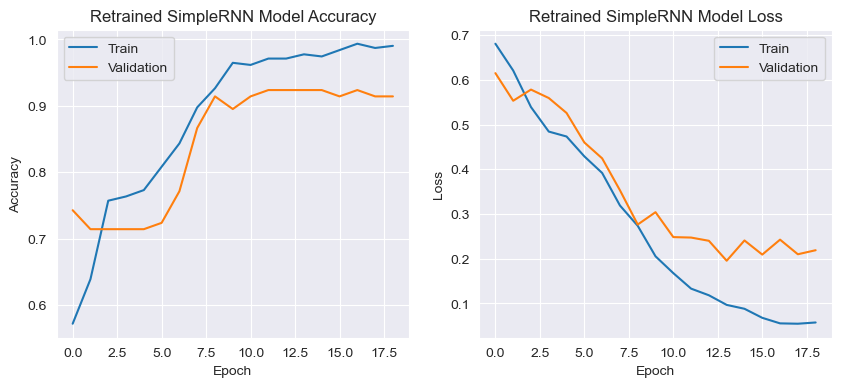

In [32]:
classification_tuned_RNN_model = Sequential()
classification_tuned_RNN_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))  # Adjust output_dim as needed
classification_tuned_RNN_model.add(SimpleRNN(units=random_search.best_params_['units'], dropout=random_search.best_params_['dropout'], recurrent_dropout=0.2))
classification_tuned_RNN_model.add(Dense(1, activation='sigmoid'))

classification_tuned_RNN_model.compile(optimizer=Adam(lr=random_search.best_params_['lr']), loss='binary_crossentropy', metrics=['accuracy'])
classification_tuned_RNN_model.summary()

history_classification_tuned_RNN_model = classification_tuned_RNN_model.fit(data_X_train, scores_y_train, validation_data=(data_X_val, scores_y_val), epochs=30, batch_size=32, callbacks = [early_stopping, best_tuned_RNN_model])

# Final evaluation of the model - Accuracy
scores = classification_tuned_RNN_model.evaluate(data_X_test, scores_y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

# Plot the accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Summarize history for accuracy
ax[0].plot(history_classification_tuned_RNN_model.history['accuracy'])
ax[0].plot(history_classification_tuned_RNN_model.history['val_accuracy'])
ax[0].set_title('Retrained SimpleRNN Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
ax[1].plot(history_classification_tuned_RNN_model.history['loss'])
ax[1].plot(history_classification_tuned_RNN_model.history['val_loss'])
ax[1].set_title('Retrained SimpleRNN Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

# Show the plot
plt.show()

From the cell output above, after running our SimpleRNN model again, the accuracy of SimpleRNN can be calculated using `.evaluate()`, where it has decrease from 90.48% to 87.62%, meaning that the model has not improved with the optimal parameters we got from the hyperparameter tuning.

___
# LSTM Model Improvement - Hyperparameter Tuning
___

In [33]:
# Define the function to create the LSTM model
def create_LSTM_model(units, dropout, lr, num_layers):
    LSTM_model = Sequential()
    LSTM_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    
    # Add the specified number of LSTM layers
    for i in range(num_layers):
        if i == num_layers - 1:  # Last layer
            LSTM_model.add(LSTM(units=units, dropout=dropout, recurrent_dropout=dropout))
        else:  # Intermediate layers
            LSTM_model.add(LSTM(units=units, dropout=dropout, recurrent_dropout=dropout, return_sequences=True))
    
    LSTM_model.add(Dense(1, activation='sigmoid'))
    LSTM_model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return LSTM_model

# Define the parameter grid
param_grid = {
    'units': [64, 128, 256],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01, 0.1],
    'num_layers': [1, 2, 3]  # Adding num_layers to the parameter grid
}

# Create the KerasClassifier
LSTM_model = KerasClassifier(build_fn=create_LSTM_model)

# Perform Randomized Search CV
random_search = RandomizedSearchCV(LSTM_model, param_grid, cv=5, scoring='accuracy', n_iter=10)
random_search.fit(data_X_train, scores_y_train, validation_data=(data_X_val, scores_y_val), epochs=30, batch_size=32, callbacks=[early_stopping])

# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# Evaluate the best model on the test data
best_model = random_search.best_estimator_.model
best_model.evaluate(data_X_test, scores_y_test)

C:\Users\angmi\AppData\Local\Temp\ipykernel_26320\1589492495.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  LSTM_model = KerasClassifier(build_fn=create_LSTM_model)


Epoch 1/30
8/8 [==============================] - 6s 383ms/step - loss: 0.6938 - accuracy: 0.6560 - val_loss: 0.6428 - val_accuracy: 0.6667
Epoch 2/30
8/8 [==============================] - 3s 317ms/step - loss: 0.5985 - accuracy: 0.7160 - val_loss: 0.7137 - val_accuracy: 0.3619
Epoch 3/30
8/8 [==============================] - 3s 353ms/step - loss: 0.6171 - accuracy: 0.7160 - val_loss: 0.6955 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 376ms/step - loss: 0.5816 - accuracy: 0.7280 - val_loss: 0.5953 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 3s 318ms/step - loss: 0.6110 - accuracy: 0.7240 - val_loss: 0.6188 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 3s 330ms/step - loss: 0.5801 - accuracy: 0.7280 - val_loss: 0.6722 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 3s 352ms/step - loss: 0.6359 - accuracy: 0.7320 - val_loss: 0.6002 - val_accuracy: 0.7143
Epoch 8/30
8/8 [====

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 403ms/step - loss: 0.7137 - accuracy: 0.6800 - val_loss: 0.7613 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 352ms/step - loss: 0.5949 - accuracy: 0.7600 - val_loss: 0.6080 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 354ms/step - loss: 0.5581 - accuracy: 0.7600 - val_loss: 0.6062 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 330ms/step - loss: 0.5528 - accuracy: 0.7600 - val_loss: 0.6015 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 3s 339ms/step - loss: 0.5556 - accuracy: 0.7600 - val_loss: 0.6065 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 3s 350ms/step - loss: 0.5609 - accuracy: 0.7600 - val_loss: 0.6028 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 3s 351ms/step - loss: 0.5821 - accuracy: 0.7600 - val_loss: 0.6097 - val_accuracy: 0.7143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 380ms/step - loss: 0.6313 - accuracy: 0.6440 - val_loss: 0.6460 - val_accuracy: 0.7333
Epoch 2/30
8/8 [==============================] - 3s 346ms/step - loss: 0.6045 - accuracy: 0.7160 - val_loss: 0.5998 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 365ms/step - loss: 0.6179 - accuracy: 0.7240 - val_loss: 0.6062 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 357ms/step - loss: 0.6014 - accuracy: 0.7240 - val_loss: 0.6361 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 3s 329ms/step - loss: 0.6133 - accuracy: 0.7240 - val_loss: 0.6167 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 3s 338ms/step - loss: 0.5949 - accuracy: 0.7240 - val_loss: 0.5875 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 3s 337ms/step - loss: 0.5791 - accuracy: 0.6920 - val_loss: 0.6430 - val_accuracy: 0.7905
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 379ms/step - loss: 0.9966 - accuracy: 0.5936 - val_loss: 0.6424 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 332ms/step - loss: 0.7204 - accuracy: 0.7052 - val_loss: 0.6298 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 325ms/step - loss: 0.5637 - accuracy: 0.7530 - val_loss: 0.5974 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 329ms/step - loss: 0.5651 - accuracy: 0.7530 - val_loss: 0.5971 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 3s 321ms/step - loss: 0.5520 - accuracy: 0.7530 - val_loss: 0.5875 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 2s 314ms/step - loss: 0.5179 - accuracy: 0.7530 - val_loss: 0.5048 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 2s 315ms/step - loss: 0.3518 - accuracy: 0.8247 - val_loss: 0.3427 - val_accuracy: 0.9048
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 369ms/step - loss: 1.3237 - accuracy: 0.5817 - val_loss: 0.6016 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 325ms/step - loss: 0.5971 - accuracy: 0.7371 - val_loss: 0.6223 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 2s 315ms/step - loss: 0.6036 - accuracy: 0.6932 - val_loss: 0.6532 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 334ms/step - loss: 0.5720 - accuracy: 0.7251 - val_loss: 0.5779 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 3s 338ms/step - loss: 0.5425 - accuracy: 0.7371 - val_loss: 0.5527 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 3s 328ms/step - loss: 0.4654 - accuracy: 0.7410 - val_loss: 0.4705 - val_accuracy: 0.8286
Epoch 7/30
8/8 [==============================] - 3s 337ms/step - loss: 0.3045 - accuracy: 0.9004 - val_loss: 0.3115 - val_accuracy: 0.9048
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 349ms/step - loss: 0.8481 - accuracy: 0.5960 - val_loss: 0.6175 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 2s 312ms/step - loss: 0.5896 - accuracy: 0.7320 - val_loss: 0.5894 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 2s 317ms/step - loss: 0.5263 - accuracy: 0.7320 - val_loss: 0.4703 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 2s 313ms/step - loss: 0.2881 - accuracy: 0.8680 - val_loss: 0.3153 - val_accuracy: 0.9048
Epoch 5/30
8/8 [==============================] - 3s 332ms/step - loss: 0.1277 - accuracy: 0.9720 - val_loss: 0.3073 - val_accuracy: 0.9143
Epoch 6/30
8/8 [==============================] - 3s 337ms/step - loss: 0.0579 - accuracy: 0.9880 - val_loss: 0.4917 - val_accuracy: 0.8952
Epoch 7/30
8/8 [==============================] - 3s 349ms/step - loss: 0.0580 - accuracy: 0.9880 - val_loss: 0.3247 - val_accuracy: 0.9048
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 376ms/step - loss: 0.7940 - accuracy: 0.5720 - val_loss: 0.6265 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 335ms/step - loss: 0.5607 - accuracy: 0.7600 - val_loss: 0.5910 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 323ms/step - loss: 0.5133 - accuracy: 0.7520 - val_loss: 0.4833 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 319ms/step - loss: 0.3130 - accuracy: 0.7880 - val_loss: 0.3436 - val_accuracy: 0.9143
Epoch 5/30
8/8 [==============================] - 3s 322ms/step - loss: 0.1392 - accuracy: 0.9640 - val_loss: 0.3182 - val_accuracy: 0.9048
Epoch 6/30
8/8 [==============================] - 3s 339ms/step - loss: 0.0991 - accuracy: 0.9640 - val_loss: 0.3274 - val_accuracy: 0.9143
Epoch 7/30
8/8 [==============================] - 3s 324ms/step - loss: 0.0846 - accuracy: 0.9760 - val_loss: 0.3258 - val_accuracy: 0.9143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 375ms/step - loss: 0.8508 - accuracy: 0.6360 - val_loss: 0.6053 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 324ms/step - loss: 0.5877 - accuracy: 0.7080 - val_loss: 0.5017 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 312ms/step - loss: 0.4019 - accuracy: 0.8240 - val_loss: 0.2823 - val_accuracy: 0.9238
Epoch 4/30
8/8 [==============================] - 2s 312ms/step - loss: 0.1454 - accuracy: 0.9480 - val_loss: 0.3109 - val_accuracy: 0.8857
Epoch 5/30
8/8 [==============================] - 3s 322ms/step - loss: 0.0891 - accuracy: 0.9560 - val_loss: 0.2797 - val_accuracy: 0.8857
Epoch 6/30
8/8 [==============================] - 2s 310ms/step - loss: 0.0390 - accuracy: 0.9800 - val_loss: 0.3104 - val_accuracy: 0.9238
Epoch 7/30
8/8 [==============================] - 3s 342ms/step - loss: 0.0333 - accuracy: 0.9880 - val_loss: 0.3548 - val_accuracy: 0.8952
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 365ms/step - loss: 0.6595 - accuracy: 0.7171 - val_loss: 0.5985 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 323ms/step - loss: 0.4081 - accuracy: 0.8247 - val_loss: 0.2352 - val_accuracy: 0.9048
Epoch 3/30
8/8 [==============================] - 3s 326ms/step - loss: 0.1664 - accuracy: 0.9402 - val_loss: 0.2374 - val_accuracy: 0.8952
Epoch 4/30
8/8 [==============================] - 3s 316ms/step - loss: 0.0894 - accuracy: 0.9721 - val_loss: 0.2138 - val_accuracy: 0.9333
Epoch 5/30
8/8 [==============================] - 2s 308ms/step - loss: 0.0488 - accuracy: 0.9920 - val_loss: 0.2631 - val_accuracy: 0.9333
Epoch 6/30
8/8 [==============================] - 3s 325ms/step - loss: 0.0355 - accuracy: 0.9880 - val_loss: 0.2690 - val_accuracy: 0.9238
Epoch 7/30
8/8 [==============================] - 3s 322ms/step - loss: 0.0650 - accuracy: 0.9641 - val_loss: 0.2826 - val_accuracy: 0.9238
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 407ms/step - loss: 0.6573 - accuracy: 0.7092 - val_loss: 0.5669 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 324ms/step - loss: 0.4782 - accuracy: 0.8008 - val_loss: 0.3448 - val_accuracy: 0.8381
Epoch 3/30
8/8 [==============================] - 2s 310ms/step - loss: 0.2367 - accuracy: 0.9283 - val_loss: 0.2029 - val_accuracy: 0.9429
Epoch 4/30
8/8 [==============================] - 3s 326ms/step - loss: 0.0936 - accuracy: 0.9801 - val_loss: 0.1639 - val_accuracy: 0.9429
Epoch 5/30
8/8 [==============================] - 3s 324ms/step - loss: 0.0433 - accuracy: 0.9880 - val_loss: 0.2541 - val_accuracy: 0.9429
Epoch 6/30
8/8 [==============================] - 3s 317ms/step - loss: 0.0293 - accuracy: 0.9880 - val_loss: 0.1746 - val_accuracy: 0.9333
Epoch 7/30
8/8 [==============================] - 3s 357ms/step - loss: 0.0302 - accuracy: 0.9920 - val_loss: 0.2822 - val_accuracy: 0.9048
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 5s 490ms/step - loss: 0.6699 - accuracy: 0.6960 - val_loss: 0.6360 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 527ms/step - loss: 0.5957 - accuracy: 0.7320 - val_loss: 0.6335 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 5s 610ms/step - loss: 0.5628 - accuracy: 0.7320 - val_loss: 0.5518 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 5s 662ms/step - loss: 0.5063 - accuracy: 0.7320 - val_loss: 0.5081 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 5s 680ms/step - loss: 0.4428 - accuracy: 0.7320 - val_loss: 0.4564 - val_accuracy: 0.7333
Epoch 6/30
8/8 [==============================] - 5s 571ms/step - loss: 0.3633 - accuracy: 0.8040 - val_loss: 0.3821 - val_accuracy: 0.8095
Epoch 7/30
8/8 [==============================] - 5s 616ms/step - loss: 0.2784 - accuracy: 0.8720 - val_loss: 0.3324 - val_accuracy: 0.8381
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
8/8 [==============================] - 8s 215ms/step - loss: 0.6670 - accuracy: 0.7000 - val_loss: 0.6345 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 167ms/step - loss: 0.5852 - accuracy: 0.7600 - val_loss: 0.6321 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 163ms/step - loss: 0.5460 - accuracy: 0.7600 - val_loss: 0.5560 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 158ms/step - loss: 0.5011 - accuracy: 0.7600 - val_loss: 0.5212 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 167ms/step - loss: 0.4524 - accuracy: 0.7600 - val_loss: 0.4806 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 162ms/step - loss: 0.3865 - accuracy: 0.7680 - val_loss: 0.3971 - val_accuracy: 0.7714
Epoch 7/30
8/8 [==============================] - 1s 166ms/step - loss: 0.3077 - accuracy: 0.8280 - val_loss: 0.3360 - val_accuracy: 0.8190
Epoch 8/30
8/8 [====

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 195ms/step - loss: 0.6682 - accuracy: 0.6920 - val_loss: 0.6347 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 164ms/step - loss: 0.5979 - accuracy: 0.7240 - val_loss: 0.5871 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 159ms/step - loss: 0.5546 - accuracy: 0.7240 - val_loss: 0.5424 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 164ms/step - loss: 0.5051 - accuracy: 0.7240 - val_loss: 0.4941 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 171ms/step - loss: 0.4319 - accuracy: 0.7360 - val_loss: 0.4305 - val_accuracy: 0.7333
Epoch 6/30
8/8 [==============================] - 1s 173ms/step - loss: 0.3337 - accuracy: 0.8200 - val_loss: 0.3465 - val_accuracy: 0.8095
Epoch 7/30
8/8 [==============================] - 1s 164ms/step - loss: 0.2494 - accuracy: 0.9000 - val_loss: 0.2894 - val_accuracy: 0.8952
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 196ms/step - loss: 0.6743 - accuracy: 0.6813 - val_loss: 0.6413 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 175ms/step - loss: 0.5903 - accuracy: 0.7530 - val_loss: 0.5950 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 157ms/step - loss: 0.5372 - accuracy: 0.7530 - val_loss: 0.5480 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 174ms/step - loss: 0.4870 - accuracy: 0.7530 - val_loss: 0.5020 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 167ms/step - loss: 0.4283 - accuracy: 0.7570 - val_loss: 0.4416 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 1s 163ms/step - loss: 0.3515 - accuracy: 0.8008 - val_loss: 0.3681 - val_accuracy: 0.8190
Epoch 7/30
8/8 [==============================] - 1s 168ms/step - loss: 0.2839 - accuracy: 0.9004 - val_loss: 0.3112 - val_accuracy: 0.8667
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 193ms/step - loss: 0.6712 - accuracy: 0.7131 - val_loss: 0.6330 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 160ms/step - loss: 0.5916 - accuracy: 0.7371 - val_loss: 0.5895 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 161ms/step - loss: 0.5430 - accuracy: 0.7371 - val_loss: 0.5443 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 1s 164ms/step - loss: 0.4924 - accuracy: 0.7371 - val_loss: 0.4984 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 1s 168ms/step - loss: 0.4231 - accuracy: 0.7570 - val_loss: 0.4246 - val_accuracy: 0.7429
Epoch 6/30
8/8 [==============================] - 1s 166ms/step - loss: 0.3360 - accuracy: 0.8327 - val_loss: 0.3564 - val_accuracy: 0.8190
Epoch 7/30
8/8 [==============================] - 1s 163ms/step - loss: 0.2673 - accuracy: 0.9124 - val_loss: 0.3029 - val_accuracy: 0.8667
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 346ms/step - loss: 1.0690 - accuracy: 0.6320 - val_loss: 0.5300 - val_accuracy: 0.8190
Epoch 2/30
8/8 [==============================] - 2s 306ms/step - loss: 0.5756 - accuracy: 0.8200 - val_loss: 0.5251 - val_accuracy: 0.8286
Epoch 3/30
8/8 [==============================] - 2s 307ms/step - loss: 0.2946 - accuracy: 0.9000 - val_loss: 0.6259 - val_accuracy: 0.8190
Epoch 4/30
8/8 [==============================] - 3s 327ms/step - loss: 0.2207 - accuracy: 0.9160 - val_loss: 0.6501 - val_accuracy: 0.8286
Epoch 5/30
8/8 [==============================] - 2s 305ms/step - loss: 0.1177 - accuracy: 0.9520 - val_loss: 0.6260 - val_accuracy: 0.8476
Epoch 6/30
8/8 [==============================] - 2s 311ms/step - loss: 0.2049 - accuracy: 0.9200 - val_loss: 0.5096 - val_accuracy: 0.8762
Epoch 7/30
8/8 [==============================] - 2s 304ms/step - loss: 0.1372 - accuracy: 0.9560 - val_loss: 0.5816 - val_accuracy: 0.8762
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 351ms/step - loss: 0.8131 - accuracy: 0.6280 - val_loss: 1.0897 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 2s 307ms/step - loss: 0.7146 - accuracy: 0.6960 - val_loss: 0.7218 - val_accuracy: 0.7333
Epoch 3/30
8/8 [==============================] - 3s 321ms/step - loss: 0.4997 - accuracy: 0.8200 - val_loss: 0.5962 - val_accuracy: 0.7905
Epoch 4/30
8/8 [==============================] - 3s 329ms/step - loss: 0.3422 - accuracy: 0.8720 - val_loss: 0.4217 - val_accuracy: 0.8095
Epoch 5/30
8/8 [==============================] - 3s 333ms/step - loss: 0.2193 - accuracy: 0.9160 - val_loss: 0.4126 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 3s 317ms/step - loss: 0.2049 - accuracy: 0.9160 - val_loss: 0.3727 - val_accuracy: 0.9143
Epoch 7/30
8/8 [==============================] - 3s 331ms/step - loss: 0.1201 - accuracy: 0.9600 - val_loss: 0.4333 - val_accuracy: 0.8952
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 370ms/step - loss: 0.9937 - accuracy: 0.6320 - val_loss: 0.6169 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 324ms/step - loss: 0.5792 - accuracy: 0.7240 - val_loss: 0.5436 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 325ms/step - loss: 0.4397 - accuracy: 0.8040 - val_loss: 0.3567 - val_accuracy: 0.9048
Epoch 4/30
8/8 [==============================] - 2s 313ms/step - loss: 0.2156 - accuracy: 0.9480 - val_loss: 0.4143 - val_accuracy: 0.9048
Epoch 5/30
8/8 [==============================] - 2s 307ms/step - loss: 0.1033 - accuracy: 0.9560 - val_loss: 0.3532 - val_accuracy: 0.9048
Epoch 6/30
8/8 [==============================] - 3s 317ms/step - loss: 0.0817 - accuracy: 0.9800 - val_loss: 0.3325 - val_accuracy: 0.9048
Epoch 7/30
8/8 [==============================] - 3s 329ms/step - loss: 0.0800 - accuracy: 0.9760 - val_loss: 0.4968 - val_accuracy: 0.8952
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 355ms/step - loss: 1.1573 - accuracy: 0.6096 - val_loss: 0.8121 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 337ms/step - loss: 0.6065 - accuracy: 0.7530 - val_loss: 0.6300 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 321ms/step - loss: 0.5845 - accuracy: 0.7530 - val_loss: 0.5983 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 328ms/step - loss: 0.5819 - accuracy: 0.7530 - val_loss: 0.6125 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 2s 317ms/step - loss: 0.5981 - accuracy: 0.7530 - val_loss: 0.6377 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 2s 304ms/step - loss: 0.6011 - accuracy: 0.7530 - val_loss: 0.6138 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 3s 328ms/step - loss: 0.5825 - accuracy: 0.7530 - val_loss: 0.8559 - val_accuracy: 0.7143
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 368ms/step - loss: 0.7859 - accuracy: 0.6295 - val_loss: 0.6683 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 333ms/step - loss: 0.5970 - accuracy: 0.7371 - val_loss: 0.5983 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 2s 310ms/step - loss: 0.5710 - accuracy: 0.7371 - val_loss: 0.5164 - val_accuracy: 0.7714
Epoch 4/30
8/8 [==============================] - 3s 326ms/step - loss: 0.4476 - accuracy: 0.8167 - val_loss: 0.3539 - val_accuracy: 0.8762
Epoch 5/30
8/8 [==============================] - 2s 312ms/step - loss: 0.2807 - accuracy: 0.9124 - val_loss: 0.3549 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 3s 320ms/step - loss: 0.2051 - accuracy: 0.9442 - val_loss: 0.3185 - val_accuracy: 0.8857
Epoch 7/30
8/8 [==============================] - 3s 334ms/step - loss: 0.1219 - accuracy: 0.9641 - val_loss: 0.2777 - val_accuracy: 0.8952
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 206ms/step - loss: 0.9191 - accuracy: 0.5520 - val_loss: 0.5893 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 166ms/step - loss: 0.5065 - accuracy: 0.7320 - val_loss: 0.4626 - val_accuracy: 0.7619
Epoch 3/30
8/8 [==============================] - 1s 168ms/step - loss: 0.2815 - accuracy: 0.9120 - val_loss: 0.3999 - val_accuracy: 0.8667
Epoch 4/30
8/8 [==============================] - 1s 163ms/step - loss: 0.1256 - accuracy: 0.9640 - val_loss: 0.4735 - val_accuracy: 0.8476
Epoch 5/30
8/8 [==============================] - 1s 171ms/step - loss: 0.0718 - accuracy: 0.9680 - val_loss: 0.5561 - val_accuracy: 0.8190
Epoch 6/30
8/8 [==============================] - 1s 178ms/step - loss: 0.0413 - accuracy: 0.9880 - val_loss: 0.6373 - val_accuracy: 0.8095
Epoch 7/30
8/8 [==============================] - 1s 190ms/step - loss: 0.0209 - accuracy: 0.9960 - val_loss: 0.6408 - val_accuracy: 0.8571
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 209ms/step - loss: 0.9963 - accuracy: 0.6880 - val_loss: 0.5632 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 167ms/step - loss: 0.4726 - accuracy: 0.7600 - val_loss: 0.4727 - val_accuracy: 0.7524
Epoch 3/30
8/8 [==============================] - 1s 166ms/step - loss: 0.2708 - accuracy: 0.8720 - val_loss: 0.4152 - val_accuracy: 0.8857
Epoch 4/30
8/8 [==============================] - 1s 169ms/step - loss: 0.1391 - accuracy: 0.9520 - val_loss: 0.4936 - val_accuracy: 0.8190
Epoch 5/30
8/8 [==============================] - 1s 165ms/step - loss: 0.0853 - accuracy: 0.9640 - val_loss: 0.5691 - val_accuracy: 0.8381
Epoch 6/30
8/8 [==============================] - 1s 176ms/step - loss: 0.0590 - accuracy: 0.9800 - val_loss: 0.6235 - val_accuracy: 0.8190
Epoch 7/30
8/8 [==============================] - 1s 178ms/step - loss: 0.0413 - accuracy: 0.9880 - val_loss: 0.6512 - val_accuracy: 0.8476
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 193ms/step - loss: 1.0506 - accuracy: 0.5400 - val_loss: 0.5874 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 163ms/step - loss: 0.5460 - accuracy: 0.7240 - val_loss: 0.4811 - val_accuracy: 0.7238
Epoch 3/30
8/8 [==============================] - 1s 175ms/step - loss: 0.3663 - accuracy: 0.8920 - val_loss: 0.3558 - val_accuracy: 0.8857
Epoch 4/30
8/8 [==============================] - 1s 172ms/step - loss: 0.1384 - accuracy: 0.9640 - val_loss: 0.3754 - val_accuracy: 0.8476
Epoch 5/30
8/8 [==============================] - 1s 169ms/step - loss: 0.0765 - accuracy: 0.9640 - val_loss: 0.4061 - val_accuracy: 0.8667
Epoch 6/30
8/8 [==============================] - 1s 167ms/step - loss: 0.0442 - accuracy: 0.9840 - val_loss: 0.4895 - val_accuracy: 0.8476
Epoch 7/30
8/8 [==============================] - 1s 157ms/step - loss: 0.0331 - accuracy: 0.9880 - val_loss: 0.5051 - val_accuracy: 0.8857
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 4s 198ms/step - loss: 1.0150 - accuracy: 0.6056 - val_loss: 0.6293 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 161ms/step - loss: 0.5443 - accuracy: 0.7171 - val_loss: 0.4624 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 1s 164ms/step - loss: 0.3418 - accuracy: 0.7968 - val_loss: 0.3430 - val_accuracy: 0.9048
Epoch 4/30
8/8 [==============================] - 1s 160ms/step - loss: 0.1581 - accuracy: 0.9681 - val_loss: 0.2944 - val_accuracy: 0.8857
Epoch 5/30
8/8 [==============================] - 1s 162ms/step - loss: 0.0915 - accuracy: 0.9681 - val_loss: 0.3044 - val_accuracy: 0.9048
Epoch 6/30
8/8 [==============================] - 1s 156ms/step - loss: 0.0802 - accuracy: 0.9641 - val_loss: 0.3184 - val_accuracy: 0.8857
Epoch 7/30
8/8 [==============================] - 1s 159ms/step - loss: 0.0542 - accuracy: 0.9721 - val_loss: 0.3271 - val_accuracy: 0.9238
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 190ms/step - loss: 1.1113 - accuracy: 0.6972 - val_loss: 0.5787 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 1s 161ms/step - loss: 0.4476 - accuracy: 0.7729 - val_loss: 0.3544 - val_accuracy: 0.8952
Epoch 3/30
8/8 [==============================] - 1s 163ms/step - loss: 0.1890 - accuracy: 0.9602 - val_loss: 0.2336 - val_accuracy: 0.9238
Epoch 4/30
8/8 [==============================] - 1s 164ms/step - loss: 0.0654 - accuracy: 0.9801 - val_loss: 0.2749 - val_accuracy: 0.9048
Epoch 5/30
8/8 [==============================] - 1s 159ms/step - loss: 0.0571 - accuracy: 0.9880 - val_loss: 0.3045 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 2s 192ms/step - loss: 0.0524 - accuracy: 0.9761 - val_loss: 0.3239 - val_accuracy: 0.9048
Epoch 7/30
8/8 [==============================] - 1s 175ms/step - loss: 0.0469 - accuracy: 0.9721 - val_loss: 0.3004 - val_accuracy: 0.9048
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 365ms/step - loss: 0.6819 - accuracy: 0.6280 - val_loss: 0.5908 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 2s 310ms/step - loss: 0.5961 - accuracy: 0.7320 - val_loss: 0.5455 - val_accuracy: 0.7429
Epoch 3/30
8/8 [==============================] - 2s 307ms/step - loss: 0.5123 - accuracy: 0.7880 - val_loss: 0.5579 - val_accuracy: 0.7714
Epoch 4/30
8/8 [==============================] - 2s 312ms/step - loss: 0.3510 - accuracy: 0.8240 - val_loss: 0.4091 - val_accuracy: 0.8286
Epoch 5/30
8/8 [==============================] - 3s 325ms/step - loss: 0.2212 - accuracy: 0.9120 - val_loss: 0.3985 - val_accuracy: 0.8857
Epoch 6/30
8/8 [==============================] - 3s 328ms/step - loss: 0.1408 - accuracy: 0.9320 - val_loss: 0.3568 - val_accuracy: 0.8857
Epoch 7/30
8/8 [==============================] - 3s 335ms/step - loss: 0.0830 - accuracy: 0.9680 - val_loss: 0.3724 - val_accuracy: 0.8857
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 376ms/step - loss: 0.6483 - accuracy: 0.6360 - val_loss: 0.6176 - val_accuracy: 0.7238
Epoch 2/30
8/8 [==============================] - 3s 335ms/step - loss: 0.5028 - accuracy: 0.7880 - val_loss: 0.5365 - val_accuracy: 0.7238
Epoch 3/30
8/8 [==============================] - 3s 337ms/step - loss: 0.3963 - accuracy: 0.8440 - val_loss: 0.4403 - val_accuracy: 0.8762
Epoch 4/30
8/8 [==============================] - 3s 328ms/step - loss: 0.3980 - accuracy: 0.8480 - val_loss: 0.3481 - val_accuracy: 0.8952
Epoch 5/30
8/8 [==============================] - 3s 316ms/step - loss: 0.1888 - accuracy: 0.9320 - val_loss: 0.3633 - val_accuracy: 0.9048
Epoch 6/30
8/8 [==============================] - 3s 342ms/step - loss: 0.1585 - accuracy: 0.9480 - val_loss: 0.3129 - val_accuracy: 0.9143
Epoch 7/30
8/8 [==============================] - 3s 334ms/step - loss: 0.1237 - accuracy: 0.9560 - val_loss: 0.2474 - val_accuracy: 0.9238
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 387ms/step - loss: 0.8583 - accuracy: 0.6000 - val_loss: 0.7172 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 316ms/step - loss: 0.5640 - accuracy: 0.7280 - val_loss: 0.4361 - val_accuracy: 0.8381
Epoch 3/30
8/8 [==============================] - 2s 311ms/step - loss: 0.2757 - accuracy: 0.8960 - val_loss: 0.3452 - val_accuracy: 0.8571
Epoch 4/30
8/8 [==============================] - 3s 330ms/step - loss: 0.1476 - accuracy: 0.9560 - val_loss: 0.3621 - val_accuracy: 0.8667
Epoch 5/30
8/8 [==============================] - 3s 325ms/step - loss: 0.1404 - accuracy: 0.9480 - val_loss: 0.3105 - val_accuracy: 0.8857
Epoch 6/30
8/8 [==============================] - 3s 326ms/step - loss: 0.0907 - accuracy: 0.9760 - val_loss: 0.3411 - val_accuracy: 0.8762
Epoch 7/30
8/8 [==============================] - 3s 312ms/step - loss: 0.0879 - accuracy: 0.9720 - val_loss: 0.4235 - val_accuracy: 0.8667
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 422ms/step - loss: 0.9082 - accuracy: 0.6295 - val_loss: 0.6494 - val_accuracy: 0.6190
Epoch 2/30
8/8 [==============================] - 3s 366ms/step - loss: 0.5901 - accuracy: 0.6932 - val_loss: 0.6057 - val_accuracy: 0.7238
Epoch 3/30
8/8 [==============================] - 3s 348ms/step - loss: 0.4807 - accuracy: 0.8167 - val_loss: 0.4712 - val_accuracy: 0.7714
Epoch 4/30
8/8 [==============================] - 3s 336ms/step - loss: 0.3125 - accuracy: 0.8845 - val_loss: 0.4216 - val_accuracy: 0.8190
Epoch 5/30
8/8 [==============================] - 3s 326ms/step - loss: 0.2115 - accuracy: 0.9044 - val_loss: 0.4264 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 3s 318ms/step - loss: 0.1814 - accuracy: 0.9243 - val_loss: 0.3960 - val_accuracy: 0.8952
Epoch 7/30
8/8 [==============================] - 3s 317ms/step - loss: 0.1403 - accuracy: 0.9442 - val_loss: 0.4308 - val_accuracy: 0.8190
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 361ms/step - loss: 0.8605 - accuracy: 0.6693 - val_loss: 0.5643 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 324ms/step - loss: 0.3377 - accuracy: 0.8725 - val_loss: 0.2990 - val_accuracy: 0.9048
Epoch 3/30
8/8 [==============================] - 3s 319ms/step - loss: 0.1603 - accuracy: 0.9602 - val_loss: 0.2988 - val_accuracy: 0.9238
Epoch 4/30
8/8 [==============================] - 3s 322ms/step - loss: 0.1067 - accuracy: 0.9721 - val_loss: 0.2450 - val_accuracy: 0.9429
Epoch 5/30
8/8 [==============================] - 3s 331ms/step - loss: 0.0797 - accuracy: 0.9801 - val_loss: 0.2641 - val_accuracy: 0.9333
Epoch 6/30
8/8 [==============================] - 3s 331ms/step - loss: 0.0820 - accuracy: 0.9761 - val_loss: 0.3223 - val_accuracy: 0.9333
Epoch 7/30
8/8 [==============================] - 3s 323ms/step - loss: 0.0563 - accuracy: 0.9841 - val_loss: 0.3115 - val_accuracy: 0.9333
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 365ms/step - loss: 1.1576 - accuracy: 0.6480 - val_loss: 0.7136 - val_accuracy: 0.6667
Epoch 2/30
8/8 [==============================] - 3s 328ms/step - loss: 0.7149 - accuracy: 0.7200 - val_loss: 0.6106 - val_accuracy: 0.6952
Epoch 3/30
8/8 [==============================] - 3s 343ms/step - loss: 0.6275 - accuracy: 0.6920 - val_loss: 0.6199 - val_accuracy: 0.7238
Epoch 4/30
8/8 [==============================] - 3s 347ms/step - loss: 0.5444 - accuracy: 0.7520 - val_loss: 0.5161 - val_accuracy: 0.7714
Epoch 5/30
8/8 [==============================] - 3s 334ms/step - loss: 0.5328 - accuracy: 0.7880 - val_loss: 0.4173 - val_accuracy: 0.8095
Epoch 6/30
8/8 [==============================] - 3s 315ms/step - loss: 0.4407 - accuracy: 0.7920 - val_loss: 0.4947 - val_accuracy: 0.7429
Epoch 7/30
8/8 [==============================] - 3s 336ms/step - loss: 0.4722 - accuracy: 0.8200 - val_loss: 0.4590 - val_accuracy: 0.7905
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 358ms/step - loss: 1.0120 - accuracy: 0.5960 - val_loss: 0.7811 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 315ms/step - loss: 0.6127 - accuracy: 0.7280 - val_loss: 0.6067 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 322ms/step - loss: 0.5396 - accuracy: 0.7600 - val_loss: 0.6472 - val_accuracy: 0.7238
Epoch 4/30
8/8 [==============================] - 3s 321ms/step - loss: 0.4506 - accuracy: 0.8120 - val_loss: 0.6055 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 3s 315ms/step - loss: 0.4686 - accuracy: 0.7840 - val_loss: 0.6338 - val_accuracy: 0.7238
Epoch 6/30
8/8 [==============================] - 2s 309ms/step - loss: 0.3923 - accuracy: 0.8600 - val_loss: 0.5822 - val_accuracy: 0.7714
Epoch 7/30
8/8 [==============================] - 3s 322ms/step - loss: 0.3777 - accuracy: 0.8880 - val_loss: 1.1775 - val_accuracy: 0.5810
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 380ms/step - loss: 0.8868 - accuracy: 0.6360 - val_loss: 0.6100 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 2s 309ms/step - loss: 0.5768 - accuracy: 0.7280 - val_loss: 0.5010 - val_accuracy: 0.8095
Epoch 3/30
8/8 [==============================] - 3s 326ms/step - loss: 0.3347 - accuracy: 0.9000 - val_loss: 0.3243 - val_accuracy: 0.8762
Epoch 4/30
8/8 [==============================] - 3s 327ms/step - loss: 0.1460 - accuracy: 0.9680 - val_loss: 0.4745 - val_accuracy: 0.8762
Epoch 5/30
8/8 [==============================] - 3s 345ms/step - loss: 0.1318 - accuracy: 0.9680 - val_loss: 0.5292 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 3s 332ms/step - loss: 0.1042 - accuracy: 0.9720 - val_loss: 0.4673 - val_accuracy: 0.8571
Epoch 7/30
8/8 [==============================] - 3s 346ms/step - loss: 0.0930 - accuracy: 0.9760 - val_loss: 0.4823 - val_accuracy: 0.8952
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 362ms/step - loss: 1.3438 - accuracy: 0.6096 - val_loss: 0.6785 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 324ms/step - loss: 0.7478 - accuracy: 0.6773 - val_loss: 0.8089 - val_accuracy: 0.2857
Epoch 3/30
8/8 [==============================] - 2s 318ms/step - loss: 0.6984 - accuracy: 0.6892 - val_loss: 0.6960 - val_accuracy: 0.2857
Epoch 4/30
8/8 [==============================] - 3s 329ms/step - loss: 0.6573 - accuracy: 0.6574 - val_loss: 0.6139 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 3s 351ms/step - loss: 0.6010 - accuracy: 0.7530 - val_loss: 0.6071 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 3s 343ms/step - loss: 0.6324 - accuracy: 0.7331 - val_loss: 0.7208 - val_accuracy: 0.6000
Epoch 7/30
8/8 [==============================] - 2s 306ms/step - loss: 0.6098 - accuracy: 0.6892 - val_loss: 0.7875 - val_accuracy: 0.7143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 353ms/step - loss: 0.7090 - accuracy: 0.6494 - val_loss: 0.6076 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 328ms/step - loss: 0.6093 - accuracy: 0.7371 - val_loss: 0.5980 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 341ms/step - loss: 0.5837 - accuracy: 0.7371 - val_loss: 0.5983 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 316ms/step - loss: 0.5828 - accuracy: 0.7371 - val_loss: 0.6031 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 3s 318ms/step - loss: 0.5792 - accuracy: 0.7371 - val_loss: 0.6057 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 3s 318ms/step - loss: 0.5838 - accuracy: 0.7371 - val_loss: 0.6055 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 3s 351ms/step - loss: 0.6372 - accuracy: 0.7251 - val_loss: 0.4868 - val_accuracy: 0.7143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 583ms/step - loss: 1.4552 - accuracy: 0.5880 - val_loss: 1.0053 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 520ms/step - loss: 0.7999 - accuracy: 0.6280 - val_loss: 0.6165 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 529ms/step - loss: 0.6356 - accuracy: 0.7320 - val_loss: 0.6587 - val_accuracy: 0.7048
Epoch 4/30
8/8 [==============================] - 4s 512ms/step - loss: 0.6349 - accuracy: 0.6920 - val_loss: 0.7062 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 4s 493ms/step - loss: 0.7037 - accuracy: 0.6680 - val_loss: 0.7682 - val_accuracy: 0.2857
Epoch 6/30
8/8 [==============================] - 4s 525ms/step - loss: 0.6345 - accuracy: 0.6720 - val_loss: 0.7844 - val_accuracy: 0.7143
Epoch 7/30
2/2 [==============================] - 0s 48ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 591ms/step - loss: 1.2577 - accuracy: 0.6520 - val_loss: 1.2424 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 513ms/step - loss: 0.6628 - accuracy: 0.7560 - val_loss: 0.5986 - val_accuracy: 0.7048
Epoch 3/30
8/8 [==============================] - 4s 487ms/step - loss: 0.6295 - accuracy: 0.7360 - val_loss: 0.5425 - val_accuracy: 0.7429
Epoch 4/30
8/8 [==============================] - 4s 480ms/step - loss: 0.6228 - accuracy: 0.7600 - val_loss: 0.5319 - val_accuracy: 0.7429
Epoch 5/30
8/8 [==============================] - 4s 522ms/step - loss: 0.6147 - accuracy: 0.7560 - val_loss: 0.6705 - val_accuracy: 0.6476
Epoch 6/30
8/8 [==============================] - 4s 501ms/step - loss: 0.5941 - accuracy: 0.7360 - val_loss: 0.6208 - val_accuracy: 0.7048
Epoch 7/30
8/8 [==============================] - 4s 497ms/step - loss: 0.6700 - accuracy: 0.6800 - val_loss: 0.7272 - val_accuracy: 0.7048
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 574ms/step - loss: 1.6645 - accuracy: 0.6120 - val_loss: 1.6489 - val_accuracy: 0.3143
Epoch 2/30
8/8 [==============================] - 4s 498ms/step - loss: 0.6690 - accuracy: 0.6920 - val_loss: 0.5919 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 503ms/step - loss: 0.6554 - accuracy: 0.6800 - val_loss: 0.5860 - val_accuracy: 0.6952
Epoch 4/30
8/8 [==============================] - 4s 482ms/step - loss: 0.6451 - accuracy: 0.6680 - val_loss: 0.6005 - val_accuracy: 0.6762
Epoch 5/30
8/8 [==============================] - 4s 490ms/step - loss: 0.5954 - accuracy: 0.7080 - val_loss: 0.7019 - val_accuracy: 0.6571
Epoch 6/30
8/8 [==============================] - 4s 503ms/step - loss: 0.6679 - accuracy: 0.7080 - val_loss: 0.9867 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 4s 492ms/step - loss: 0.6383 - accuracy: 0.7080 - val_loss: 0.6949 - val_accuracy: 0.7048
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 585ms/step - loss: 2.0275 - accuracy: 0.5936 - val_loss: 1.4869 - val_accuracy: 0.7238
Epoch 2/30
8/8 [==============================] - 4s 504ms/step - loss: 0.8843 - accuracy: 0.6534 - val_loss: 0.6913 - val_accuracy: 0.7048
Epoch 3/30
8/8 [==============================] - 4s 497ms/step - loss: 0.6892 - accuracy: 0.7251 - val_loss: 0.7246 - val_accuracy: 0.3905
Epoch 4/30
8/8 [==============================] - 4s 502ms/step - loss: 0.6918 - accuracy: 0.6574 - val_loss: 0.7327 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 4s 483ms/step - loss: 0.6868 - accuracy: 0.6932 - val_loss: 0.7643 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 4s 512ms/step - loss: 0.6361 - accuracy: 0.7450 - val_loss: 0.5824 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 4s 525ms/step - loss: 0.5756 - accuracy: 0.7331 - val_loss: 0.7259 - val_accuracy: 0.7143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 567ms/step - loss: 2.0619 - accuracy: 0.5777 - val_loss: 0.6172 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 499ms/step - loss: 0.7043 - accuracy: 0.6175 - val_loss: 0.5809 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 509ms/step - loss: 0.6479 - accuracy: 0.6932 - val_loss: 0.7408 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 526ms/step - loss: 0.6314 - accuracy: 0.7371 - val_loss: 0.5504 - val_accuracy: 0.7524
Epoch 5/30
8/8 [==============================] - 4s 501ms/step - loss: 0.6292 - accuracy: 0.7052 - val_loss: 0.6384 - val_accuracy: 0.7333
Epoch 6/30
8/8 [==============================] - 4s 500ms/step - loss: 0.6063 - accuracy: 0.7610 - val_loss: 0.6463 - val_accuracy: 0.6190
Epoch 7/30
8/8 [==============================] - 4s 491ms/step - loss: 0.5376 - accuracy: 0.7689 - val_loss: 0.6898 - val_accuracy: 0.7333
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 567ms/step - loss: 1.0176 - accuracy: 0.5080 - val_loss: 0.6192 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 487ms/step - loss: 0.6000 - accuracy: 0.7320 - val_loss: 0.6016 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 510ms/step - loss: 0.5925 - accuracy: 0.7320 - val_loss: 0.6001 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 505ms/step - loss: 0.5850 - accuracy: 0.7320 - val_loss: 0.6040 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 4s 492ms/step - loss: 0.5837 - accuracy: 0.7320 - val_loss: 0.5985 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 4s 537ms/step - loss: 0.5892 - accuracy: 0.7320 - val_loss: 0.5983 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 4s 506ms/step - loss: 0.5984 - accuracy: 0.7320 - val_loss: 0.6084 - val_accuracy: 0.7143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 572ms/step - loss: 0.6211 - accuracy: 0.6720 - val_loss: 0.8431 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 490ms/step - loss: 0.6094 - accuracy: 0.7600 - val_loss: 0.9374 - val_accuracy: 0.3238
Epoch 3/30
8/8 [==============================] - 4s 510ms/step - loss: 0.6170 - accuracy: 0.6840 - val_loss: 0.6010 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 525ms/step - loss: 0.5528 - accuracy: 0.7600 - val_loss: 0.6054 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 4s 531ms/step - loss: 0.5550 - accuracy: 0.7600 - val_loss: 0.5953 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 4s 489ms/step - loss: 0.5438 - accuracy: 0.7600 - val_loss: 0.6273 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 4s 506ms/step - loss: 0.5427 - accuracy: 0.7600 - val_loss: 0.5690 - val_accuracy: 0.7143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 567ms/step - loss: 0.7163 - accuracy: 0.7000 - val_loss: 0.8506 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 494ms/step - loss: 0.6265 - accuracy: 0.7160 - val_loss: 0.6411 - val_accuracy: 0.6952
Epoch 3/30
8/8 [==============================] - 4s 512ms/step - loss: 0.6175 - accuracy: 0.7240 - val_loss: 0.5994 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 497ms/step - loss: 0.5916 - accuracy: 0.7240 - val_loss: 0.6560 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 4s 496ms/step - loss: 0.6131 - accuracy: 0.7240 - val_loss: 0.6113 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 4s 503ms/step - loss: 0.5948 - accuracy: 0.7240 - val_loss: 0.6042 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 4s 541ms/step - loss: 0.6190 - accuracy: 0.7240 - val_loss: 0.6084 - val_accuracy: 0.7143
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 563ms/step - loss: 1.1247 - accuracy: 0.6056 - val_loss: 0.6370 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 6s 604ms/step - loss: 0.6060 - accuracy: 0.7331 - val_loss: 0.6039 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 5s 686ms/step - loss: 0.6067 - accuracy: 0.7291 - val_loss: 0.6142 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 5s 626ms/step - loss: 0.5729 - accuracy: 0.7530 - val_loss: 0.6053 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 5s 565ms/step - loss: 0.5685 - accuracy: 0.7530 - val_loss: 0.6175 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 5s 569ms/step - loss: 0.5592 - accuracy: 0.7530 - val_loss: 0.6272 - val_accuracy: 0.7143
Epoch 7/30
2/2 [==============================] - 0s 48ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 10s 582ms/step - loss: 0.7640 - accuracy: 0.6813 - val_loss: 0.5985 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 518ms/step - loss: 0.5921 - accuracy: 0.7371 - val_loss: 0.6089 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 5s 580ms/step - loss: 0.5839 - accuracy: 0.7371 - val_loss: 0.6081 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 512ms/step - loss: 0.5827 - accuracy: 0.7371 - val_loss: 0.5986 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 4s 514ms/step - loss: 0.5823 - accuracy: 0.7371 - val_loss: 0.5984 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 4s 509ms/step - loss: 0.5826 - accuracy: 0.7371 - val_loss: 0.6048 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 4s 499ms/step - loss: 0.5938 - accuracy: 0.7371 - val_loss: 0.5988 - val_accuracy: 0.7143
Epoch 8/30
8/8 [==============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 371ms/step - loss: 0.6255 - accuracy: 0.6680 - val_loss: 0.6361 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 339ms/step - loss: 0.6024 - accuracy: 0.7320 - val_loss: 0.5798 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 343ms/step - loss: 0.5449 - accuracy: 0.7320 - val_loss: 0.5451 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 340ms/step - loss: 0.4526 - accuracy: 0.7760 - val_loss: 0.3904 - val_accuracy: 0.8190
Epoch 5/30
8/8 [==============================] - 3s 336ms/step - loss: 0.3101 - accuracy: 0.8520 - val_loss: 0.3344 - val_accuracy: 0.8000
Epoch 6/30
8/8 [==============================] - 3s 331ms/step - loss: 0.2217 - accuracy: 0.9160 - val_loss: 0.3430 - val_accuracy: 0.8476
Epoch 7/30
8/8 [==============================] - 3s 344ms/step - loss: 0.1704 - accuracy: 0.9320 - val_loss: 0.2519 - val_accuracy: 0.9143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 13s 434ms/step - loss: 0.6094 - accuracy: 0.7040 - val_loss: 0.7934 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 349ms/step - loss: 0.5904 - accuracy: 0.7600 - val_loss: 0.5853 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 328ms/step - loss: 0.5330 - accuracy: 0.7600 - val_loss: 0.5877 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 3s 322ms/step - loss: 0.4874 - accuracy: 0.7600 - val_loss: 0.4920 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 3s 326ms/step - loss: 0.3826 - accuracy: 0.7920 - val_loss: 0.3651 - val_accuracy: 0.8381
Epoch 6/30
8/8 [==============================] - 3s 343ms/step - loss: 0.2453 - accuracy: 0.8960 - val_loss: 0.2955 - val_accuracy: 0.9143
Epoch 7/30
8/8 [==============================] - 3s 371ms/step - loss: 0.2128 - accuracy: 0.9080 - val_loss: 0.2791 - val_accuracy: 0.8667
Epoch 8/30
8/8 [==============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 362ms/step - loss: 0.6155 - accuracy: 0.7120 - val_loss: 0.6161 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 317ms/step - loss: 0.5795 - accuracy: 0.7240 - val_loss: 0.5595 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 319ms/step - loss: 0.5274 - accuracy: 0.7400 - val_loss: 0.4773 - val_accuracy: 0.7333
Epoch 4/30
8/8 [==============================] - 3s 321ms/step - loss: 0.3436 - accuracy: 0.8280 - val_loss: 1.0033 - val_accuracy: 0.7619
Epoch 5/30
8/8 [==============================] - 3s 327ms/step - loss: 0.3874 - accuracy: 0.8520 - val_loss: 0.3411 - val_accuracy: 0.8095
Epoch 6/30
8/8 [==============================] - 3s 325ms/step - loss: 0.2637 - accuracy: 0.9040 - val_loss: 0.3026 - val_accuracy: 0.8476
Epoch 7/30
8/8 [==============================] - 3s 319ms/step - loss: 0.1816 - accuracy: 0.9160 - val_loss: 0.2484 - val_accuracy: 0.8667
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 362ms/step - loss: 0.6460 - accuracy: 0.7092 - val_loss: 0.6115 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 334ms/step - loss: 0.5820 - accuracy: 0.7530 - val_loss: 0.5892 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 315ms/step - loss: 0.5324 - accuracy: 0.7530 - val_loss: 0.5464 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 2s 315ms/step - loss: 0.4704 - accuracy: 0.7530 - val_loss: 0.4601 - val_accuracy: 0.7333
Epoch 5/30
8/8 [==============================] - 3s 318ms/step - loss: 0.3312 - accuracy: 0.8446 - val_loss: 0.3353 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 3s 320ms/step - loss: 0.2580 - accuracy: 0.9044 - val_loss: 0.2907 - val_accuracy: 0.9143
Epoch 7/30
8/8 [==============================] - 3s 323ms/step - loss: 0.3151 - accuracy: 0.8207 - val_loss: 0.2553 - val_accuracy: 0.8762
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 7s 432ms/step - loss: 0.6402 - accuracy: 0.7092 - val_loss: 0.6110 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 9s 1s/step - loss: 0.5823 - accuracy: 0.7371 - val_loss: 0.5804 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 12s 2s/step - loss: 0.5247 - accuracy: 0.7371 - val_loss: 0.5130 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 10s 1s/step - loss: 0.4041 - accuracy: 0.7849 - val_loss: 0.3737 - val_accuracy: 0.8476
Epoch 5/30
8/8 [==============================] - 3s 345ms/step - loss: 0.2645 - accuracy: 0.9044 - val_loss: 0.3114 - val_accuracy: 0.8667
Epoch 6/30
8/8 [==============================] - 3s 338ms/step - loss: 0.2301 - accuracy: 0.9004 - val_loss: 0.2712 - val_accuracy: 0.8952
Epoch 7/30
8/8 [==============================] - 3s 354ms/step - loss: 0.1694 - accuracy: 0.9402 - val_loss: 0.2338 - val_accuracy: 0.9143
Epoch 8/30
8/8 [======================

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


10/10 [==============================] - 4s 199ms/step - loss: 0.6547 - accuracy: 0.7093 - val_loss: 0.5997 - val_accuracy: 0.7143
Epoch 2/30
10/10 [==============================] - 2s 182ms/step - loss: 0.5787 - accuracy: 0.7412 - val_loss: 0.5596 - val_accuracy: 0.7143
Epoch 3/30
10/10 [==============================] - 2s 167ms/step - loss: 0.5175 - accuracy: 0.7412 - val_loss: 0.5126 - val_accuracy: 0.7143
Epoch 4/30
10/10 [==============================] - 2s 177ms/step - loss: 0.4508 - accuracy: 0.7444 - val_loss: 0.4427 - val_accuracy: 0.7333
Epoch 5/30
10/10 [==============================] - 2s 173ms/step - loss: 0.3612 - accuracy: 0.7955 - val_loss: 0.3504 - val_accuracy: 0.8286
Epoch 6/30
10/10 [==============================] - 2s 166ms/step - loss: 0.2564 - accuracy: 0.9010 - val_loss: 0.2881 - val_accuracy: 0.8667
Epoch 7/30
10/10 [==============================] - 2s 182ms/step - loss: 0.1932 - accuracy: 0.9361 - val_loss: 0.2503 - val_accuracy: 0.9333
Epoch 8/30
10/10 

[0.29935917258262634, 0.9333333373069763]

___
# Retrain LSTM Model with Optimal Parameters from RandomizedSearchCV
___

In [34]:
print("Best Parameters: ", random_search.best_params_)

Best Parameters:  {'units': 64, 'num_layers': 1, 'lr': 0.001, 'dropout': 0.3}


From the hyperparameter tuning of LSTM, the optimal parameters are `{'units': 64, 'num_layers': 1, 'lr': 0.001, 'dropout': 0.3}`. We will then retrain our LSTM model with these parameters below.

Model: "sequential_168"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_168 (Embedding)   (None, 44, 100)           81500     
                                                                 
 lstm_108 (LSTM)             (None, 256)               365568    
                                                                 
 dense_168 (Dense)           (None, 1)                 257       
                                                                 
Total params: 447,325
Trainable params: 447,325
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 4s 189ms/step - loss: 0.6207 - accuracy: 0.6869 - val_loss: 0.5916 - val_accuracy: 0.7143
Epoch 2/30
10/10 [==============================] - 2s 168ms/step - loss: 0.5693 - accuracy: 0.7412 - val_loss: 0.5780 - val_accuracy: 0.7143
Epoch 3/30
10/10 [========

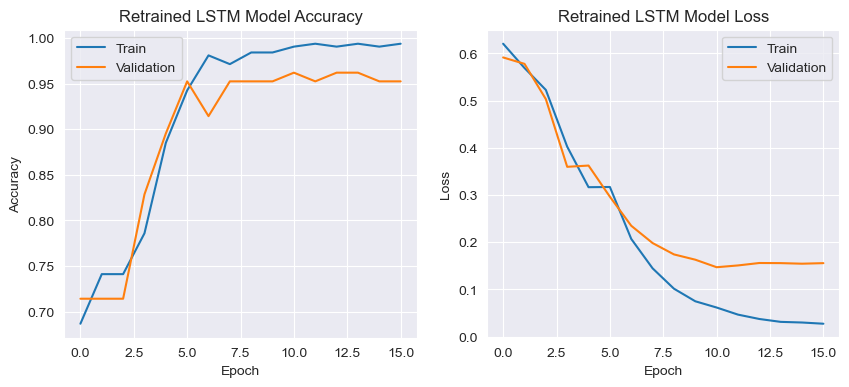

In [54]:
classification_tuned_LSTM_model = Sequential()
classification_tuned_LSTM_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))  # Adjust output_dim as needed
classification_tuned_LSTM_model.add(LSTM(units=random_search.best_params_['units'], dropout=random_search.best_params_['dropout'], recurrent_dropout=0.2))
classification_tuned_LSTM_model.add(Dense(1, activation='sigmoid'))

classification_tuned_LSTM_model.compile(optimizer=Adam(lr=random_search.best_params_['lr']), loss='binary_crossentropy', metrics=['accuracy'])
classification_tuned_LSTM_model.summary()

history_classification_tuned_LSTM_model = classification_tuned_LSTM_model.fit(data_X_train, scores_y_train, validation_data=(data_X_val, scores_y_val), epochs=30, batch_size=32, callbacks = [early_stopping])

# Final evaluation of the model - Accuracy
scores = classification_tuned_LSTM_model.evaluate(data_X_test, scores_y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

# Plot the accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Summarize history for accuracy
ax[0].plot(history_classification_tuned_LSTM_model.history['accuracy'])
ax[0].plot(history_classification_tuned_LSTM_model.history['val_accuracy'])
ax[0].set_title('Retrained LSTM Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
ax[1].plot(history_classification_tuned_LSTM_model.history['loss'])
ax[1].plot(history_classification_tuned_LSTM_model.history['val_loss'])
ax[1].set_title('Retrained LSTM Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

# Show the plot
plt.show()

From the cell output above, after running our LSTM model again, the accuracy of SimpleRNN can be calculated using `.evaluate()`, where it has remain the same at 92.38%, meaning that the model has not improve with the optimal parameters we got from the hyperparameter tuning. However, the difference between the accuracy and validation is smaller, telling us that the there is less overfitting.

___
# GRU Model Improvement - Hyperparameter Tuning
___

In [36]:
# Define the function to create the GRU model
def create_GRU_model(units, dropout, lr, num_layers):
    GRU_model = Sequential()
    GRU_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    
    # Add the specified number of GRU layers
    for i in range(num_layers):
        if i == num_layers - 1:  # Last layer
            GRU_model.add(GRU(units=units, dropout=dropout, recurrent_dropout=dropout))
        else:  # Intermediate layers
            GRU_model.add(GRU(units=units, dropout=dropout, recurrent_dropout=dropout, return_sequences=True))
    
    GRU_model.add(Dense(1, activation='sigmoid'))
    GRU_model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return GRU_model

# Define the parameter grid
param_grid = {
    'units': [64, 128, 256],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01, 0.1],
    'num_layers': [1, 2, 3]  # Adding num_layers to the parameter grid
}

# Create the KerasClassifier
GRU_model = KerasClassifier(build_fn=create_GRU_model)

# Perform Randomized Search CV
random_search = RandomizedSearchCV(GRU_model, param_grid, cv=5, scoring='accuracy', n_iter=10)
random_search.fit(data_X_train, scores_y_train, validation_data=(data_X_val, scores_y_val), epochs=30, batch_size=32, callbacks=[early_stopping])

# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# Evaluate the best model on the test data
best_model = random_search.best_estimator_.model
best_model.evaluate(data_X_test, scores_y_test)

C:\Users\angmi\AppData\Local\Temp\ipykernel_26320\22360709.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  GRU_model = KerasClassifier(build_fn=create_GRU_model)


Epoch 1/30
8/8 [==============================] - 8s 519ms/step - loss: 0.9386 - accuracy: 0.6680 - val_loss: 0.5652 - val_accuracy: 0.7619
Epoch 2/30
8/8 [==============================] - 4s 486ms/step - loss: 0.5507 - accuracy: 0.7640 - val_loss: 0.5159 - val_accuracy: 0.8095
Epoch 3/30
8/8 [==============================] - 4s 474ms/step - loss: 0.5807 - accuracy: 0.7520 - val_loss: 0.6477 - val_accuracy: 0.8095
Epoch 4/30
8/8 [==============================] - 4s 449ms/step - loss: 0.5216 - accuracy: 0.8120 - val_loss: 0.4847 - val_accuracy: 0.8286
Epoch 5/30
8/8 [==============================] - 4s 462ms/step - loss: 0.5380 - accuracy: 0.8120 - val_loss: 0.3901 - val_accuracy: 0.8381
Epoch 6/30
8/8 [==============================] - 4s 480ms/step - loss: 0.4871 - accuracy: 0.8040 - val_loss: 0.4520 - val_accuracy: 0.8190
Epoch 7/30
8/8 [==============================] - 4s 453ms/step - loss: 0.4530 - accuracy: 0.8240 - val_loss: 0.4529 - val_accuracy: 0.8381
Epoch 8/30
8/8 [====

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 8s 505ms/step - loss: 1.0235 - accuracy: 0.6360 - val_loss: 0.8272 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 465ms/step - loss: 0.7139 - accuracy: 0.7040 - val_loss: 0.7817 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 470ms/step - loss: 0.6810 - accuracy: 0.6880 - val_loss: 0.8116 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 462ms/step - loss: 0.5889 - accuracy: 0.7160 - val_loss: 0.5870 - val_accuracy: 0.7048
Epoch 5/30
8/8 [==============================] - 4s 473ms/step - loss: 0.5657 - accuracy: 0.7600 - val_loss: 0.5530 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 4s 474ms/step - loss: 0.5625 - accuracy: 0.7440 - val_loss: 0.6566 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 4s 463ms/step - loss: 0.6186 - accuracy: 0.6840 - val_loss: 0.5817 - val_accuracy: 0.7143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 530ms/step - loss: 0.9353 - accuracy: 0.6040 - val_loss: 0.7050 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 459ms/step - loss: 0.5937 - accuracy: 0.7240 - val_loss: 0.5745 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 469ms/step - loss: 0.5267 - accuracy: 0.7960 - val_loss: 0.4771 - val_accuracy: 0.8000
Epoch 4/30
8/8 [==============================] - 4s 452ms/step - loss: 0.5135 - accuracy: 0.7880 - val_loss: 0.5738 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 4s 454ms/step - loss: 0.5789 - accuracy: 0.7400 - val_loss: 0.5573 - val_accuracy: 0.7429
Epoch 6/30
8/8 [==============================] - 4s 460ms/step - loss: 0.6146 - accuracy: 0.7240 - val_loss: 0.5984 - val_accuracy: 0.7429
Epoch 7/30
8/8 [==============================] - 4s 462ms/step - loss: 0.6606 - accuracy: 0.7160 - val_loss: 0.5864 - val_accuracy: 0.6857
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 8s 519ms/step - loss: 1.0035 - accuracy: 0.6215 - val_loss: 0.5790 - val_accuracy: 0.7714
Epoch 2/30
8/8 [==============================] - 4s 493ms/step - loss: 0.5440 - accuracy: 0.7610 - val_loss: 0.5670 - val_accuracy: 0.7238
Epoch 3/30
8/8 [==============================] - 4s 482ms/step - loss: 0.5379 - accuracy: 0.7649 - val_loss: 0.5925 - val_accuracy: 0.7048
Epoch 4/30
8/8 [==============================] - 4s 480ms/step - loss: 0.5278 - accuracy: 0.7610 - val_loss: 0.4975 - val_accuracy: 0.7333
Epoch 5/30
8/8 [==============================] - 4s 501ms/step - loss: 0.4930 - accuracy: 0.7689 - val_loss: 0.4637 - val_accuracy: 0.7524
Epoch 6/30
8/8 [==============================] - 4s 460ms/step - loss: 0.4791 - accuracy: 0.7729 - val_loss: 0.4805 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 4s 458ms/step - loss: 0.4508 - accuracy: 0.8127 - val_loss: 0.4400 - val_accuracy: 0.7905
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 559ms/step - loss: 1.1229 - accuracy: 0.5857 - val_loss: 0.6427 - val_accuracy: 0.7048
Epoch 2/30
8/8 [==============================] - 4s 459ms/step - loss: 0.6340 - accuracy: 0.7291 - val_loss: 0.4918 - val_accuracy: 0.8095
Epoch 3/30
8/8 [==============================] - 4s 470ms/step - loss: 0.5967 - accuracy: 0.7530 - val_loss: 0.5165 - val_accuracy: 0.7714
Epoch 4/30
8/8 [==============================] - 4s 466ms/step - loss: 0.5412 - accuracy: 0.7331 - val_loss: 0.5990 - val_accuracy: 0.7333
Epoch 5/30
8/8 [==============================] - 4s 453ms/step - loss: 0.4959 - accuracy: 0.7729 - val_loss: 0.5360 - val_accuracy: 0.7619
Epoch 6/30
8/8 [==============================] - 4s 444ms/step - loss: 0.5127 - accuracy: 0.8127 - val_loss: 0.6100 - val_accuracy: 0.7429
Epoch 7/30
2/2 [==============================] - 1s 49ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 8s 538ms/step - loss: 0.9096 - accuracy: 0.5760 - val_loss: 0.6278 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 485ms/step - loss: 1.0096 - accuracy: 0.6080 - val_loss: 0.7927 - val_accuracy: 0.2762
Epoch 3/30
8/8 [==============================] - 4s 459ms/step - loss: 0.6138 - accuracy: 0.6840 - val_loss: 0.6009 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 464ms/step - loss: 0.5857 - accuracy: 0.7320 - val_loss: 0.5985 - val_accuracy: 0.7143
Epoch 5/30
8/8 [==============================] - 4s 498ms/step - loss: 0.5928 - accuracy: 0.7320 - val_loss: 0.5980 - val_accuracy: 0.7143
Epoch 6/30
8/8 [==============================] - 4s 483ms/step - loss: 0.5792 - accuracy: 0.7320 - val_loss: 0.6680 - val_accuracy: 0.7143
Epoch 7/30
8/8 [==============================] - 4s 520ms/step - loss: 0.6330 - accuracy: 0.6840 - val_loss: 0.7040 - val_accuracy: 0.3048
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 559ms/step - loss: 1.6325 - accuracy: 0.7120 - val_loss: 0.6280 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 471ms/step - loss: 0.5551 - accuracy: 0.7680 - val_loss: 0.6794 - val_accuracy: 0.7619
Epoch 3/30
8/8 [==============================] - 4s 450ms/step - loss: 0.4687 - accuracy: 0.8280 - val_loss: 0.5558 - val_accuracy: 0.7524
Epoch 4/30
8/8 [==============================] - 4s 455ms/step - loss: 0.4132 - accuracy: 0.8360 - val_loss: 0.4536 - val_accuracy: 0.8381
Epoch 5/30
8/8 [==============================] - 4s 485ms/step - loss: 0.4416 - accuracy: 0.8320 - val_loss: 0.3061 - val_accuracy: 0.8857
Epoch 6/30
8/8 [==============================] - 4s 476ms/step - loss: 0.1971 - accuracy: 0.9480 - val_loss: 0.2946 - val_accuracy: 0.9238
Epoch 7/30
8/8 [==============================] - 4s 476ms/step - loss: 0.1226 - accuracy: 0.9680 - val_loss: 0.2191 - val_accuracy: 0.9333
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 573ms/step - loss: 0.6206 - accuracy: 0.6920 - val_loss: 0.6935 - val_accuracy: 0.6381
Epoch 2/30
8/8 [==============================] - 4s 464ms/step - loss: 0.3795 - accuracy: 0.8440 - val_loss: 0.3028 - val_accuracy: 0.9048
Epoch 3/30
8/8 [==============================] - 4s 485ms/step - loss: 0.1174 - accuracy: 0.9640 - val_loss: 0.3251 - val_accuracy: 0.8952
Epoch 4/30
8/8 [==============================] - 4s 461ms/step - loss: 0.1240 - accuracy: 0.9680 - val_loss: 0.5020 - val_accuracy: 0.8952
Epoch 5/30
8/8 [==============================] - 4s 479ms/step - loss: 0.1161 - accuracy: 0.9640 - val_loss: 0.3943 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 4s 483ms/step - loss: 0.1166 - accuracy: 0.9640 - val_loss: 0.4035 - val_accuracy: 0.8762
Epoch 7/30
2/2 [==============================] - 1s 44ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 558ms/step - loss: 1.3287 - accuracy: 0.6414 - val_loss: 0.5697 - val_accuracy: 0.7238
Epoch 2/30
8/8 [==============================] - 4s 487ms/step - loss: 0.5153 - accuracy: 0.7450 - val_loss: 0.3452 - val_accuracy: 0.8667
Epoch 3/30
8/8 [==============================] - 4s 458ms/step - loss: 0.2047 - accuracy: 0.9124 - val_loss: 0.3455 - val_accuracy: 0.8667
Epoch 4/30
8/8 [==============================] - 4s 482ms/step - loss: 0.1769 - accuracy: 0.9402 - val_loss: 0.2593 - val_accuracy: 0.8857
Epoch 5/30
8/8 [==============================] - 4s 467ms/step - loss: 0.2137 - accuracy: 0.9163 - val_loss: 0.2502 - val_accuracy: 0.9333
Epoch 6/30
8/8 [==============================] - 4s 507ms/step - loss: 0.2002 - accuracy: 0.9363 - val_loss: 0.3055 - val_accuracy: 0.8762
Epoch 7/30
8/8 [==============================] - 4s 485ms/step - loss: 0.2547 - accuracy: 0.8924 - val_loss: 0.3607 - val_accuracy: 0.8476
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 524ms/step - loss: 1.7004 - accuracy: 0.5777 - val_loss: 0.7665 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 434ms/step - loss: 0.6437 - accuracy: 0.7171 - val_loss: 1.4905 - val_accuracy: 0.3810
Epoch 3/30
8/8 [==============================] - 4s 450ms/step - loss: 0.6815 - accuracy: 0.6932 - val_loss: 0.6028 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 447ms/step - loss: 0.4790 - accuracy: 0.7649 - val_loss: 0.4166 - val_accuracy: 0.7810
Epoch 5/30
8/8 [==============================] - 3s 443ms/step - loss: 0.3053 - accuracy: 0.8486 - val_loss: 0.3712 - val_accuracy: 0.8476
Epoch 6/30
8/8 [==============================] - 4s 448ms/step - loss: 0.2539 - accuracy: 0.9283 - val_loss: 0.4624 - val_accuracy: 0.8000
Epoch 7/30
8/8 [==============================] - 4s 453ms/step - loss: 0.2664 - accuracy: 0.9004 - val_loss: 0.4720 - val_accuracy: 0.7238
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 196ms/step - loss: 0.5150 - accuracy: 0.7320 - val_loss: 0.3156 - val_accuracy: 0.8857
Epoch 2/30
8/8 [==============================] - 1s 150ms/step - loss: 0.1398 - accuracy: 0.9640 - val_loss: 0.3731 - val_accuracy: 0.8952
Epoch 3/30
8/8 [==============================] - 1s 151ms/step - loss: 0.0423 - accuracy: 0.9880 - val_loss: 0.4499 - val_accuracy: 0.9143
Epoch 4/30
8/8 [==============================] - 1s 153ms/step - loss: 0.0333 - accuracy: 0.9920 - val_loss: 0.4680 - val_accuracy: 0.9048
Epoch 5/30
8/8 [==============================] - 1s 154ms/step - loss: 0.0216 - accuracy: 0.9960 - val_loss: 0.4556 - val_accuracy: 0.9048
Epoch 6/30
2/2 [==============================] - 0s 20ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 184ms/step - loss: 0.5509 - accuracy: 0.7200 - val_loss: 0.3511 - val_accuracy: 0.8476
Epoch 2/30
8/8 [==============================] - 1s 150ms/step - loss: 0.1790 - accuracy: 0.9400 - val_loss: 0.3028 - val_accuracy: 0.8762
Epoch 3/30
8/8 [==============================] - 1s 159ms/step - loss: 0.0535 - accuracy: 0.9800 - val_loss: 0.3410 - val_accuracy: 0.9048
Epoch 4/30
8/8 [==============================] - 1s 160ms/step - loss: 0.0446 - accuracy: 0.9880 - val_loss: 0.3218 - val_accuracy: 0.9143
Epoch 5/30
8/8 [==============================] - 1s 164ms/step - loss: 0.0350 - accuracy: 0.9760 - val_loss: 0.3217 - val_accuracy: 0.9048
Epoch 6/30
8/8 [==============================] - 1s 153ms/step - loss: 0.0282 - accuracy: 0.9880 - val_loss: 0.3755 - val_accuracy: 0.9143
Epoch 7/30
2/2 [==============================] - 0s 20ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 191ms/step - loss: 0.5621 - accuracy: 0.7160 - val_loss: 0.3253 - val_accuracy: 0.8667
Epoch 2/30
8/8 [==============================] - 1s 158ms/step - loss: 0.1510 - accuracy: 0.9520 - val_loss: 0.3730 - val_accuracy: 0.8381
Epoch 3/30
8/8 [==============================] - 1s 163ms/step - loss: 0.0503 - accuracy: 0.9760 - val_loss: 0.4076 - val_accuracy: 0.8762
Epoch 4/30
8/8 [==============================] - 1s 162ms/step - loss: 0.0325 - accuracy: 0.9800 - val_loss: 0.4391 - val_accuracy: 0.8571
Epoch 5/30
8/8 [==============================] - 1s 156ms/step - loss: 0.0302 - accuracy: 0.9840 - val_loss: 0.4407 - val_accuracy: 0.9143
Epoch 6/30
2/2 [==============================] - 0s 19ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 183ms/step - loss: 0.6889 - accuracy: 0.7171 - val_loss: 0.4439 - val_accuracy: 0.8762
Epoch 2/30
8/8 [==============================] - 1s 154ms/step - loss: 0.2642 - accuracy: 0.9522 - val_loss: 0.2514 - val_accuracy: 0.8952
Epoch 3/30
8/8 [==============================] - 1s 167ms/step - loss: 0.1023 - accuracy: 0.9602 - val_loss: 0.2982 - val_accuracy: 0.8762
Epoch 4/30
8/8 [==============================] - 1s 157ms/step - loss: 0.0510 - accuracy: 0.9681 - val_loss: 0.3197 - val_accuracy: 0.8857
Epoch 5/30
8/8 [==============================] - 1s 153ms/step - loss: 0.0386 - accuracy: 0.9841 - val_loss: 0.3490 - val_accuracy: 0.9238
Epoch 6/30
8/8 [==============================] - 1s 157ms/step - loss: 0.0378 - accuracy: 0.9920 - val_loss: 0.2987 - val_accuracy: 0.9238
Epoch 7/30
2/2 [==============================] - 0s 19ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 200ms/step - loss: 0.8715 - accuracy: 0.7251 - val_loss: 0.4472 - val_accuracy: 0.9238
Epoch 2/30
8/8 [==============================] - 1s 150ms/step - loss: 0.2872 - accuracy: 0.9721 - val_loss: 0.2192 - val_accuracy: 0.9238
Epoch 3/30
8/8 [==============================] - 1s 160ms/step - loss: 0.0885 - accuracy: 0.9761 - val_loss: 0.2304 - val_accuracy: 0.9048
Epoch 4/30
8/8 [==============================] - 1s 155ms/step - loss: 0.0417 - accuracy: 0.9761 - val_loss: 0.2792 - val_accuracy: 0.9048
Epoch 5/30
8/8 [==============================] - 1s 156ms/step - loss: 0.0301 - accuracy: 0.9920 - val_loss: 0.3095 - val_accuracy: 0.9143
Epoch 6/30
8/8 [==============================] - 1s 149ms/step - loss: 0.0328 - accuracy: 0.9841 - val_loss: 0.2712 - val_accuracy: 0.9238
Epoch 7/30
2/2 [==============================] - 0s 20ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 189ms/step - loss: 0.6473 - accuracy: 0.7120 - val_loss: 0.3076 - val_accuracy: 0.8952
Epoch 2/30
8/8 [==============================] - 1s 162ms/step - loss: 0.1344 - accuracy: 0.9600 - val_loss: 0.2597 - val_accuracy: 0.9238
Epoch 3/30
8/8 [==============================] - 1s 170ms/step - loss: 0.0340 - accuracy: 0.9840 - val_loss: 0.4165 - val_accuracy: 0.9048
Epoch 4/30
8/8 [==============================] - 1s 151ms/step - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.4467 - val_accuracy: 0.8857
Epoch 5/30
8/8 [==============================] - 1s 159ms/step - loss: 0.0285 - accuracy: 0.9880 - val_loss: 0.5243 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 1s 177ms/step - loss: 0.0444 - accuracy: 0.9840 - val_loss: 0.4362 - val_accuracy: 0.9238
Epoch 7/30
2/2 [==============================] - 0s 17ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 191ms/step - loss: 0.6521 - accuracy: 0.6320 - val_loss: 0.6358 - val_accuracy: 0.7048
Epoch 2/30
8/8 [==============================] - 1s 155ms/step - loss: 0.3089 - accuracy: 0.8600 - val_loss: 0.3861 - val_accuracy: 0.8762
Epoch 3/30
8/8 [==============================] - 1s 148ms/step - loss: 0.1137 - accuracy: 0.9440 - val_loss: 0.3868 - val_accuracy: 0.8762
Epoch 4/30
8/8 [==============================] - 1s 161ms/step - loss: 0.0653 - accuracy: 0.9800 - val_loss: 0.3938 - val_accuracy: 0.8857
Epoch 5/30
8/8 [==============================] - 1s 157ms/step - loss: 0.0650 - accuracy: 0.9760 - val_loss: 0.5105 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 1s 169ms/step - loss: 0.0837 - accuracy: 0.9800 - val_loss: 0.5197 - val_accuracy: 0.8762
Epoch 7/30
2/2 [==============================] - 0s 24ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 197ms/step - loss: 0.7578 - accuracy: 0.6600 - val_loss: 0.4421 - val_accuracy: 0.8095
Epoch 2/30
8/8 [==============================] - 1s 163ms/step - loss: 0.2309 - accuracy: 0.9000 - val_loss: 0.5440 - val_accuracy: 0.8381
Epoch 3/30
8/8 [==============================] - 1s 172ms/step - loss: 0.1017 - accuracy: 0.9680 - val_loss: 0.7039 - val_accuracy: 0.8571
Epoch 4/30
8/8 [==============================] - 1s 162ms/step - loss: 0.0960 - accuracy: 0.9640 - val_loss: 0.7538 - val_accuracy: 0.8476
Epoch 5/30
8/8 [==============================] - 1s 156ms/step - loss: 0.0706 - accuracy: 0.9720 - val_loss: 0.7794 - val_accuracy: 0.8381
Epoch 6/30
2/2 [==============================] - 0s 15ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 186ms/step - loss: 0.8508 - accuracy: 0.7211 - val_loss: 0.2990 - val_accuracy: 0.8667
Epoch 2/30
8/8 [==============================] - 1s 145ms/step - loss: 0.1876 - accuracy: 0.9482 - val_loss: 0.3310 - val_accuracy: 0.8952
Epoch 3/30
8/8 [==============================] - 1s 162ms/step - loss: 0.1345 - accuracy: 0.9482 - val_loss: 0.3104 - val_accuracy: 0.9238
Epoch 4/30
8/8 [==============================] - 1s 151ms/step - loss: 0.0746 - accuracy: 0.9641 - val_loss: 0.2869 - val_accuracy: 0.8857
Epoch 5/30
8/8 [==============================] - 1s 157ms/step - loss: 0.0611 - accuracy: 0.9721 - val_loss: 0.3619 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 1s 162ms/step - loss: 0.1229 - accuracy: 0.9641 - val_loss: 0.3483 - val_accuracy: 0.8952
Epoch 7/30
8/8 [==============================] - 1s 168ms/step - loss: 0.0909 - accuracy: 0.9681 - val_loss: 0.3575 - val_accuracy: 0.8857
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 200ms/step - loss: 0.8287 - accuracy: 0.7371 - val_loss: 0.3338 - val_accuracy: 0.8857
Epoch 2/30
8/8 [==============================] - 1s 151ms/step - loss: 0.1631 - accuracy: 0.9402 - val_loss: 0.3125 - val_accuracy: 0.9048
Epoch 3/30
8/8 [==============================] - 1s 155ms/step - loss: 0.0755 - accuracy: 0.9721 - val_loss: 0.3122 - val_accuracy: 0.9143
Epoch 4/30
8/8 [==============================] - 1s 154ms/step - loss: 0.0811 - accuracy: 0.9681 - val_loss: 0.2426 - val_accuracy: 0.9238
Epoch 5/30
8/8 [==============================] - 1s 157ms/step - loss: 0.0703 - accuracy: 0.9761 - val_loss: 0.2281 - val_accuracy: 0.9333
Epoch 6/30
8/8 [==============================] - 1s 159ms/step - loss: 0.0392 - accuracy: 0.9880 - val_loss: 0.2692 - val_accuracy: 0.9238
Epoch 7/30
8/8 [==============================] - 1s 156ms/step - loss: 0.0817 - accuracy: 0.9721 - val_loss: 0.3107 - val_accuracy: 0.8952
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 188ms/step - loss: 0.9454 - accuracy: 0.7280 - val_loss: 0.4176 - val_accuracy: 0.8381
Epoch 2/30
8/8 [==============================] - 1s 155ms/step - loss: 0.2024 - accuracy: 0.9440 - val_loss: 0.2704 - val_accuracy: 0.8952
Epoch 3/30
8/8 [==============================] - 1s 156ms/step - loss: 0.0635 - accuracy: 0.9840 - val_loss: 0.3518 - val_accuracy: 0.9048
Epoch 4/30
8/8 [==============================] - 1s 166ms/step - loss: 0.0260 - accuracy: 0.9880 - val_loss: 0.3412 - val_accuracy: 0.9238
Epoch 5/30
8/8 [==============================] - 1s 167ms/step - loss: 0.0249 - accuracy: 0.9880 - val_loss: 0.4396 - val_accuracy: 0.8667
Epoch 6/30
8/8 [==============================] - 1s 160ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.4964 - val_accuracy: 0.8667
Epoch 7/30
2/2 [==============================] - 0s 17ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 221ms/step - loss: 1.2035 - accuracy: 0.7240 - val_loss: 0.4904 - val_accuracy: 0.8571
Epoch 2/30
8/8 [==============================] - 1s 164ms/step - loss: 0.2765 - accuracy: 0.9200 - val_loss: 0.2961 - val_accuracy: 0.8857
Epoch 3/30
8/8 [==============================] - 1s 177ms/step - loss: 0.1145 - accuracy: 0.9720 - val_loss: 0.2856 - val_accuracy: 0.9524
Epoch 4/30
8/8 [==============================] - 1s 185ms/step - loss: 0.0565 - accuracy: 0.9760 - val_loss: 0.3019 - val_accuracy: 0.9524
Epoch 5/30
8/8 [==============================] - 1s 160ms/step - loss: 0.0386 - accuracy: 0.9840 - val_loss: 0.3241 - val_accuracy: 0.9429
Epoch 6/30
8/8 [==============================] - 1s 164ms/step - loss: 0.0159 - accuracy: 0.9960 - val_loss: 0.3727 - val_accuracy: 0.9429
Epoch 7/30
8/8 [==============================] - 1s 165ms/step - loss: 0.0289 - accuracy: 0.9880 - val_loss: 0.3218 - val_accuracy: 0.9238
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 193ms/step - loss: 0.9393 - accuracy: 0.7360 - val_loss: 0.4014 - val_accuracy: 0.8762
Epoch 2/30
8/8 [==============================] - 1s 167ms/step - loss: 0.1983 - accuracy: 0.9520 - val_loss: 0.2807 - val_accuracy: 0.8571
Epoch 3/30
8/8 [==============================] - 1s 157ms/step - loss: 0.0727 - accuracy: 0.9720 - val_loss: 0.3942 - val_accuracy: 0.8857
Epoch 4/30
8/8 [==============================] - 1s 165ms/step - loss: 0.0485 - accuracy: 0.9760 - val_loss: 0.4339 - val_accuracy: 0.8476
Epoch 5/30
8/8 [==============================] - 1s 160ms/step - loss: 0.0351 - accuracy: 0.9840 - val_loss: 0.3756 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 1s 155ms/step - loss: 0.0535 - accuracy: 0.9800 - val_loss: 0.3724 - val_accuracy: 0.8952
Epoch 7/30
2/2 [==============================] - 0s 21ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 192ms/step - loss: 0.7795 - accuracy: 0.7371 - val_loss: 0.4652 - val_accuracy: 0.8381
Epoch 2/30
8/8 [==============================] - 1s 155ms/step - loss: 0.3222 - accuracy: 0.9044 - val_loss: 0.2469 - val_accuracy: 0.9238
Epoch 3/30
8/8 [==============================] - 1s 153ms/step - loss: 0.1144 - accuracy: 0.9562 - val_loss: 0.2464 - val_accuracy: 0.8381
Epoch 4/30
8/8 [==============================] - 1s 162ms/step - loss: 0.1259 - accuracy: 0.9482 - val_loss: 0.2598 - val_accuracy: 0.8667
Epoch 5/30
8/8 [==============================] - 1s 153ms/step - loss: 0.1497 - accuracy: 0.9562 - val_loss: 0.2641 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 1s 177ms/step - loss: 0.1239 - accuracy: 0.9602 - val_loss: 0.2611 - val_accuracy: 0.8762
Epoch 7/30
8/8 [==============================] - 1s 161ms/step - loss: 0.0911 - accuracy: 0.9641 - val_loss: 0.2992 - val_accuracy: 0.9048
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 190ms/step - loss: 0.7939 - accuracy: 0.7371 - val_loss: 0.4152 - val_accuracy: 0.8571
Epoch 2/30
8/8 [==============================] - 1s 158ms/step - loss: 0.2511 - accuracy: 0.9124 - val_loss: 0.2766 - val_accuracy: 0.8762
Epoch 3/30
8/8 [==============================] - 1s 162ms/step - loss: 0.0979 - accuracy: 0.9681 - val_loss: 0.2846 - val_accuracy: 0.9238
Epoch 4/30
8/8 [==============================] - 1s 154ms/step - loss: 0.0506 - accuracy: 0.9801 - val_loss: 0.3843 - val_accuracy: 0.9333
Epoch 5/30
8/8 [==============================] - 1s 152ms/step - loss: 0.0270 - accuracy: 0.9920 - val_loss: 0.3779 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 1s 155ms/step - loss: 0.0466 - accuracy: 0.9841 - val_loss: 0.3335 - val_accuracy: 0.9143
Epoch 7/30
2/2 [==============================] - 0s 19ms/step
Epoch 1/30


c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 363ms/step - loss: 0.6171 - accuracy: 0.6760 - val_loss: 0.6010 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 2s 296ms/step - loss: 0.5419 - accuracy: 0.7320 - val_loss: 0.5055 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 2s 299ms/step - loss: 0.3759 - accuracy: 0.7960 - val_loss: 0.3247 - val_accuracy: 0.8476
Epoch 4/30
8/8 [==============================] - 2s 297ms/step - loss: 0.1832 - accuracy: 0.9280 - val_loss: 0.4161 - val_accuracy: 0.8857
Epoch 5/30
8/8 [==============================] - 2s 293ms/step - loss: 0.1647 - accuracy: 0.9280 - val_loss: 0.2659 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 2s 293ms/step - loss: 0.1031 - accuracy: 0.9680 - val_loss: 0.2092 - val_accuracy: 0.9143
Epoch 7/30
8/8 [==============================] - 2s 303ms/step - loss: 0.0576 - accuracy: 0.9760 - val_loss: 0.2153 - val_accuracy: 0.9333
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 360ms/step - loss: 0.5931 - accuracy: 0.7400 - val_loss: 0.8880 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 316ms/step - loss: 0.5704 - accuracy: 0.7600 - val_loss: 0.5492 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 2s 312ms/step - loss: 0.4670 - accuracy: 0.7600 - val_loss: 0.4368 - val_accuracy: 0.7238
Epoch 4/30
8/8 [==============================] - 2s 313ms/step - loss: 0.3165 - accuracy: 0.8280 - val_loss: 0.2855 - val_accuracy: 0.8667
Epoch 5/30
8/8 [==============================] - 3s 326ms/step - loss: 0.1596 - accuracy: 0.9440 - val_loss: 0.2012 - val_accuracy: 0.9333
Epoch 6/30
8/8 [==============================] - 2s 307ms/step - loss: 0.0989 - accuracy: 0.9560 - val_loss: 0.2128 - val_accuracy: 0.9333
Epoch 7/30
8/8 [==============================] - 2s 317ms/step - loss: 0.0692 - accuracy: 0.9720 - val_loss: 0.2099 - val_accuracy: 0.9333
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 355ms/step - loss: 0.5989 - accuracy: 0.7120 - val_loss: 0.6255 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 2s 307ms/step - loss: 0.5406 - accuracy: 0.7240 - val_loss: 0.4920 - val_accuracy: 0.7429
Epoch 3/30
8/8 [==============================] - 2s 299ms/step - loss: 0.3816 - accuracy: 0.8240 - val_loss: 0.2841 - val_accuracy: 0.8667
Epoch 4/30
8/8 [==============================] - 3s 317ms/step - loss: 0.1700 - accuracy: 0.9320 - val_loss: 0.3024 - val_accuracy: 0.8952
Epoch 5/30
8/8 [==============================] - 2s 308ms/step - loss: 0.1451 - accuracy: 0.9320 - val_loss: 0.2498 - val_accuracy: 0.8571
Epoch 6/30
8/8 [==============================] - 2s 307ms/step - loss: 0.1063 - accuracy: 0.9680 - val_loss: 0.1988 - val_accuracy: 0.9238
Epoch 7/30
8/8 [==============================] - 3s 324ms/step - loss: 0.0475 - accuracy: 0.9880 - val_loss: 0.2311 - val_accuracy: 0.9143
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 371ms/step - loss: 0.6242 - accuracy: 0.7450 - val_loss: 0.5919 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 328ms/step - loss: 0.5167 - accuracy: 0.7530 - val_loss: 0.5056 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 321ms/step - loss: 0.3950 - accuracy: 0.7689 - val_loss: 0.3366 - val_accuracy: 0.8381
Epoch 4/30
8/8 [==============================] - 3s 336ms/step - loss: 0.1969 - accuracy: 0.9442 - val_loss: 0.2042 - val_accuracy: 0.9143
Epoch 5/30
8/8 [==============================] - 2s 316ms/step - loss: 0.1119 - accuracy: 0.9522 - val_loss: 0.2155 - val_accuracy: 0.9429
Epoch 6/30
8/8 [==============================] - 3s 323ms/step - loss: 0.0901 - accuracy: 0.9721 - val_loss: 0.2713 - val_accuracy: 0.8952
Epoch 7/30
8/8 [==============================] - 3s 323ms/step - loss: 0.0749 - accuracy: 0.9761 - val_loss: 0.2140 - val_accuracy: 0.9429
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 360ms/step - loss: 0.6270 - accuracy: 0.7092 - val_loss: 0.6117 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 334ms/step - loss: 0.5390 - accuracy: 0.7371 - val_loss: 0.5155 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 344ms/step - loss: 0.4109 - accuracy: 0.7610 - val_loss: 0.3328 - val_accuracy: 0.8571
Epoch 4/30
8/8 [==============================] - 3s 320ms/step - loss: 0.1890 - accuracy: 0.9203 - val_loss: 0.2122 - val_accuracy: 0.9048
Epoch 5/30
8/8 [==============================] - 2s 316ms/step - loss: 0.1090 - accuracy: 0.9602 - val_loss: 0.1983 - val_accuracy: 0.9333
Epoch 6/30
8/8 [==============================] - 2s 312ms/step - loss: 0.0555 - accuracy: 0.9841 - val_loss: 0.2246 - val_accuracy: 0.9333
Epoch 7/30
8/8 [==============================] - 3s 332ms/step - loss: 0.0329 - accuracy: 0.9880 - val_loss: 0.2487 - val_accuracy: 0.9238
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 349ms/step - loss: 1.3940 - accuracy: 0.6400 - val_loss: 1.0887 - val_accuracy: 0.7333
Epoch 2/30
8/8 [==============================] - 3s 311ms/step - loss: 0.7302 - accuracy: 0.8000 - val_loss: 0.6860 - val_accuracy: 0.7905
Epoch 3/30
8/8 [==============================] - 2s 318ms/step - loss: 0.5933 - accuracy: 0.8400 - val_loss: 0.6451 - val_accuracy: 0.8000
Epoch 4/30
8/8 [==============================] - 2s 294ms/step - loss: 0.4388 - accuracy: 0.8400 - val_loss: 0.4826 - val_accuracy: 0.8571
Epoch 5/30
8/8 [==============================] - 2s 298ms/step - loss: 0.3967 - accuracy: 0.8440 - val_loss: 0.6542 - val_accuracy: 0.8095
Epoch 6/30
8/8 [==============================] - 3s 324ms/step - loss: 0.3880 - accuracy: 0.8560 - val_loss: 0.4728 - val_accuracy: 0.8857
Epoch 7/30
8/8 [==============================] - 2s 319ms/step - loss: 0.3748 - accuracy: 0.8600 - val_loss: 0.4503 - val_accuracy: 0.8667
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 362ms/step - loss: 0.9326 - accuracy: 0.6440 - val_loss: 0.6926 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 2s 298ms/step - loss: 0.4712 - accuracy: 0.8160 - val_loss: 0.5519 - val_accuracy: 0.8286
Epoch 3/30
8/8 [==============================] - 3s 317ms/step - loss: 0.4666 - accuracy: 0.8400 - val_loss: 0.4989 - val_accuracy: 0.8190
Epoch 4/30
8/8 [==============================] - 3s 320ms/step - loss: 0.3364 - accuracy: 0.8560 - val_loss: 0.4970 - val_accuracy: 0.8000
Epoch 5/30
8/8 [==============================] - 2s 305ms/step - loss: 0.3308 - accuracy: 0.8560 - val_loss: 0.4960 - val_accuracy: 0.7810
Epoch 6/30
8/8 [==============================] - 2s 309ms/step - loss: 0.2698 - accuracy: 0.8760 - val_loss: 0.4904 - val_accuracy: 0.8667
Epoch 7/30
8/8 [==============================] - 2s 311ms/step - loss: 0.1844 - accuracy: 0.9400 - val_loss: 0.5405 - val_accuracy: 0.8381
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 334ms/step - loss: 1.4286 - accuracy: 0.6200 - val_loss: 0.9579 - val_accuracy: 0.3048
Epoch 2/30
8/8 [==============================] - 2s 291ms/step - loss: 0.7514 - accuracy: 0.6800 - val_loss: 0.6544 - val_accuracy: 0.5905
Epoch 3/30
8/8 [==============================] - 2s 295ms/step - loss: 0.6791 - accuracy: 0.7080 - val_loss: 0.7554 - val_accuracy: 0.7238
Epoch 4/30
8/8 [==============================] - 2s 279ms/step - loss: 0.6978 - accuracy: 0.7800 - val_loss: 0.6756 - val_accuracy: 0.8000
Epoch 5/30
8/8 [==============================] - 2s 294ms/step - loss: 0.5527 - accuracy: 0.7480 - val_loss: 0.4189 - val_accuracy: 0.8286
Epoch 6/30
8/8 [==============================] - 2s 292ms/step - loss: 0.5350 - accuracy: 0.7720 - val_loss: 0.3405 - val_accuracy: 0.8571
Epoch 7/30
8/8 [==============================] - 2s 292ms/step - loss: 0.5143 - accuracy: 0.8200 - val_loss: 0.5113 - val_accuracy: 0.8000
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 344ms/step - loss: 0.9379 - accuracy: 0.6733 - val_loss: 0.8556 - val_accuracy: 0.7619
Epoch 2/30
8/8 [==============================] - 2s 293ms/step - loss: 0.7303 - accuracy: 0.7371 - val_loss: 0.6784 - val_accuracy: 0.6571
Epoch 3/30
8/8 [==============================] - 3s 317ms/step - loss: 0.5605 - accuracy: 0.7649 - val_loss: 0.6267 - val_accuracy: 0.7048
Epoch 4/30
8/8 [==============================] - 3s 334ms/step - loss: 0.5049 - accuracy: 0.7849 - val_loss: 0.4340 - val_accuracy: 0.8095
Epoch 5/30
8/8 [==============================] - 2s 308ms/step - loss: 0.4664 - accuracy: 0.7729 - val_loss: 0.5666 - val_accuracy: 0.7333
Epoch 6/30
8/8 [==============================] - 2s 304ms/step - loss: 0.4685 - accuracy: 0.8008 - val_loss: 0.4762 - val_accuracy: 0.7810
Epoch 7/30
8/8 [==============================] - 2s 292ms/step - loss: 0.4231 - accuracy: 0.8048 - val_loss: 0.5504 - val_accuracy: 0.7333
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 372ms/step - loss: 1.1809 - accuracy: 0.5896 - val_loss: 0.6686 - val_accuracy: 0.7333
Epoch 2/30
8/8 [==============================] - 2s 301ms/step - loss: 0.5848 - accuracy: 0.7490 - val_loss: 0.5061 - val_accuracy: 0.8095
Epoch 3/30
8/8 [==============================] - 3s 316ms/step - loss: 0.4245 - accuracy: 0.8207 - val_loss: 0.4855 - val_accuracy: 0.8095
Epoch 4/30
8/8 [==============================] - 2s 304ms/step - loss: 0.3985 - accuracy: 0.8327 - val_loss: 0.5585 - val_accuracy: 0.8190
Epoch 5/30
8/8 [==============================] - 2s 298ms/step - loss: 0.3284 - accuracy: 0.8645 - val_loss: 0.4825 - val_accuracy: 0.8667
Epoch 6/30
8/8 [==============================] - 3s 331ms/step - loss: 0.3162 - accuracy: 0.8765 - val_loss: 0.3800 - val_accuracy: 0.8762
Epoch 7/30
8/8 [==============================] - 2s 294ms/step - loss: 0.2390 - accuracy: 0.9084 - val_loss: 0.4247 - val_accuracy: 0.8762
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 523ms/step - loss: 0.6162 - accuracy: 0.7200 - val_loss: 0.6363 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 465ms/step - loss: 0.5673 - accuracy: 0.7320 - val_loss: 0.5437 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 456ms/step - loss: 0.4622 - accuracy: 0.7400 - val_loss: 0.4376 - val_accuracy: 0.7524
Epoch 4/30
8/8 [==============================] - 4s 479ms/step - loss: 0.2923 - accuracy: 0.8360 - val_loss: 0.2888 - val_accuracy: 0.8952
Epoch 5/30
8/8 [==============================] - 4s 461ms/step - loss: 0.1426 - accuracy: 0.9400 - val_loss: 0.2556 - val_accuracy: 0.8857
Epoch 6/30
8/8 [==============================] - 4s 438ms/step - loss: 0.1053 - accuracy: 0.9640 - val_loss: 0.2300 - val_accuracy: 0.9048
Epoch 7/30
8/8 [==============================] - 4s 482ms/step - loss: 0.0616 - accuracy: 0.9720 - val_loss: 0.2824 - val_accuracy: 0.9238
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 8s 538ms/step - loss: 0.5994 - accuracy: 0.7320 - val_loss: 0.7411 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 453ms/step - loss: 0.5607 - accuracy: 0.7600 - val_loss: 0.5572 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 452ms/step - loss: 0.4936 - accuracy: 0.7600 - val_loss: 0.4869 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 441ms/step - loss: 0.3700 - accuracy: 0.7880 - val_loss: 0.3186 - val_accuracy: 0.8476
Epoch 5/30
8/8 [==============================] - 4s 506ms/step - loss: 0.1998 - accuracy: 0.9120 - val_loss: 0.2117 - val_accuracy: 0.9333
Epoch 6/30
8/8 [==============================] - 4s 493ms/step - loss: 0.1312 - accuracy: 0.9320 - val_loss: 0.2207 - val_accuracy: 0.9238
Epoch 7/30
8/8 [==============================] - 4s 450ms/step - loss: 0.0928 - accuracy: 0.9600 - val_loss: 0.1806 - val_accuracy: 0.9524
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 8s 517ms/step - loss: 0.6085 - accuracy: 0.6920 - val_loss: 0.7413 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 449ms/step - loss: 0.5955 - accuracy: 0.7240 - val_loss: 0.5692 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 461ms/step - loss: 0.5238 - accuracy: 0.7240 - val_loss: 0.4801 - val_accuracy: 0.7333
Epoch 4/30
8/8 [==============================] - 4s 452ms/step - loss: 0.3641 - accuracy: 0.8200 - val_loss: 0.2988 - val_accuracy: 0.8571
Epoch 5/30
8/8 [==============================] - 4s 477ms/step - loss: 0.1800 - accuracy: 0.9040 - val_loss: 0.2603 - val_accuracy: 0.9143
Epoch 6/30
8/8 [==============================] - 4s 452ms/step - loss: 0.1205 - accuracy: 0.9440 - val_loss: 0.2230 - val_accuracy: 0.9333
Epoch 7/30
8/8 [==============================] - 4s 463ms/step - loss: 0.0692 - accuracy: 0.9680 - val_loss: 0.2039 - val_accuracy: 0.9333
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 491ms/step - loss: 0.6292 - accuracy: 0.7251 - val_loss: 0.6242 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 3s 424ms/step - loss: 0.5320 - accuracy: 0.7530 - val_loss: 0.5343 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 3s 423ms/step - loss: 0.4382 - accuracy: 0.7649 - val_loss: 0.3980 - val_accuracy: 0.7905
Epoch 4/30
8/8 [==============================] - 3s 421ms/step - loss: 0.2384 - accuracy: 0.9124 - val_loss: 0.2123 - val_accuracy: 0.9429
Epoch 5/30
8/8 [==============================] - 3s 422ms/step - loss: 0.1501 - accuracy: 0.9163 - val_loss: 0.1930 - val_accuracy: 0.9429
Epoch 6/30
8/8 [==============================] - 4s 460ms/step - loss: 0.0923 - accuracy: 0.9562 - val_loss: 0.1697 - val_accuracy: 0.9524
Epoch 7/30
8/8 [==============================] - 4s 439ms/step - loss: 0.0540 - accuracy: 0.9920 - val_loss: 0.1978 - val_accuracy: 0.9429
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 8s 535ms/step - loss: 0.6267 - accuracy: 0.7371 - val_loss: 0.6413 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 481ms/step - loss: 0.5541 - accuracy: 0.7371 - val_loss: 0.5408 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 462ms/step - loss: 0.4658 - accuracy: 0.7371 - val_loss: 0.4216 - val_accuracy: 0.7619
Epoch 4/30
8/8 [==============================] - 4s 455ms/step - loss: 0.2694 - accuracy: 0.8805 - val_loss: 0.2403 - val_accuracy: 0.9143
Epoch 5/30
8/8 [==============================] - 4s 451ms/step - loss: 0.1617 - accuracy: 0.9442 - val_loss: 0.2436 - val_accuracy: 0.9048
Epoch 6/30
8/8 [==============================] - 4s 448ms/step - loss: 0.1126 - accuracy: 0.9482 - val_loss: 0.1617 - val_accuracy: 0.9619
Epoch 7/30
8/8 [==============================] - 4s 503ms/step - loss: 0.0760 - accuracy: 0.9841 - val_loss: 0.1544 - val_accuracy: 0.9619
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 525ms/step - loss: 0.6504 - accuracy: 0.6320 - val_loss: 0.6851 - val_accuracy: 0.7333
Epoch 2/30
8/8 [==============================] - 4s 503ms/step - loss: 0.5329 - accuracy: 0.7880 - val_loss: 0.4120 - val_accuracy: 0.8476
Epoch 3/30
8/8 [==============================] - 4s 466ms/step - loss: 0.2109 - accuracy: 0.9320 - val_loss: 0.3645 - val_accuracy: 0.8476
Epoch 4/30
8/8 [==============================] - 4s 496ms/step - loss: 0.0749 - accuracy: 0.9760 - val_loss: 0.4798 - val_accuracy: 0.8381
Epoch 5/30
8/8 [==============================] - 4s 470ms/step - loss: 0.0279 - accuracy: 0.9880 - val_loss: 0.5220 - val_accuracy: 0.9048
Epoch 6/30
8/8 [==============================] - 4s 480ms/step - loss: 0.0441 - accuracy: 0.9800 - val_loss: 0.4423 - val_accuracy: 0.9048
Epoch 7/30
8/8 [==============================] - 4s 484ms/step - loss: 0.0568 - accuracy: 0.9800 - val_loss: 0.4778 - val_accuracy: 0.8952
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 8s 530ms/step - loss: 0.7524 - accuracy: 0.6640 - val_loss: 0.8611 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 500ms/step - loss: 0.5032 - accuracy: 0.8080 - val_loss: 1.1780 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 460ms/step - loss: 0.7545 - accuracy: 0.6960 - val_loss: 0.7936 - val_accuracy: 0.7143
Epoch 4/30
8/8 [==============================] - 4s 451ms/step - loss: 0.4120 - accuracy: 0.8320 - val_loss: 0.5036 - val_accuracy: 0.7810
Epoch 5/30
8/8 [==============================] - 4s 473ms/step - loss: 0.2702 - accuracy: 0.9080 - val_loss: 0.3105 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 4s 481ms/step - loss: 0.1784 - accuracy: 0.9360 - val_loss: 0.5085 - val_accuracy: 0.8190
Epoch 7/30
8/8 [==============================] - 4s 471ms/step - loss: 0.1864 - accuracy: 0.9320 - val_loss: 0.3548 - val_accuracy: 0.8667
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 549ms/step - loss: 0.6354 - accuracy: 0.6520 - val_loss: 0.6487 - val_accuracy: 0.7524
Epoch 2/30
8/8 [==============================] - 4s 451ms/step - loss: 0.6194 - accuracy: 0.7400 - val_loss: 0.4615 - val_accuracy: 0.8381
Epoch 3/30
8/8 [==============================] - 4s 475ms/step - loss: 0.2331 - accuracy: 0.8880 - val_loss: 0.3173 - val_accuracy: 0.8762
Epoch 4/30
8/8 [==============================] - 4s 456ms/step - loss: 0.0805 - accuracy: 0.9680 - val_loss: 0.3839 - val_accuracy: 0.8762
Epoch 5/30
8/8 [==============================] - 4s 474ms/step - loss: 0.0493 - accuracy: 0.9880 - val_loss: 0.4886 - val_accuracy: 0.9143
Epoch 6/30
8/8 [==============================] - 4s 468ms/step - loss: 0.1412 - accuracy: 0.9440 - val_loss: 0.3638 - val_accuracy: 0.8667
Epoch 7/30
8/8 [==============================] - 4s 495ms/step - loss: 0.2618 - accuracy: 0.8880 - val_loss: 0.4647 - val_accuracy: 0.8571
Epoch 8/30
2/2 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 519ms/step - loss: 1.1389 - accuracy: 0.6892 - val_loss: 0.6466 - val_accuracy: 0.6286
Epoch 2/30
8/8 [==============================] - 4s 455ms/step - loss: 0.6426 - accuracy: 0.7291 - val_loss: 0.8477 - val_accuracy: 0.6000
Epoch 3/30
8/8 [==============================] - 4s 454ms/step - loss: 0.6359 - accuracy: 0.7092 - val_loss: 0.5149 - val_accuracy: 0.7429
Epoch 4/30
8/8 [==============================] - 4s 466ms/step - loss: 0.4576 - accuracy: 0.8127 - val_loss: 0.3348 - val_accuracy: 0.9143
Epoch 5/30
8/8 [==============================] - 4s 489ms/step - loss: 0.3025 - accuracy: 0.9084 - val_loss: 0.3045 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 4s 452ms/step - loss: 0.1660 - accuracy: 0.9363 - val_loss: 0.1913 - val_accuracy: 0.9238
Epoch 7/30
8/8 [==============================] - 4s 467ms/step - loss: 0.1041 - accuracy: 0.9641 - val_loss: 0.2089 - val_accuracy: 0.9429
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 8s 525ms/step - loss: 1.0961 - accuracy: 0.6175 - val_loss: 0.6574 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 465ms/step - loss: 0.5376 - accuracy: 0.7769 - val_loss: 0.4476 - val_accuracy: 0.7810
Epoch 3/30
8/8 [==============================] - 4s 462ms/step - loss: 0.2940 - accuracy: 0.8765 - val_loss: 0.4953 - val_accuracy: 0.9238
Epoch 4/30
8/8 [==============================] - 4s 473ms/step - loss: 0.2366 - accuracy: 0.9323 - val_loss: 0.3601 - val_accuracy: 0.9143
Epoch 5/30
8/8 [==============================] - 4s 472ms/step - loss: 0.1102 - accuracy: 0.9721 - val_loss: 0.4142 - val_accuracy: 0.9048
Epoch 6/30
8/8 [==============================] - 4s 469ms/step - loss: 0.1019 - accuracy: 0.9721 - val_loss: 0.3357 - val_accuracy: 0.9143
Epoch 7/30
8/8 [==============================] - 4s 496ms/step - loss: 0.0598 - accuracy: 0.9880 - val_loss: 0.3716 - val_accuracy: 0.9048
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 524ms/step - loss: 0.6153 - accuracy: 0.6680 - val_loss: 0.5765 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 488ms/step - loss: 0.5289 - accuracy: 0.7320 - val_loss: 0.5237 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 511ms/step - loss: 0.3425 - accuracy: 0.8280 - val_loss: 0.3911 - val_accuracy: 0.8476
Epoch 4/30
8/8 [==============================] - 4s 457ms/step - loss: 0.1414 - accuracy: 0.9360 - val_loss: 0.4820 - val_accuracy: 0.8667
Epoch 5/30
8/8 [==============================] - 4s 473ms/step - loss: 0.1236 - accuracy: 0.9360 - val_loss: 0.3366 - val_accuracy: 0.8571
Epoch 6/30
8/8 [==============================] - 4s 456ms/step - loss: 0.0514 - accuracy: 0.9840 - val_loss: 0.4137 - val_accuracy: 0.8857
Epoch 7/30
8/8 [==============================] - 4s 447ms/step - loss: 0.0407 - accuracy: 0.9800 - val_loss: 0.2517 - val_accuracy: 0.9333
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 8s 528ms/step - loss: 0.5993 - accuracy: 0.7040 - val_loss: 0.6398 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 485ms/step - loss: 0.5359 - accuracy: 0.7600 - val_loss: 0.5354 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 486ms/step - loss: 0.4202 - accuracy: 0.7920 - val_loss: 0.3331 - val_accuracy: 0.8286
Epoch 4/30
8/8 [==============================] - 4s 457ms/step - loss: 0.2264 - accuracy: 0.9160 - val_loss: 0.6611 - val_accuracy: 0.8952
Epoch 5/30
8/8 [==============================] - 4s 482ms/step - loss: 0.3135 - accuracy: 0.9120 - val_loss: 0.3268 - val_accuracy: 0.8952
Epoch 6/30
8/8 [==============================] - 4s 458ms/step - loss: 0.2219 - accuracy: 0.9480 - val_loss: 0.1902 - val_accuracy: 0.9238
Epoch 7/30
8/8 [==============================] - 4s 459ms/step - loss: 0.1091 - accuracy: 0.9440 - val_loss: 0.1547 - val_accuracy: 0.9619
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 543ms/step - loss: 0.6015 - accuracy: 0.7320 - val_loss: 0.6630 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 463ms/step - loss: 0.5743 - accuracy: 0.7240 - val_loss: 0.5424 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 503ms/step - loss: 0.4548 - accuracy: 0.7640 - val_loss: 0.3298 - val_accuracy: 0.8571
Epoch 4/30
8/8 [==============================] - 4s 480ms/step - loss: 0.2095 - accuracy: 0.9160 - val_loss: 0.2498 - val_accuracy: 0.8952
Epoch 5/30
8/8 [==============================] - 4s 462ms/step - loss: 0.1452 - accuracy: 0.9440 - val_loss: 0.1871 - val_accuracy: 0.9429
Epoch 6/30
8/8 [==============================] - 4s 443ms/step - loss: 0.0939 - accuracy: 0.9600 - val_loss: 0.2131 - val_accuracy: 0.9238
Epoch 7/30
8/8 [==============================] - 4s 446ms/step - loss: 0.0577 - accuracy: 0.9800 - val_loss: 0.1832 - val_accuracy: 0.9333
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 530ms/step - loss: 0.6135 - accuracy: 0.7251 - val_loss: 0.5791 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 481ms/step - loss: 0.5381 - accuracy: 0.7530 - val_loss: 0.5361 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 487ms/step - loss: 0.3962 - accuracy: 0.7729 - val_loss: 0.3246 - val_accuracy: 0.8476
Epoch 4/30
8/8 [==============================] - 4s 489ms/step - loss: 0.2043 - accuracy: 0.9124 - val_loss: 0.2494 - val_accuracy: 0.8667
Epoch 5/30
8/8 [==============================] - 4s 523ms/step - loss: 0.1382 - accuracy: 0.9442 - val_loss: 0.2075 - val_accuracy: 0.9429
Epoch 6/30
8/8 [==============================] - 4s 471ms/step - loss: 0.0842 - accuracy: 0.9721 - val_loss: 0.2312 - val_accuracy: 0.9333
Epoch 7/30
8/8 [==============================] - 4s 511ms/step - loss: 0.0445 - accuracy: 0.9880 - val_loss: 0.2478 - val_accuracy: 0.9333
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 9s 570ms/step - loss: 0.6157 - accuracy: 0.7371 - val_loss: 0.5724 - val_accuracy: 0.7143
Epoch 2/30
8/8 [==============================] - 4s 488ms/step - loss: 0.5330 - accuracy: 0.7371 - val_loss: 0.4992 - val_accuracy: 0.7143
Epoch 3/30
8/8 [==============================] - 4s 488ms/step - loss: 0.3472 - accuracy: 0.8287 - val_loss: 0.2888 - val_accuracy: 0.8762
Epoch 4/30
8/8 [==============================] - 4s 492ms/step - loss: 0.2375 - accuracy: 0.9283 - val_loss: 0.2054 - val_accuracy: 0.9238
Epoch 5/30
8/8 [==============================] - 4s 483ms/step - loss: 0.1311 - accuracy: 0.9402 - val_loss: 0.1804 - val_accuracy: 0.9524
Epoch 6/30
8/8 [==============================] - 4s 483ms/step - loss: 0.0701 - accuracy: 0.9841 - val_loss: 0.1890 - val_accuracy: 0.9524
Epoch 7/30
8/8 [==============================] - 4s 465ms/step - loss: 0.0365 - accuracy: 0.9920 - val_loss: 0.2574 - val_accuracy: 0.9524
Epoch 8/30
8/8 [===============

c:\Users\angmi\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


10/10 [==============================] - 7s 337ms/step - loss: 0.6061 - accuracy: 0.7029 - val_loss: 0.5678 - val_accuracy: 0.7143
Epoch 2/30
10/10 [==============================] - 3s 329ms/step - loss: 0.5155 - accuracy: 0.7412 - val_loss: 0.4823 - val_accuracy: 0.7143
Epoch 3/30
10/10 [==============================] - 3s 329ms/step - loss: 0.3417 - accuracy: 0.8307 - val_loss: 0.2417 - val_accuracy: 0.9333
Epoch 4/30
10/10 [==============================] - 3s 326ms/step - loss: 0.1758 - accuracy: 0.9201 - val_loss: 0.2076 - val_accuracy: 0.9143
Epoch 5/30
10/10 [==============================] - 3s 311ms/step - loss: 0.0783 - accuracy: 0.9712 - val_loss: 0.2119 - val_accuracy: 0.9143
Epoch 6/30
10/10 [==============================] - 3s 337ms/step - loss: 0.0413 - accuracy: 0.9840 - val_loss: 0.2743 - val_accuracy: 0.9238
Epoch 7/30
10/10 [==============================] - 3s 313ms/step - loss: 0.0290 - accuracy: 0.9840 - val_loss: 0.2878 - val_accuracy: 0.9238
Epoch 8/30
10/10 

[0.46698248386383057, 0.9047619104385376]

___
# Retrain GRU Model with Optimal Parameters from RandomizedSearchCV
___

In [37]:
print("Best Parameters: ", random_search.best_params_)

Best Parameters:  {'units': 256, 'num_layers': 2, 'lr': 0.001, 'dropout': 0.1}


From the hyperparameter tuning of GRU, the optimal parameters are ` {'units': 256, 'num_layers': 2, 'lr': 0.001, 'dropout': 0.1}`. We will then retrain our GRU model with these parameters below.

Model: "sequential_163"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_163 (Embedding)   (None, 44, 100)           81500     
                                                                 
 gru_120 (GRU)               (None, 44, 256)           274944    
                                                                 
 gru_121 (GRU)               (None, 256)               394752    
                                                                 
 dense_163 (Dense)           (None, 1)                 257       
                                                                 
Total params: 751,453
Trainable params: 751,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 6s 347ms/step - loss: 0.6030 - accuracy: 0.7157 - val_loss: 0.5615 - val_accuracy: 0.7143
Epoch 2/30
10/10 [==================

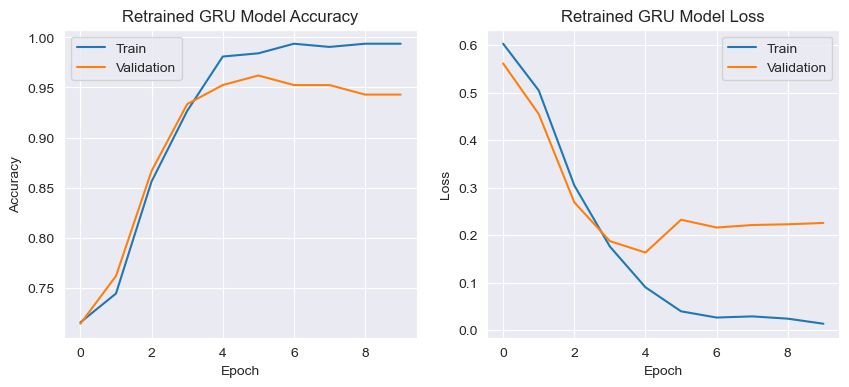

In [49]:
classification_tuned_GRU_model = Sequential()
classification_tuned_GRU_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))  # Adjust output_dim as needed
classification_tuned_GRU_model.add(GRU(units=random_search.best_params_['units'], dropout=random_search.best_params_['dropout'], recurrent_dropout=0.2, return_sequences=True))
classification_tuned_GRU_model.add(GRU(units=random_search.best_params_['units'], dropout=random_search.best_params_['dropout'], recurrent_dropout=0.2))
classification_tuned_GRU_model.add(Dense(1, activation='sigmoid'))

classification_tuned_GRU_model.compile(optimizer=Adam(lr=random_search.best_params_['lr']), loss='binary_crossentropy', metrics=['accuracy'])
classification_tuned_GRU_model.summary()

history_classification_tuned_GRU_model = classification_tuned_GRU_model.fit(data_X_train, scores_y_train, validation_data=(data_X_val, scores_y_val), epochs=30, batch_size=32, callbacks = [early_stopping])

# Final evaluation of the model - Accuracy
scores = classification_tuned_GRU_model.evaluate(data_X_test, scores_y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

# Plot the accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Summarize history for accuracy
ax[0].plot(history_classification_tuned_GRU_model.history['accuracy'])
ax[0].plot(history_classification_tuned_GRU_model.history['val_accuracy'])
ax[0].set_title('Retrained GRU Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
ax[1].plot(history_classification_tuned_GRU_model.history['loss'])
ax[1].plot(history_classification_tuned_GRU_model.history['val_loss'])
ax[1].set_title('Retrained GRU Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

# Show the plot
plt.show()

From the cell output above, after running our GRU model again, the accuracy of GRU can be calculated using `.evaluate()`, where it has increased from 90.48% to  91.43%, meaning that the model has improve with the optimal parameters we got from the hyperparameter tuning. However, the difference between the accuracy and validation is very huge, telling us that the there is still overfitting.

___
# Generating More Reviews - Feature Engineering
___

In [40]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

# Function to find synonyms of a word
def find_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms

# Function to augment a review with synonyms
def augment_review(review):
    tokens = nltk.word_tokenize(review)
    augmented_tokens = []
    for token in tokens:
        synonyms = find_synonyms(token)
        if synonyms:
            synonym = random.choice(synonyms)
            augmented_tokens.append(synonym)
        else:
            augmented_tokens.append(token)
    augmented_review = ' '.join(augmented_tokens)
    return augmented_review

# Original list of reviews
reviews_original = list(data.Review.values)


# Augment all reviews in the list
augmented_reviews = []
for review in reviews_original:
    augmented_review = augment_review(review)
    augmented_reviews.append(augmented_review)

# Print augmented reviews
for i, review in enumerate(augmented_reviews):
    print(f"Augmented Review {i+1}: {review}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\angmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Augmented Review 1: This moving-picture_show follow astound ! The natural_action represent breathless , and the secret_plan embody intriguing .
Augmented Review 2: 1 'm frustrated with the histrion ' performance . non satisfying .
Augmented Review 3: The storyline follow advert and good of emotion . atomic_number_53 jazz information_technology !
Augmented Review 4: This film bear Associate_in_Nursing owing go_through . really enchanting !
Augmented Review 5: also many action scene , sometimes unnecessary . also striking .
Augmented Review 6: one 'm beatify passim the motion-picture_show . engage storytelling !
Augmented Review 7: retaliator : endgame exist unsatisfying and too cliché . non gratifying .
Augmented Review 8: i care how this picture_show conflate constituent of scientific_discipline fiction . interest !
Augmented Review 9: This shoot personify rightfully impressive with deep worked_up feeling .
Augmented Review 10: ampere cinematic know that be unforgettable . atomic_numbe

In [41]:
augmented_reviews = pd.DataFrame({'Review': augmented_reviews, 'Score': data['Score'].values, 'Language': data['Language'].values})
augmented_reviews

,Review,Score,Language
0,This moving-picture_show follow astound ! The ...,0.08,English
1,1 'm frustrated with the histrion ' performanc...,0.70,English
2,The storyline follow advert and good of emotio...,0.12,English
3,This film bear Associate_in_Nursing owing go_t...,0.05,English
4,"also many action scene , sometimes unnecessary...",0.40,English
...,...,...,...
518,dizziness,0.70,Malay
519,good,0.20,Malay
520,stimulate,0.10,Malay
521,simple-minded and bad,0.60,Malay


In [42]:
augmented_and_orginal_review = pd.concat([data, augmented_reviews])
augmented_and_orginal_review

,Review,Score,Language
206,This movie is amazing! The action is breathtak...,0.08,English
207,I'm disappointed with the actors' performance....,0.70,English
208,The storyline is touching and full of emotion....,0.12,English
209,This movie delivers an outstanding experience....,0.05,English
210,"Too many action scenes, sometimes unnecessary....",0.40,English
...,...,...,...
518,dizziness,0.70,Malay
519,good,0.20,Malay
520,stimulate,0.10,Malay
521,simple-minded and bad,0.60,Malay


In [43]:
X_new = list(augmented_and_orginal_review.Review.values)
y_new = augmented_and_orginal_review['Score'].values

y_new = (augmented_and_orginal_review['Score'] >= 0.5).astype(int)

tokenizer_new = Tokenizer()
tokenizer_new.fit_on_texts(X_new)
print(f"{tokenizer_new.word_index}\n")

# Convert the text to sequence
X_new = tokenizer.texts_to_sequences(X_new)

# Print X_new after converting the text to sequence 
print(f"X_new after converting the text to sequence: {X_new}")

# Getting the review lengths
review_lengths_new = [len(seq) for seq in X_new]
maxlen_new = int(np.percentile(review_lengths_new, 95)) 

# Using Pad Sequence on our X_new value
X_new = sequence.pad_sequences(X_new, maxlen=maxlen_new)

# Print X after doing pad sequence on it
print(f"\nX_new after doing pad sequence: {X_new}")

{'the': 1, 'of': 2, 'a': 3, 'and': 4, 'to': 5, 'this': 6, 'plot': 7, 'action': 8, 'film': 9, 'i': 10, 'in': 11, 'with': 12, 'is': 13, 'be': 14, 'movie': 15, 'endgame': 16, 'that': 17, 'visual': 18, 'picture': 19, 'character': 20, 'cinematic': 21, 'avengers': 22, 'end': 23, 'effects': 24, 'emotional': 25, 'like': 26, 'are': 27, 'up': 28, "'s": 29, 'it': 30, 'an': 31, 'very': 32, 'narrative': 33, 'too': 34, 'on': 35, 'storytelling': 36, 'how': 37, 'conclusion': 38, 'not': 39, 'epic': 40, 'amazing': 41, 'twist': 42, 'game': 43, 'make': 44, 'experience': 45, 'many': 46, 'for': 47, 'retaliator': 48, 'avenger': 49, 'surprise': 50, 'from': 51, 'visually': 52, 'interesting': 53, 'excited': 54, 'complex': 55, 'love': 56, 'feel': 57, 'great': 58, 'marvel': 59, 'spectacle': 60, 'show': 61, 'story': 62, 'impressed': 63, 'overall': 64, 'saga': 65, 'motion': 66, "i'm": 67, 'performance': 68, 'storyline': 69, "'m": 70, 'superhero': 71, "film's": 72, 'while': 73, 'intricate': 74, 'associate': 75, 'nur

In [44]:
# Split the data into training and temporary sets
data_X_train_new, data_X_temp_new, scores_y_train_new, scores_y_temp_new = train_test_split(X_new, y_new, test_size=0.4, random_state=42)

# Split the temporary set into validation and test sets
data_X_val_new, data_X_test_new, scores_y_val_new, scores_y_test_new = train_test_split(data_X_temp_new, scores_y_temp_new, test_size=0.5, random_state=42)

# Print the shape of the data
print(f"Shape of data_X_train_new (Reviews): {data_X_train_new.shape}")
print(f"Shape of data_X_test_new (Reviews): {data_X_test_new.shape}")
print(f"Shape of data_X_val_new (Reviews)): {data_X_val_new.shape}")

print(f"\nShape of scores_y_train_new (Scores): {scores_y_train_new.shape}")
print(f"Shape of scores_y_test_new (Scores): {scores_y_test_new.shape}")
print(f"Shape of scores_y_val_new (Scores): {scores_y_val_new.shape}")

Shape of data_X_train_new (Reviews): (627, 40)
Shape of data_X_test_new (Reviews): (210, 40)
Shape of data_X_val_new (Reviews)): (209, 40)

Shape of scores_y_train_new (Scores): (627,)
Shape of scores_y_test_new (Scores): (210,)
Shape of scores_y_val_new (Scores): (209,)


___
# Training SimpleRNN using Augmented & Original Data
___

Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_160 (Embedding)   (None, 40, 100)           198400    
                                                                 
 simple_rnn_88 (SimpleRNN)   (None, 128)               29312     
                                                                 
 dense_160 (Dense)           (None, 1)                 129       
                                                                 
Total params: 227,841
Trainable params: 227,841
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - 2s 59ms/step - loss: 0.6477 - accuracy: 0.6667 - val_loss: 0.6226 - val_accuracy: 0.7416
Epoch 2/30
20/20 [==============================] - 1s 52ms/step - loss: 0.5581 - accuracy: 0.7448 - val_loss: 0.5377 - val_accuracy: 0.7416
Epoch 3/30
20/20 [==========

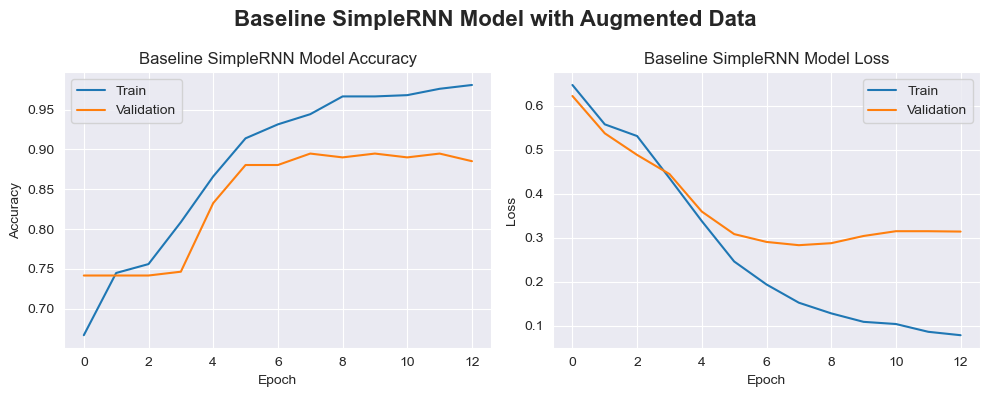

In [45]:
# Defining the vocabulary size for the model
vocab_size_new = len(tokenizer_new.word_index) + 1  # Adding 1 because of reserved 0 index

# Creating Model
new_base_RNN_model = Sequential()
new_base_RNN_model.add(Embedding(input_dim=vocab_size_new, output_dim=100, input_length=maxlen_new))  # Adjust output_dim as needed
new_base_RNN_model.add(SimpleRNN(units=128, dropout=0.2, recurrent_dropout=0.2))
new_base_RNN_model.add(Dense(1, activation='sigmoid'))

new_base_RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_base_RNN_model.summary()

# Training of the model using our data, at 30 epochs, batch size of 32 and using Early_Stopping
history_new_base_RNN_model = new_base_RNN_model.fit(data_X_train_new, scores_y_train_new, validation_data=(data_X_val_new, scores_y_val_new), epochs=30, batch_size=32, callbacks = [early_stopping])

# Final evaluation of the model - Accuracy
new_base_RNN_scores = new_base_RNN_model.evaluate(data_X_test_new, scores_y_test_new, verbose=0)
print("\nAccuracy: %.2f%%" % (new_base_RNN_scores[1]*100))

# Plot the accuracy and loss results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history_new_base_RNN_model.history['accuracy'])
ax[0].plot(history_new_base_RNN_model.history['val_accuracy'])
ax[0].set_title('Baseline SimpleRNN Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history_new_base_RNN_model.history['loss'])
ax[1].plot(history_new_base_RNN_model.history['val_loss'])
ax[1].set_title('Baseline SimpleRNN Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

# Show the plot
fig.suptitle('Baseline SimpleRNN Model with Augmented Data', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

As shown in the output above, there is slight improvement using our augmented data and original data to train the model as the accuracy increases from 87.62% to 89.05%, however, the results may fluctuate.

___
# Training LSTM using Augmented & Original Data
___

Model: "sequential_165"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_165 (Embedding)   (None, 40, 100)           81500     
                                                                 
 lstm_106 (LSTM)             (None, 128)               117248    
                                                                 
 dense_165 (Dense)           (None, 1)                 129       
                                                                 
Total params: 198,877
Trainable params: 198,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - 5s 155ms/step - loss: 0.6166 - accuracy: 0.7337 - val_loss: 0.5723 - val_accuracy: 0.7416
Epoch 2/30
20/20 [==============================] - 3s 149ms/step - loss: 0.5447 - accuracy: 0.7352 - val_loss: 0.5099 - val_accuracy: 0.7416
Epoch 3/30
20/20 [========

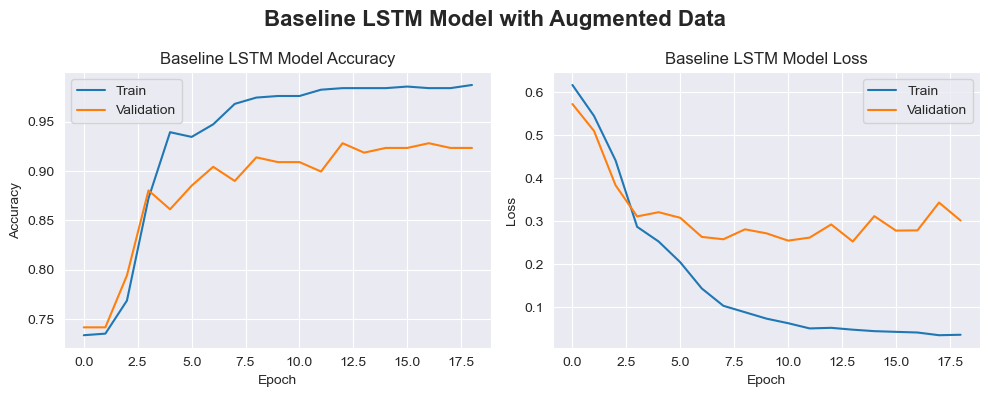

In [51]:
# Creating Model
new_base_LSTM_model = Sequential()
new_base_LSTM_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen_new))  # Adjust output_dim as needed
new_base_LSTM_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
new_base_LSTM_model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
new_base_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_base_LSTM_model.summary()

# Training of the model using our data, at 30 epochs, batch size of 32 and using Early_Stopping
history_new_base_LSTM_model = new_base_LSTM_model.fit(data_X_train_new, scores_y_train_new, validation_data=(data_X_val_new, scores_y_val_new), epochs=30, batch_size=32, callbacks = [early_stopping])

# Final evaluation of the model - Accuracy
new_base_LSTM_scores = new_base_LSTM_model.evaluate(data_X_test_new, scores_y_test_new, verbose=0)
print("\nAccuracy: %.2f%%" % (new_base_LSTM_scores[1]*100))

# Plot the accuracy and loss results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history_new_base_LSTM_model.history['accuracy'])
ax[0].plot(history_new_base_LSTM_model.history['val_accuracy'])
ax[0].set_title('Baseline LSTM Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history_new_base_LSTM_model.history['loss'])
ax[1].plot(history_new_base_LSTM_model.history['val_loss'])
ax[1].set_title('Baseline LSTM Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

# Show the plot
fig.suptitle('Baseline LSTM Model with Augmented Data', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

___
# Training GRU using Augmented & Original Data
___

Model: "sequential_166"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_166 (Embedding)   (None, 40, 100)           81500     
                                                                 
 gru_122 (GRU)               (None, 128)               88320     
                                                                 
 dense_166 (Dense)           (None, 1)                 129       
                                                                 
Total params: 169,949
Trainable params: 169,949
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - 4s 145ms/step - loss: 0.6164 - accuracy: 0.7209 - val_loss: 0.5264 - val_accuracy: 0.7416
Epoch 2/30
20/20 [==============================] - 3s 129ms/step - loss: 0.4898 - accuracy: 0.7432 - val_loss: 0.4221 - val_accuracy: 0.7751
Epoch 3/30
20/20 [========

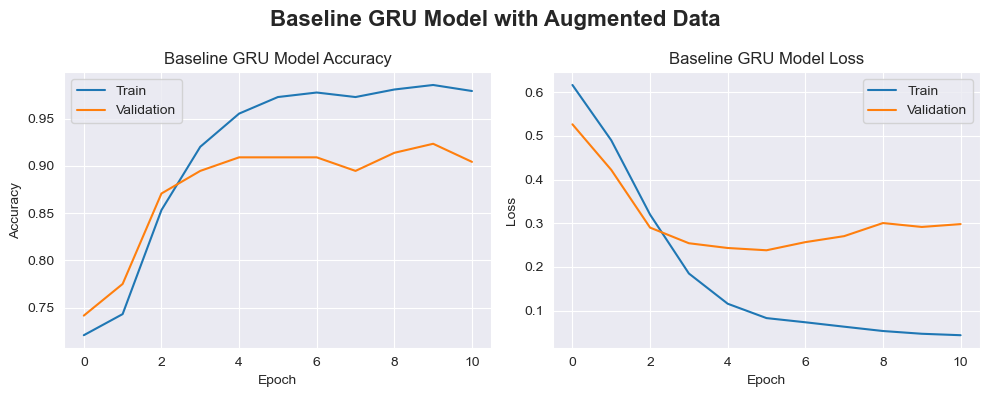

In [52]:
# Create baseline GRU model
new_base_GRU_model = Sequential()
new_base_GRU_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen_new))  # Adjust output_dim as needed
new_base_GRU_model.add(GRU(units=128, dropout=0.2, recurrent_dropout=0.2))
new_base_GRU_model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
new_base_GRU_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_base_GRU_model.summary()

# Training of the model using our data, at 30 epochs, batch size of 32 and using Early_Stopping
history_new_base_GRU_model = new_base_GRU_model.fit(data_X_train_new, scores_y_train_new, validation_data=(data_X_val_new, scores_y_val_new), epochs=30, batch_size=32, callbacks = [early_stopping])

# Final evaluation of the model - Accuracy
new_base_GRU_scores = new_base_GRU_model.evaluate(data_X_test_new, scores_y_test_new, verbose=0)
print("\nAccuracy: %.2f%%" % (new_base_GRU_scores[1]*100))

# Plot the accuracy and loss results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history_new_base_GRU_model.history['accuracy'])
ax[0].plot(history_new_base_GRU_model.history['val_accuracy'])
ax[0].set_title('Baseline GRU Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history_new_base_GRU_model.history['loss'])
ax[1].plot(history_new_base_GRU_model.history['val_loss'])
ax[1].set_title('Baseline GRU Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

# Show the plot
fig.suptitle('Baseline GRU Model with Augmented Data', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

___
# Final Best RNN Model - SimpleRNN
___

In [46]:
# Load the model
best_tuned_RNN_model = load_model('best_tuned_RNN_model.h5')
print("Loaded best_tuned_RNN_model successfully")

# Save the model weights
best_tuned_RNN_model.save_weights('best_tuned_RNN_model_weights.h5')
print("Saved best_tuned_RNN_model weights successfully")

Loaded best_tuned_RNN_model successfully
Saved best_tuned_RNN_model weights successfully


___
# Analysis & Conclusion
___

In conclusion, SimpleRNN has one of the best accuracy and overall least overfitting amongst the three models I have trained on. It also has improvement on the accuracy when I used the augmented & original data to train the SimpleRNN model. Refer to the three line plot below for more insights:

`Simple Recurrent Neural Network Model (Accuracy: ~ 87.62%)`:

![Local Image](./OutputImages/PartB/simplernn_best_tuned_model.png)

`Long short-term memory Model (Accuracy: ~ 91.43%)`:

![Local Image](./OutputImages/PartB/lstm_best_tuned_model.png)

`Gated Recurrent Unit Model (Accuracy: ~ 91.43%)`:

![Local Image](./OutputImages/PartB/gru_best_tuned_model.png)


Using the augmented data, there is not much difference:

Here are several reasons why I think there is no improvement:
1. Quality of Augmented Data: If the augmented data isn't of high quality or doesn't accurately represent the patterns in the original dataset, it may not contribute much to improving the model's performance.
    - Semantic Shift: Possibly due to the usage of synonyms. Synonyms may have slightly different meanings or connotations, which can lead to a semantic shift in the augmented data. This can distort the original intent of the text and result in inaccurate or nonsensical sentences.
    - Limited Synonym Options: Not all words have easily identifiable synonyms, and the available synonyms may not fully capture the diversity of language in the original dataset. This can lead to limited variation in the augmented data.
2. Data Imbalance: If the augmented data introduces class imbalance issues, it may negatively affect the model's ability to generalize, since there are more words now.

___
# End Of Report
___